In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

import os.path as osp
import numpy as np
from PIL import Image
import cv2


1.11.0+cu102 True
0.26.0


In [2]:
# convert dataset annotation to semantic segmentation map
data_root = 'data/Real'
img_dir = 'images'
ann_dir = 'annotations'
# define class and plaette for better visualization
CLASSES = ('background', 'buisson', 'champs', 'eau', 'falaise','foret_dense','foret_claire','pierrier','prairie','route','verger','batiment')
PALETTE = [[0,0,0],[1,1,1],[2,2,2],[3,3,3],[4,4,4],[5,5,5],[6,6,6],[7,7,7],[8,8,8], [9,9,9], [10,10,10], [11,11,11]]
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class HugoDataset(CustomDataset):
    CLASSES = CLASSES
    PALETTE = PALETTE
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                         split=split,reduce_zero_label=False, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None    

In [3]:
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

In [4]:
from mmseg.apis import set_random_seed

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 12
cfg.model.auxiliary_head.num_classes = 12

# Modify dataset type and path
cfg.dataset_type = 'HugoDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(512, 512),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
#cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/pspnet/'

cfg.total_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 200

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = "cuda"

In [5]:
with open('config.txt', 'w') as f:
    print(f'Config:\n{cfg.pretty_text}', 'config.txt', file=f) 

In [6]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)


2022-07-20 11:14:20,619 - mmseg - INFO - Loaded 219 images
/home/hugo/SwinTransfo/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/hugo/SwinTransfo/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [7]:
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-07-20 11:14:28,117 - mmseg - INFO - Loaded 73 images
2022-07-20 11:14:28,119 - mmseg - INFO - Start running, host: hugo@hugobis, work_dir: /home/hugo/SwinTransfo/mmsegmentation/work_dirs/pspnet
2022-07-20 11:14:28,120 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
 -------------------- 
after_train_iter:
(ABOVE_NORMAL)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 15.2 task/s, elapsed: 5s, ETA:     0s

2022-07-20 11:17:52,041 - mmseg - INFO - per class results:
2022-07-20 11:17:52,047 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 14.41 |  23.3 |
|   buisson    |  35.7 | 40.61 |
|    champs    | 45.72 | 87.28 |
|     eau      |  0.0  |  0.0  |
|   falaise    |  0.29 |  0.33 |
| foret_dense  | 48.97 | 84.02 |
| foret_claire | 25.79 | 39.62 |
|   pierrier   | 38.71 | 82.83 |
|   prairie    |  0.23 |  0.23 |
|    route     |  20.3 | 25.66 |
|    verger    |  0.08 |  0.08 |
|   batiment   |  0.0  |  0.0  |
+--------------+-------+-------+
2022-07-20 11:17:52,048 - mmseg - INFO - Summary:
2022-07-20 11:17:52,048 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 49.48 | 19.18 | 32.0 |
+-------+-------+------+
2022-07-20 11:17:52,049 - mmseg - INFO - Iter(val) [73]	aAcc: 0.4948, mIoU: 0.1918, mAcc: 0.3200, IoU.background: 0.1441, IoU.buisson: 0.3570, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.9 task/s, elapsed: 4s, ETA:     0s

2022-07-20 11:21:16,729 - mmseg - INFO - per class results:
2022-07-20 11:21:16,731 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 14.62 | 23.91 |
|   buisson    |  8.87 |  9.78 |
|    champs    | 44.69 | 48.47 |
|     eau      |  0.0  |  0.0  |
|   falaise    |  0.0  |  0.0  |
| foret_dense  |  45.7 | 70.03 |
| foret_claire | 29.37 | 57.09 |
|   pierrier   |  2.69 |  2.94 |
|   prairie    |  5.01 |  7.58 |
|    route     | 12.65 | 22.12 |
|    verger    | 27.11 | 74.19 |
|   batiment   |  7.89 | 31.44 |
+--------------+-------+-------+
2022-07-20 11:21:16,731 - mmseg - INFO - Summary:
2022-07-20 11:21:16,732 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 42.88 | 16.55 | 28.96 |
+-------+-------+-------+
2022-07-20 11:21:16,732 - mmseg - INFO - Iter(val) [73]	aAcc: 0.4288, mIoU: 0.1655, mAcc: 0.2896, IoU.background: 0.1462, IoU.buisson: 0.0887, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.9 task/s, elapsed: 4s, ETA:     0s

2022-07-20 11:24:44,328 - mmseg - INFO - per class results:
2022-07-20 11:24:44,330 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 17.11 | 28.57 |
|   buisson    | 43.75 | 47.72 |
|    champs    | 35.99 | 40.89 |
|     eau      |  0.0  |  0.0  |
|   falaise    |  0.0  |  0.0  |
| foret_dense  | 40.59 | 54.28 |
| foret_claire | 28.35 | 74.64 |
|   pierrier   | 33.67 | 42.55 |
|   prairie    |  2.88 |  2.89 |
|    route     |  5.03 |  7.57 |
|    verger    | 24.99 | 63.87 |
|   batiment   |  3.25 |  3.45 |
+--------------+-------+-------+
2022-07-20 11:24:44,330 - mmseg - INFO - Summary:
2022-07-20 11:24:44,331 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 45.03 | 19.63 | 30.54 |
+-------+-------+-------+
2022-07-20 11:24:44,331 - mmseg - INFO - Iter(val) [73]	aAcc: 0.4503, mIoU: 0.1963, mAcc: 0.3054, IoU.background: 0.1711, IoU.buisson: 0.4375, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-20 11:28:09,506 - mmseg - INFO - per class results:
2022-07-20 11:28:09,508 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 17.91 | 27.78 |
|   buisson    | 27.66 | 28.15 |
|    champs    |  64.5 | 75.17 |
|     eau      |  0.16 |  0.16 |
|   falaise    |  0.0  |  0.0  |
| foret_dense  | 50.19 | 71.77 |
| foret_claire | 34.07 | 83.06 |
|   pierrier   | 50.15 | 61.07 |
|   prairie    |  0.03 |  0.03 |
|    route     | 22.81 | 32.18 |
|    verger    | 47.54 | 64.22 |
|   batiment   | 22.45 |  32.4 |
+--------------+-------+-------+
2022-07-20 11:28:09,508 - mmseg - INFO - Summary:
2022-07-20 11:28:09,509 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 53.99 | 28.12 | 39.67 |
+-------+-------+-------+
2022-07-20 11:28:09,509 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5399, mIoU: 0.2812, mAcc: 0.3967, IoU.background: 0.1791, IoU.buisson: 0.2766, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-20 11:31:37,486 - mmseg - INFO - per class results:
2022-07-20 11:31:37,487 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.92 | 46.48 |
|   buisson    | 42.49 | 87.35 |
|    champs    | 59.76 | 67.34 |
|     eau      | 40.02 |  40.2 |
|   falaise    |  0.4  |  0.4  |
| foret_dense  | 54.46 | 66.75 |
| foret_claire | 30.65 | 40.23 |
|   pierrier   | 27.39 | 32.91 |
|   prairie    |  24.5 | 34.58 |
|    route     | 26.06 |  36.0 |
|    verger    | 61.68 | 85.63 |
|   batiment   | 18.28 | 45.66 |
+--------------+-------+-------+
2022-07-20 11:31:37,488 - mmseg - INFO - Summary:
2022-07-20 11:31:37,488 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 57.88 | 34.13 | 48.63 |
+-------+-------+-------+
2022-07-20 11:31:37,489 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5788, mIoU: 0.3413, mAcc: 0.4863, IoU.background: 0.2392, IoU.buisson: 0.4249, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-20 11:35:02,904 - mmseg - INFO - per class results:
2022-07-20 11:35:02,905 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  19.1 | 33.64 |
|   buisson    | 52.39 | 60.35 |
|    champs    | 62.08 | 74.93 |
|     eau      | 25.99 | 26.02 |
|   falaise    |  2.02 |  2.26 |
| foret_dense  |  55.0 | 75.26 |
| foret_claire | 35.15 | 64.86 |
|   pierrier   | 26.42 | 50.77 |
|   prairie    | 10.98 | 11.68 |
|    route     | 11.43 |  15.9 |
|    verger    | 45.13 | 64.09 |
|   batiment   | 13.83 | 27.44 |
+--------------+-------+-------+
2022-07-20 11:35:02,906 - mmseg - INFO - Summary:
2022-07-20 11:35:02,906 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 57.11 | 29.96 | 42.27 |
+-------+-------+-------+
2022-07-20 11:35:02,907 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5711, mIoU: 0.2996, mAcc: 0.4227, IoU.background: 0.1910, IoU.buisson: 0.5239, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-20 11:38:28,580 - mmseg - INFO - per class results:
2022-07-20 11:38:28,582 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  15.2 | 20.44 |
|   buisson    | 26.49 | 28.45 |
|    champs    | 63.22 | 79.55 |
|     eau      | 35.32 |  41.5 |
|   falaise    | 12.11 | 36.25 |
| foret_dense  | 51.77 |  85.3 |
| foret_claire | 36.63 | 61.67 |
|   pierrier   | 54.41 | 64.05 |
|   prairie    | 23.11 |  32.6 |
|    route     | 14.05 | 14.99 |
|    verger    | 48.89 | 52.21 |
|   batiment   |  6.36 |  6.36 |
+--------------+-------+-------+
2022-07-20 11:38:28,582 - mmseg - INFO - Summary:
2022-07-20 11:38:28,583 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 57.27 | 32.3 | 43.61 |
+-------+------+-------+
2022-07-20 11:38:28,583 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5727, mIoU: 0.3230, mAcc: 0.4361, IoU.background: 0.1520, IoU.buisson: 0.2649, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 11:41:56,396 - mmseg - INFO - per class results:
2022-07-20 11:41:56,398 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 18.95 | 26.82 |
|   buisson    | 58.75 | 66.61 |
|    champs    | 55.71 | 77.12 |
|     eau      | 17.66 |  17.7 |
|   falaise    |  8.98 |  9.5  |
| foret_dense  | 57.25 | 91.19 |
| foret_claire | 37.75 |  54.5 |
|   pierrier   | 57.53 | 75.12 |
|   prairie    | 20.84 | 27.12 |
|    route     | 14.78 | 15.36 |
|    verger    | 55.37 | 63.15 |
|   batiment   | 15.88 | 16.04 |
+--------------+-------+-------+
2022-07-20 11:41:56,398 - mmseg - INFO - Summary:
2022-07-20 11:41:56,399 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 62.22 | 34.95 | 45.02 |
+-------+-------+-------+
2022-07-20 11:41:56,399 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6222, mIoU: 0.3495, mAcc: 0.4502, IoU.background: 0.1895, IoU.buisson: 0.5875, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-20 11:45:22,054 - mmseg - INFO - per class results:
2022-07-20 11:45:22,056 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 12.22 | 15.79 |
|   buisson    | 47.14 | 83.08 |
|    champs    | 55.55 | 63.64 |
|     eau      |  7.16 |  7.16 |
|   falaise    |  0.96 |  0.96 |
| foret_dense  | 51.73 | 69.68 |
| foret_claire | 31.39 | 55.69 |
|   pierrier   | 26.15 | 31.45 |
|   prairie    | 32.12 | 55.35 |
|    route     | 10.43 | 11.05 |
|    verger    | 54.59 | 61.64 |
|   batiment   | 23.88 | 43.34 |
+--------------+-------+-------+
2022-07-20 11:45:22,056 - mmseg - INFO - Summary:
2022-07-20 11:45:22,057 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 56.46 | 29.44 | 41.57 |
+-------+-------+-------+
2022-07-20 11:45:22,057 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5646, mIoU: 0.2944, mAcc: 0.4157, IoU.background: 0.1222, IoU.buisson: 0.4714, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-20 11:48:50,232 - mmseg - INFO - per class results:
2022-07-20 11:48:50,234 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 21.57 | 33.12 |
|   buisson    | 58.06 |  88.4 |
|    champs    | 50.02 | 55.29 |
|     eau      | 66.78 | 68.35 |
|   falaise    | 10.56 | 12.03 |
| foret_dense  | 30.36 | 35.54 |
| foret_claire | 38.49 | 62.83 |
|   pierrier   | 36.83 | 40.43 |
|   prairie    | 22.83 | 61.48 |
|    route     | 28.41 | 52.74 |
|    verger    | 60.87 | 80.41 |
|   batiment   | 22.86 | 23.26 |
+--------------+-------+-------+
2022-07-20 11:48:50,234 - mmseg - INFO - Summary:
2022-07-20 11:48:50,235 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 53.7 | 37.3 | 51.16 |
+------+------+-------+
2022-07-20 11:48:50,235 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5370, mIoU: 0.3730, mAcc: 0.5116, IoU.background: 0.2157, IoU.buisson: 0.5806, IoU.champs: 0.5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.7 task/s, elapsed: 4s, ETA:     0s

2022-07-20 11:52:15,781 - mmseg - INFO - per class results:
2022-07-20 11:52:15,782 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.19 | 44.38 |
|   buisson    | 62.53 | 80.79 |
|    champs    |  60.2 | 64.05 |
|     eau      | 37.71 | 38.78 |
|   falaise    |  0.82 |  1.28 |
| foret_dense  |  59.1 | 79.59 |
| foret_claire |  43.2 | 63.41 |
|   pierrier   |  4.56 |  5.42 |
|   prairie    | 35.48 | 41.75 |
|    route     | 27.49 | 60.18 |
|    verger    | 33.79 | 39.51 |
|   batiment   | 10.14 | 44.71 |
+--------------+-------+-------+
2022-07-20 11:52:15,783 - mmseg - INFO - Summary:
2022-07-20 11:52:15,783 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 61.05 | 33.18 | 46.99 |
+-------+-------+-------+
2022-07-20 11:52:15,784 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6105, mIoU: 0.3318, mAcc: 0.4699, IoU.background: 0.2319, IoU.buisson: 0.6253, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 11:55:41,626 - mmseg - INFO - per class results:
2022-07-20 11:55:41,627 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 20.02 | 28.19 |
|   buisson    | 62.98 | 71.88 |
|    champs    | 60.28 | 68.96 |
|     eau      | 56.54 | 57.93 |
|   falaise    |  6.92 |  8.14 |
| foret_dense  | 62.02 | 74.33 |
| foret_claire | 41.14 |  82.4 |
|   pierrier   | 49.65 | 62.57 |
|   prairie    | 39.11 | 56.39 |
|    route     | 22.59 | 35.78 |
|    verger    | 60.51 | 62.73 |
|   batiment   |  4.14 |  4.29 |
+--------------+-------+-------+
2022-07-20 11:55:41,628 - mmseg - INFO - Summary:
2022-07-20 11:55:41,628 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 65.15 | 40.49 | 51.13 |
+-------+-------+-------+
2022-07-20 11:55:41,629 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6515, mIoU: 0.4049, mAcc: 0.5113, IoU.background: 0.2002, IoU.buisson: 0.6298, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-20 11:59:09,833 - mmseg - INFO - per class results:
2022-07-20 11:59:09,834 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.43 | 36.22 |
|   buisson    | 34.51 | 93.57 |
|    champs    | 56.82 | 79.87 |
|     eau      | 65.08 | 66.44 |
|   falaise    | 15.66 | 20.64 |
| foret_dense  | 56.32 | 67.26 |
| foret_claire | 11.81 | 14.79 |
|   pierrier   | 50.94 | 72.17 |
|   prairie    | 21.44 |  27.5 |
|    route     | 32.83 |  55.6 |
|    verger    | 62.22 | 65.12 |
|   batiment   |  6.4  |  6.56 |
+--------------+-------+-------+
2022-07-20 11:59:09,835 - mmseg - INFO - Summary:
2022-07-20 11:59:09,835 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 55.67 | 36.46 | 50.48 |
+-------+-------+-------+
2022-07-20 11:59:09,836 - mmseg - INFO - Iter(val) [73]	aAcc: 0.5567, mIoU: 0.3646, mAcc: 0.5048, IoU.background: 0.2343, IoU.buisson: 0.3451, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 12:02:35,801 - mmseg - INFO - per class results:
2022-07-20 12:02:35,803 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.25 | 43.09 |
|   buisson    | 55.45 | 89.94 |
|    champs    | 69.01 | 86.09 |
|     eau      | 65.88 | 75.16 |
|   falaise    |  0.34 |  0.35 |
| foret_dense  | 60.16 | 72.86 |
| foret_claire |  31.0 | 38.72 |
|   pierrier   | 52.69 | 78.07 |
|   prairie    | 42.76 | 60.62 |
|    route     |  6.8  |  6.83 |
|    verger    | 57.43 | 81.15 |
|   batiment   | 31.85 |  38.1 |
+--------------+-------+-------+
2022-07-20 12:02:35,803 - mmseg - INFO - Summary:
2022-07-20 12:02:35,804 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 65.35 | 41.55 | 55.92 |
+-------+-------+-------+
2022-07-20 12:02:35,805 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6535, mIoU: 0.4155, mAcc: 0.5592, IoU.background: 0.2525, IoU.buisson: 0.5545, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 12:06:04,629 - mmseg - INFO - per class results:
2022-07-20 12:06:04,631 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.63 | 39.79 |
|   buisson    | 57.48 | 61.65 |
|    champs    | 58.35 | 71.14 |
|     eau      | 66.91 | 68.85 |
|   falaise    | 15.35 | 25.13 |
| foret_dense  | 57.57 | 67.24 |
| foret_claire | 41.65 | 72.91 |
|   pierrier   |  20.5 | 24.02 |
|   prairie    | 41.37 | 64.03 |
|    route     | 36.51 | 56.65 |
|    verger    | 57.71 | 64.43 |
|   batiment   | 18.72 | 79.57 |
+--------------+-------+-------+
2022-07-20 12:06:04,631 - mmseg - INFO - Summary:
2022-07-20 12:06:04,632 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 62.79 | 41.31 | 57.95 |
+-------+-------+-------+
2022-07-20 12:06:04,633 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6279, mIoU: 0.4131, mAcc: 0.5795, IoU.background: 0.2363, IoU.buisson: 0.5748, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-20 12:09:30,492 - mmseg - INFO - per class results:
2022-07-20 12:09:30,493 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 20.99 | 31.77 |
|   buisson    | 50.94 | 90.35 |
|    champs    | 61.41 | 73.44 |
|     eau      | 68.21 |  76.7 |
|   falaise    |  16.0 |  17.7 |
| foret_dense  | 60.48 | 68.86 |
| foret_claire | 27.96 | 48.17 |
|   pierrier   | 54.66 | 68.46 |
|   prairie    | 39.31 | 50.71 |
|    route     | 30.04 | 42.56 |
|    verger    | 64.46 | 81.52 |
|   batiment   | 15.31 | 15.65 |
+--------------+-------+-------+
2022-07-20 12:09:30,494 - mmseg - INFO - Summary:
2022-07-20 12:09:30,494 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 62.8 | 42.48 | 55.49 |
+------+-------+-------+
2022-07-20 12:09:30,495 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6280, mIoU: 0.4248, mAcc: 0.5549, IoU.background: 0.2099, IoU.buisson: 0.5094, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 12:12:56,373 - mmseg - INFO - per class results:
2022-07-20 12:12:56,374 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 24.04 | 36.37 |
|   buisson    | 59.34 |  63.5 |
|    champs    | 65.84 | 84.06 |
|     eau      | 71.18 | 73.74 |
|   falaise    | 13.98 |  43.6 |
| foret_dense  | 51.15 | 57.93 |
| foret_claire | 46.17 | 79.72 |
|   pierrier   | 51.31 | 62.26 |
|   prairie    | 35.61 |  66.2 |
|    route     | 44.99 | 57.27 |
|    verger    | 68.68 | 72.53 |
|   batiment   | 19.05 | 20.55 |
+--------------+-------+-------+
2022-07-20 12:12:56,375 - mmseg - INFO - Summary:
2022-07-20 12:12:56,375 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 64.53 | 45.94 | 59.81 |
+-------+-------+-------+
2022-07-20 12:12:56,376 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6453, mIoU: 0.4594, mAcc: 0.5981, IoU.background: 0.2404, IoU.buisson: 0.5934, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 12:16:24,937 - mmseg - INFO - per class results:
2022-07-20 12:16:24,938 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.94 | 48.75 |
|   buisson    | 58.31 | 86.71 |
|    champs    | 70.51 | 80.24 |
|     eau      | 63.11 | 66.88 |
|   falaise    | 15.26 | 31.77 |
| foret_dense  | 66.24 | 74.98 |
| foret_claire | 38.02 | 50.09 |
|   pierrier   | 49.55 | 70.77 |
|   prairie    | 44.05 | 65.14 |
|    route     |  9.66 |  9.69 |
|    verger    | 68.98 | 76.64 |
|   batiment   | 28.06 | 55.85 |
+--------------+-------+-------+
2022-07-20 12:16:24,939 - mmseg - INFO - Summary:
2022-07-20 12:16:24,939 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 67.43 | 44.81 | 59.79 |
+-------+-------+-------+
2022-07-20 12:16:24,940 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6743, mIoU: 0.4481, mAcc: 0.5979, IoU.background: 0.2594, IoU.buisson: 0.5831, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 12:19:51,116 - mmseg - INFO - per class results:
2022-07-20 12:19:51,118 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 24.39 | 36.44 |
|   buisson    | 66.63 |  87.7 |
|    champs    | 56.76 | 82.52 |
|     eau      | 72.49 | 85.68 |
|   falaise    | 22.25 | 55.91 |
| foret_dense  | 70.37 | 86.92 |
| foret_claire | 40.77 | 50.19 |
|   pierrier   |  32.2 | 33.83 |
|   prairie    | 51.92 | 64.76 |
|    route     |  43.8 | 59.94 |
|    verger    | 62.84 | 78.63 |
|   batiment   | 14.99 |  16.6 |
+--------------+-------+-------+
2022-07-20 12:19:51,118 - mmseg - INFO - Summary:
2022-07-20 12:19:51,119 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 69.98 | 46.62 | 61.59 |
+-------+-------+-------+
2022-07-20 12:19:51,119 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6998, mIoU: 0.4662, mAcc: 0.6159, IoU.background: 0.2439, IoU.buisson: 0.6663, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 12:23:19,911 - mmseg - INFO - per class results:
2022-07-20 12:23:19,913 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.95 | 52.91 |
|   buisson    | 66.87 | 81.99 |
|    champs    | 63.52 | 81.85 |
|     eau      | 64.93 | 66.29 |
|   falaise    | 25.53 | 28.96 |
| foret_dense  | 60.28 | 69.47 |
| foret_claire | 43.15 | 69.89 |
|   pierrier   |  7.3  |  7.89 |
|   prairie    | 47.94 | 59.73 |
|    route     | 26.17 |  28.5 |
|    verger    | 64.63 | 74.84 |
|   batiment   | 14.24 | 25.27 |
+--------------+-------+-------+
2022-07-20 12:23:19,913 - mmseg - INFO - Summary:
2022-07-20 12:23:19,914 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 66.12 | 42.54 | 53.97 |
+-------+-------+-------+
2022-07-20 12:23:19,914 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6612, mIoU: 0.4254, mAcc: 0.5397, IoU.background: 0.2595, IoU.buisson: 0.6687, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 12:26:46,652 - mmseg - INFO - per class results:
2022-07-20 12:26:46,653 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.92 | 66.08 |
|   buisson    | 69.49 | 77.83 |
|    champs    | 71.56 | 77.75 |
|     eau      | 74.33 | 77.82 |
|   falaise    | 33.73 | 39.73 |
| foret_dense  |  69.2 | 82.39 |
| foret_claire | 41.99 | 49.04 |
|   pierrier   | 40.54 | 46.08 |
|   prairie    | 49.44 | 76.56 |
|    route     | 44.35 | 53.04 |
|    verger    | 73.25 | 78.27 |
|   batiment   | 14.72 | 22.71 |
+--------------+-------+-------+
2022-07-20 12:26:46,654 - mmseg - INFO - Summary:
2022-07-20 12:26:46,654 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 70.76 | 50.96 | 62.27 |
+-------+-------+-------+
2022-07-20 12:26:46,655 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7076, mIoU: 0.5096, mAcc: 0.6227, IoU.background: 0.2892, IoU.buisson: 0.6949, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.6 task/s, elapsed: 4s, ETA:     0s

2022-07-20 12:30:13,112 - mmseg - INFO - per class results:
2022-07-20 12:30:13,113 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  23.7 | 36.51 |
|   buisson    | 38.38 | 92.68 |
|    champs    | 54.39 | 86.08 |
|     eau      | 72.81 | 77.41 |
|   falaise    |  43.0 | 50.94 |
| foret_dense  | 60.78 | 68.43 |
| foret_claire | 17.15 | 19.78 |
|   pierrier   | 57.69 | 63.57 |
|   prairie    | 39.27 | 54.54 |
|    route     | 41.06 | 65.58 |
|    verger    | 64.73 | 71.28 |
|   batiment   |  4.55 |  4.55 |
+--------------+-------+-------+
2022-07-20 12:30:13,114 - mmseg - INFO - Summary:
2022-07-20 12:30:13,114 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 60.64 | 43.13 | 57.61 |
+-------+-------+-------+
2022-07-20 12:30:13,115 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6064, mIoU: 0.4313, mAcc: 0.5761, IoU.background: 0.2370, IoU.buisson: 0.3838, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 12:33:41,825 - mmseg - INFO - per class results:
2022-07-20 12:33:41,826 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.02 | 40.52 |
|   buisson    | 62.74 | 67.68 |
|    champs    | 56.57 | 78.89 |
|     eau      | 73.15 | 80.53 |
|   falaise    |  8.98 | 16.59 |
| foret_dense  |  67.5 | 77.62 |
| foret_claire | 46.64 | 77.07 |
|   pierrier   | 55.84 |  83.4 |
|   prairie    |  43.9 | 58.43 |
|    route     |  48.1 | 59.12 |
|    verger    | 45.26 | 47.18 |
|   batiment   | 18.01 | 21.32 |
+--------------+-------+-------+
2022-07-20 12:33:41,827 - mmseg - INFO - Summary:
2022-07-20 12:33:41,827 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 68.32 | 46.06 | 59.03 |
+-------+-------+-------+
2022-07-20 12:33:41,828 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6832, mIoU: 0.4606, mAcc: 0.5903, IoU.background: 0.2602, IoU.buisson: 0.6274, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 12:37:08,317 - mmseg - INFO - per class results:
2022-07-20 12:37:08,318 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 18.39 | 35.86 |
|   buisson    | 65.11 | 78.29 |
|    champs    | 60.39 | 74.91 |
|     eau      | 66.14 | 69.07 |
|   falaise    | 36.86 | 51.27 |
| foret_dense  | 65.02 | 71.95 |
| foret_claire | 42.95 | 72.73 |
|   pierrier   |  10.5 | 10.99 |
|   prairie    | 46.39 | 66.28 |
|    route     | 34.74 | 39.82 |
|    verger    | 65.94 | 74.01 |
|   batiment   | 16.73 | 36.07 |
+--------------+-------+-------+
2022-07-20 12:37:08,319 - mmseg - INFO - Summary:
2022-07-20 12:37:08,319 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 65.75 | 44.1 | 56.77 |
+-------+------+-------+
2022-07-20 12:37:08,320 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6575, mIoU: 0.4410, mAcc: 0.5677, IoU.background: 0.1839, IoU.buisson: 0.6511, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 12:40:37,066 - mmseg - INFO - per class results:
2022-07-20 12:40:37,068 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.71 | 45.11 |
|   buisson    | 62.44 |  89.2 |
|    champs    | 66.51 | 83.31 |
|     eau      | 75.34 | 77.92 |
|   falaise    | 22.63 | 47.07 |
| foret_dense  |  67.9 | 74.99 |
| foret_claire | 41.91 | 57.96 |
|   pierrier   | 36.49 | 37.99 |
|   prairie    | 56.34 | 74.04 |
|    route     | 35.31 | 39.01 |
|    verger    |  59.2 | 85.67 |
|   batiment   | 32.66 | 38.19 |
+--------------+-------+-------+
2022-07-20 12:40:37,068 - mmseg - INFO - Summary:
2022-07-20 12:40:37,069 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 69.9 | 48.62 | 62.54 |
+------+-------+-------+
2022-07-20 12:40:37,070 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6990, mIoU: 0.4862, mAcc: 0.6254, IoU.background: 0.2671, IoU.buisson: 0.6244, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 12:44:03,254 - mmseg - INFO - per class results:
2022-07-20 12:44:03,256 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.43 | 44.44 |
|   buisson    | 63.96 | 82.27 |
|    champs    | 66.87 | 85.36 |
|     eau      | 73.24 | 87.87 |
|   falaise    | 18.59 | 78.57 |
| foret_dense  | 70.51 | 77.51 |
| foret_claire | 43.43 | 63.91 |
|   pierrier   | 43.67 | 51.64 |
|   prairie    | 52.02 | 60.81 |
|    route     | 33.37 | 36.74 |
|    verger    | 71.85 | 81.48 |
|   batiment   | 20.43 | 21.39 |
+--------------+-------+-------+
2022-07-20 12:44:03,256 - mmseg - INFO - Summary:
2022-07-20 12:44:03,257 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 70.32 | 48.7 | 64.33 |
+-------+------+-------+
2022-07-20 12:44:03,257 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7032, mIoU: 0.4870, mAcc: 0.6433, IoU.background: 0.2643, IoU.buisson: 0.6396, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.1 task/s, elapsed: 4s, ETA:     0s

2022-07-20 12:47:29,965 - mmseg - INFO - per class results:
2022-07-20 12:47:29,967 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.86 | 48.56 |
|   buisson    | 69.37 | 76.74 |
|    champs    | 72.88 | 77.91 |
|     eau      | 71.84 | 81.87 |
|   falaise    | 36.49 | 37.52 |
| foret_dense  | 71.63 |  83.7 |
| foret_claire | 48.98 | 76.11 |
|   pierrier   | 56.54 | 66.28 |
|   prairie    |  56.4 | 68.68 |
|    route     | 35.61 | 39.31 |
|    verger    | 72.62 | 78.95 |
|   batiment   | 28.69 | 55.46 |
+--------------+-------+-------+
2022-07-20 12:47:29,969 - mmseg - INFO - Summary:
2022-07-20 12:47:29,970 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.81 | 54.16 | 65.92 |
+-------+-------+-------+
2022-07-20 12:47:29,971 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7381, mIoU: 0.5416, mAcc: 0.6592, IoU.background: 0.2886, IoU.buisson: 0.6937, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 12:50:58,715 - mmseg - INFO - per class results:
2022-07-20 12:50:58,716 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  28.0 |  48.1 |
|   buisson    |  69.6 | 87.51 |
|    champs    | 67.34 | 84.12 |
|     eau      | 72.91 | 88.07 |
|   falaise    | 45.29 | 50.13 |
| foret_dense  | 71.02 | 79.53 |
| foret_claire |  47.7 | 62.82 |
|   pierrier   | 62.68 | 75.06 |
|   prairie    | 54.35 | 73.06 |
|    route     | 38.01 | 42.31 |
|    verger    | 71.77 | 82.71 |
|   batiment   | 30.94 | 38.14 |
+--------------+-------+-------+
2022-07-20 12:50:58,717 - mmseg - INFO - Summary:
2022-07-20 12:50:58,717 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.57 | 54.97 | 67.63 |
+-------+-------+-------+
2022-07-20 12:50:58,718 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7357, mIoU: 0.5497, mAcc: 0.6763, IoU.background: 0.2800, IoU.buisson: 0.6960, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 12:54:25,212 - mmseg - INFO - per class results:
2022-07-20 12:54:25,213 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.79 | 37.81 |
|   buisson    | 67.21 | 81.17 |
|    champs    | 63.53 |  83.5 |
|     eau      | 80.39 | 85.32 |
|   falaise    | 40.69 |  60.7 |
| foret_dense  | 64.42 |  72.1 |
| foret_claire | 46.27 | 75.54 |
|   pierrier   | 55.86 | 64.16 |
|   prairie    |  55.4 | 77.24 |
|    route     | 45.16 | 61.65 |
|    verger    | 54.62 | 58.49 |
|   batiment   | 19.25 | 20.93 |
+--------------+-------+-------+
2022-07-20 12:54:25,214 - mmseg - INFO - Summary:
2022-07-20 12:54:25,214 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 70.59 | 51.55 | 64.89 |
+-------+-------+-------+
2022-07-20 12:54:25,215 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7059, mIoU: 0.5155, mAcc: 0.6489, IoU.background: 0.2579, IoU.buisson: 0.6721, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 12:57:54,113 - mmseg - INFO - per class results:
2022-07-20 12:57:54,114 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.95 | 43.49 |
|   buisson    | 72.61 | 80.91 |
|    champs    | 74.82 | 87.77 |
|     eau      | 71.96 | 90.39 |
|   falaise    |  0.0  |  0.0  |
| foret_dense  | 69.87 | 93.02 |
| foret_claire | 36.52 | 42.96 |
|   pierrier   | 30.07 | 35.03 |
|   prairie    | 56.38 | 66.91 |
|    route     | 41.96 | 46.71 |
|    verger    | 70.64 | 80.64 |
|   batiment   |  13.8 | 65.94 |
+--------------+-------+-------+
2022-07-20 12:57:54,115 - mmseg - INFO - Summary:
2022-07-20 12:57:54,115 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 71.1 | 47.05 | 61.15 |
+------+-------+-------+
2022-07-20 12:57:54,116 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7110, mIoU: 0.4705, mAcc: 0.6115, IoU.background: 0.2595, IoU.buisson: 0.7261, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 13:01:20,378 - mmseg - INFO - per class results:
2022-07-20 13:01:20,379 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.05 | 48.44 |
|   buisson    | 48.71 | 89.58 |
|    champs    | 69.35 | 79.98 |
|     eau      | 60.87 | 88.38 |
|   falaise    | 39.35 | 74.69 |
| foret_dense  | 62.04 | 67.77 |
| foret_claire | 27.85 | 35.07 |
|   pierrier   | 46.62 | 89.72 |
|   prairie    | 51.59 | 65.13 |
|    route     | 40.48 | 47.93 |
|    verger    | 71.29 |  81.1 |
|   batiment   | 38.78 | 55.61 |
+--------------+-------+-------+
2022-07-20 13:01:20,380 - mmseg - INFO - Summary:
2022-07-20 13:01:20,380 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 66.07 | 48.75 | 68.62 |
+-------+-------+-------+
2022-07-20 13:01:20,381 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6607, mIoU: 0.4875, mAcc: 0.6862, IoU.background: 0.2805, IoU.buisson: 0.4871, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 13:04:49,061 - mmseg - INFO - per class results:
2022-07-20 13:04:49,063 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.61 | 45.77 |
|   buisson    | 33.47 | 37.35 |
|    champs    | 64.43 | 86.81 |
|     eau      | 67.83 | 81.79 |
|   falaise    | 34.79 | 42.04 |
| foret_dense  | 69.29 | 92.83 |
| foret_claire | 35.45 | 40.36 |
|   pierrier   | 23.34 | 27.85 |
|   prairie    | 36.89 | 67.81 |
|    route     | 45.94 | 53.97 |
|    verger    | 67.26 | 77.73 |
|   batiment   |  9.02 | 11.75 |
+--------------+-------+-------+
2022-07-20 13:04:49,063 - mmseg - INFO - Summary:
2022-07-20 13:04:49,064 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 65.37 | 42.78 | 55.5 |
+-------+-------+------+
2022-07-20 13:04:49,064 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6537, mIoU: 0.4278, mAcc: 0.5550, IoU.background: 0.2561, IoU.buisson: 0.3347, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 13:08:15,255 - mmseg - INFO - per class results:
2022-07-20 13:08:15,257 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.53 | 53.25 |
|   buisson    | 70.55 | 81.19 |
|    champs    |  69.8 | 86.86 |
|     eau      | 76.74 | 86.24 |
|   falaise    | 34.06 | 61.25 |
| foret_dense  |  72.0 | 88.01 |
| foret_claire | 48.21 |  63.0 |
|   pierrier   | 47.01 | 51.62 |
|   prairie    | 58.08 | 69.43 |
|    route     | 43.05 | 51.86 |
|    verger    | 62.53 |  64.0 |
|   batiment   | 17.21 |  20.7 |
+--------------+-------+-------+
2022-07-20 13:08:15,257 - mmseg - INFO - Summary:
2022-07-20 13:08:15,258 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.77 | 52.48 | 64.79 |
+-------+-------+-------+
2022-07-20 13:08:15,258 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7377, mIoU: 0.5248, mAcc: 0.6479, IoU.background: 0.3053, IoU.buisson: 0.7055, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 13:11:41,573 - mmseg - INFO - per class results:
2022-07-20 13:11:41,575 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.83 | 44.86 |
|   buisson    | 54.98 | 60.75 |
|    champs    | 71.89 | 79.99 |
|     eau      | 79.57 | 90.79 |
|   falaise    | 29.36 | 30.01 |
| foret_dense  | 70.59 | 79.23 |
| foret_claire | 47.56 | 81.61 |
|   pierrier   |  63.3 | 73.48 |
|   prairie    | 55.22 | 76.33 |
|    route     | 35.08 | 37.85 |
|    verger    | 69.71 | 72.08 |
|   batiment   | 26.18 | 39.05 |
+--------------+-------+-------+
2022-07-20 13:11:41,575 - mmseg - INFO - Summary:
2022-07-20 13:11:41,576 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.05 | 52.61 | 63.84 |
+-------+-------+-------+
2022-07-20 13:11:41,577 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7205, mIoU: 0.5261, mAcc: 0.6384, IoU.background: 0.2783, IoU.buisson: 0.5498, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 13:15:10,351 - mmseg - INFO - per class results:
2022-07-20 13:15:10,353 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.92 | 42.82 |
|   buisson    | 61.62 | 82.34 |
|    champs    | 72.11 | 83.88 |
|     eau      |  80.9 | 88.98 |
|   falaise    | 50.28 | 66.19 |
| foret_dense  |  53.9 | 56.93 |
| foret_claire | 39.99 | 72.93 |
|   pierrier   |  66.0 | 81.49 |
|   prairie    | 55.78 | 72.08 |
|    route     | 50.49 | 70.83 |
|    verger    | 71.91 | 76.84 |
|   batiment   | 30.88 | 35.83 |
+--------------+-------+-------+
2022-07-20 13:15:10,353 - mmseg - INFO - Summary:
2022-07-20 13:15:10,354 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 68.42 | 54.98 | 69.26 |
+-------+-------+-------+
2022-07-20 13:15:10,354 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6842, mIoU: 0.5498, mAcc: 0.6926, IoU.background: 0.2592, IoU.buisson: 0.6162, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 13:18:36,382 - mmseg - INFO - per class results:
2022-07-20 13:18:36,383 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.09 | 46.74 |
|   buisson    | 71.36 | 79.79 |
|    champs    | 66.57 |  89.6 |
|     eau      | 80.36 | 84.86 |
|   falaise    | 33.92 | 72.18 |
| foret_dense  | 70.68 | 91.37 |
| foret_claire | 35.91 | 41.87 |
|   pierrier   | 37.66 | 39.99 |
|   prairie    |  59.2 | 70.54 |
|    route     | 43.03 | 49.95 |
|    verger    | 68.59 | 77.72 |
|   batiment   | 23.59 | 56.37 |
+--------------+-------+-------+
2022-07-20 13:18:36,384 - mmseg - INFO - Summary:
2022-07-20 13:18:36,384 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 71.77 | 51.5 | 66.75 |
+-------+------+-------+
2022-07-20 13:18:36,385 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7177, mIoU: 0.5150, mAcc: 0.6675, IoU.background: 0.2709, IoU.buisson: 0.7136, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 13:22:05,059 - mmseg - INFO - per class results:
2022-07-20 13:22:05,061 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.37 | 53.54 |
|   buisson    | 64.53 | 76.74 |
|    champs    | 68.64 | 77.52 |
|     eau      | 76.66 | 93.66 |
|   falaise    |  8.87 |  9.16 |
| foret_dense  | 68.92 | 82.45 |
| foret_claire | 48.11 | 61.21 |
|   pierrier   | 55.35 | 80.47 |
|   prairie    | 48.98 | 70.42 |
|    route     | 45.39 |  57.9 |
|    verger    |  69.6 | 76.65 |
|   batiment   |  21.6 | 22.97 |
+--------------+-------+-------+
2022-07-20 13:22:05,061 - mmseg - INFO - Summary:
2022-07-20 13:22:05,062 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.19 | 50.59 | 63.56 |
+-------+-------+-------+
2022-07-20 13:22:05,062 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7219, mIoU: 0.5059, mAcc: 0.6356, IoU.background: 0.3037, IoU.buisson: 0.6453, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 13:25:31,276 - mmseg - INFO - per class results:
2022-07-20 13:25:31,278 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.78 | 49.22 |
|   buisson    | 65.84 | 87.02 |
|    champs    | 66.18 | 78.48 |
|     eau      |  73.2 |  83.9 |
|   falaise    | 17.11 | 17.91 |
| foret_dense  | 66.61 | 77.05 |
| foret_claire | 46.61 | 60.31 |
|   pierrier   |  27.1 |  31.4 |
|   prairie    | 54.37 | 79.18 |
|    route     | 39.94 | 43.87 |
|    verger    | 68.76 | 81.44 |
|   batiment   | 23.65 | 43.53 |
+--------------+-------+-------+
2022-07-20 13:25:31,278 - mmseg - INFO - Summary:
2022-07-20 13:25:31,279 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 70.39 | 48.01 | 61.11 |
+-------+-------+-------+
2022-07-20 13:25:31,279 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7039, mIoU: 0.4801, mAcc: 0.6111, IoU.background: 0.2678, IoU.buisson: 0.6584, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 13:28:57,655 - mmseg - INFO - per class results:
2022-07-20 13:28:57,657 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.5 | 60.81 |
|   buisson    | 57.34 | 92.35 |
|    champs    | 77.07 | 87.16 |
|     eau      | 71.48 | 73.92 |
|   falaise    | 33.87 | 72.35 |
| foret_dense  |  73.1 | 92.11 |
| foret_claire | 22.92 | 23.89 |
|   pierrier   | 39.96 | 41.93 |
|   prairie    | 52.23 |  55.0 |
|    route     | 42.76 | 51.64 |
|    verger    | 80.34 | 89.93 |
|   batiment   | 33.64 | 62.85 |
+--------------+-------+-------+
2022-07-20 13:28:57,657 - mmseg - INFO - Summary:
2022-07-20 13:28:57,658 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 70.83 | 51.27 | 66.99 |
+-------+-------+-------+
2022-07-20 13:28:57,658 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7083, mIoU: 0.5127, mAcc: 0.6699, IoU.background: 0.3050, IoU.buisson: 0.5734, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 13:32:26,377 - mmseg - INFO - per class results:
2022-07-20 13:32:26,379 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.24 |  32.9 |
|   buisson    | 58.56 | 69.57 |
|    champs    |  76.0 | 87.76 |
|     eau      | 76.62 |  88.4 |
|   falaise    |  18.9 | 80.31 |
| foret_dense  | 65.55 | 72.31 |
| foret_claire | 45.18 | 77.96 |
|   pierrier   | 34.27 | 45.43 |
|   prairie    | 50.77 | 67.67 |
|    route     | 51.93 | 64.83 |
|    verger    | 62.12 | 67.97 |
|   batiment   | 18.86 | 21.22 |
+--------------+-------+-------+
2022-07-20 13:32:26,379 - mmseg - INFO - Summary:
2022-07-20 13:32:26,380 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 69.06 | 48.5 | 64.69 |
+-------+------+-------+
2022-07-20 13:32:26,380 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6906, mIoU: 0.4850, mAcc: 0.6469, IoU.background: 0.2324, IoU.buisson: 0.5856, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 13:35:52,614 - mmseg - INFO - per class results:
2022-07-20 13:35:52,615 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.73 | 37.58 |
|   buisson    | 61.85 | 79.34 |
|    champs    | 64.35 |  70.5 |
|     eau      | 74.29 | 96.81 |
|   falaise    | 47.05 | 64.72 |
| foret_dense  | 68.78 | 76.97 |
| foret_claire | 44.14 | 64.57 |
|   pierrier   | 62.79 | 71.39 |
|   prairie    | 52.66 | 87.68 |
|    route     | 45.37 | 50.19 |
|    verger    | 73.64 | 88.89 |
|   batiment   | 38.08 | 40.31 |
+--------------+-------+-------+
2022-07-20 13:35:52,616 - mmseg - INFO - Summary:
2022-07-20 13:35:52,616 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.81 | 54.89 | 69.08 |
+-------+-------+-------+
2022-07-20 13:35:52,618 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7181, mIoU: 0.5489, mAcc: 0.6908, IoU.background: 0.2573, IoU.buisson: 0.6185, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 13:39:21,380 - mmseg - INFO - per class results:
2022-07-20 13:39:21,382 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.44 | 49.72 |
|   buisson    |  49.8 | 93.15 |
|    champs    | 72.98 | 79.45 |
|     eau      | 76.28 | 84.38 |
|   falaise    | 28.52 | 68.05 |
| foret_dense  | 68.19 |  72.1 |
| foret_claire | 30.31 |  42.5 |
|   pierrier   |  46.6 |  54.7 |
|   prairie    | 56.19 | 66.52 |
|    route     |  50.5 | 74.02 |
|    verger    | 76.42 | 89.02 |
|   batiment   | 43.72 | 47.06 |
+--------------+-------+-------+
2022-07-20 13:39:21,382 - mmseg - INFO - Summary:
2022-07-20 13:39:21,383 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 68.45 | 52.33 | 68.39 |
+-------+-------+-------+
2022-07-20 13:39:21,383 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6845, mIoU: 0.5233, mAcc: 0.6839, IoU.background: 0.2844, IoU.buisson: 0.4980, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 13:42:47,378 - mmseg - INFO - per class results:
2022-07-20 13:42:47,380 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.69 | 41.55 |
|   buisson    | 62.35 | 75.41 |
|    champs    | 69.38 | 90.61 |
|     eau      |  77.8 | 88.86 |
|   falaise    |  39.2 | 60.68 |
| foret_dense  | 73.56 | 86.66 |
| foret_claire | 51.93 | 68.58 |
|   pierrier   | 47.81 | 56.22 |
|   prairie    | 57.82 | 77.58 |
|    route     | 40.83 | 46.91 |
|    verger    | 65.32 | 69.65 |
|   batiment   | 22.95 | 25.47 |
+--------------+-------+-------+
2022-07-20 13:42:47,380 - mmseg - INFO - Summary:
2022-07-20 13:42:47,381 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.2 | 53.05 | 65.68 |
+------+-------+-------+
2022-07-20 13:42:47,381 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7420, mIoU: 0.5305, mAcc: 0.6568, IoU.background: 0.2769, IoU.buisson: 0.6235, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 13:46:13,641 - mmseg - INFO - per class results:
2022-07-20 13:46:13,643 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 24.24 | 40.06 |
|   buisson    | 68.64 | 83.45 |
|    champs    | 69.81 |  93.5 |
|     eau      | 70.67 | 76.66 |
|   falaise    | 32.73 | 84.18 |
| foret_dense  | 69.38 | 90.88 |
| foret_claire | 28.84 | 30.34 |
|   pierrier   | 54.54 | 64.44 |
|   prairie    | 58.77 | 71.78 |
|    route     | 48.59 | 66.09 |
|    verger    | 72.65 | 78.87 |
|   batiment   |  20.7 | 49.16 |
+--------------+-------+-------+
2022-07-20 13:46:13,643 - mmseg - INFO - Summary:
2022-07-20 13:46:13,644 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.38 | 51.63 | 69.12 |
+-------+-------+-------+
2022-07-20 13:46:13,644 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7138, mIoU: 0.5163, mAcc: 0.6912, IoU.background: 0.2424, IoU.buisson: 0.6864, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 13:49:42,649 - mmseg - INFO - per class results:
2022-07-20 13:49:42,651 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  29.2 | 50.96 |
|   buisson    | 57.26 | 84.22 |
|    champs    | 74.89 | 83.89 |
|     eau      | 79.12 | 85.21 |
|   falaise    |  29.0 | 63.79 |
| foret_dense  | 71.94 | 84.21 |
| foret_claire |  45.2 | 61.26 |
|   pierrier   | 30.31 | 31.68 |
|   prairie    | 60.48 | 68.92 |
|    route     | 45.25 | 53.52 |
|    verger    | 61.15 | 66.71 |
|   batiment   | 24.99 | 42.34 |
+--------------+-------+-------+
2022-07-20 13:49:42,651 - mmseg - INFO - Summary:
2022-07-20 13:49:42,652 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.84 | 50.73 | 64.73 |
+-------+-------+-------+
2022-07-20 13:49:42,652 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7184, mIoU: 0.5073, mAcc: 0.6473, IoU.background: 0.2920, IoU.buisson: 0.5726, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 13:53:09,010 - mmseg - INFO - per class results:
2022-07-20 13:53:09,011 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.28 | 49.63 |
|   buisson    | 59.23 | 81.52 |
|    champs    | 70.52 | 84.35 |
|     eau      | 74.37 | 95.51 |
|   falaise    | 41.32 | 71.87 |
| foret_dense  | 73.67 | 86.95 |
| foret_claire | 35.84 | 42.08 |
|   pierrier   |  66.2 | 71.65 |
|   prairie    | 52.26 | 77.47 |
|    route     | 43.67 | 49.69 |
|    verger    | 65.35 | 70.83 |
|   batiment   | 29.08 | 45.79 |
+--------------+-------+-------+
2022-07-20 13:53:09,012 - mmseg - INFO - Summary:
2022-07-20 13:53:09,013 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 72.04 | 53.4 | 68.94 |
+-------+------+-------+
2022-07-20 13:53:09,013 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7204, mIoU: 0.5340, mAcc: 0.6894, IoU.background: 0.2928, IoU.buisson: 0.5923, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 13:56:37,799 - mmseg - INFO - per class results:
2022-07-20 13:56:37,800 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 19.15 | 24.48 |
|   buisson    | 70.94 | 81.39 |
|    champs    |  73.7 | 90.11 |
|     eau      | 78.47 | 93.69 |
|   falaise    | 30.27 | 69.61 |
| foret_dense  | 68.25 | 90.87 |
| foret_claire | 42.45 | 56.06 |
|   pierrier   | 39.72 | 45.23 |
|   prairie    |  60.2 | 78.24 |
|    route     | 43.88 | 49.68 |
|    verger    | 74.19 | 78.94 |
|   batiment   | 25.24 | 38.73 |
+--------------+-------+-------+
2022-07-20 13:56:37,801 - mmseg - INFO - Summary:
2022-07-20 13:56:37,801 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.01 | 52.21 | 66.42 |
+-------+-------+-------+
2022-07-20 13:56:37,802 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7301, mIoU: 0.5221, mAcc: 0.6642, IoU.background: 0.1915, IoU.buisson: 0.7094, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 14:00:04,340 - mmseg - INFO - per class results:
2022-07-20 14:00:04,341 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.31 | 40.21 |
|   buisson    | 56.84 | 93.15 |
|    champs    | 75.76 | 89.98 |
|     eau      | 75.31 | 84.76 |
|   falaise    | 53.22 | 58.77 |
| foret_dense  |  70.6 | 82.48 |
| foret_claire | 40.82 | 51.85 |
|   pierrier   |  55.3 | 86.77 |
|   prairie    | 61.05 | 72.26 |
|    route     | 27.66 | 29.19 |
|    verger    | 65.12 | 69.06 |
|   batiment   | 10.61 |  10.8 |
+--------------+-------+-------+
2022-07-20 14:00:04,342 - mmseg - INFO - Summary:
2022-07-20 14:00:04,342 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.26 | 51.55 | 64.11 |
+-------+-------+-------+
2022-07-20 14:00:04,343 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7226, mIoU: 0.5155, mAcc: 0.6411, IoU.background: 0.2631, IoU.buisson: 0.5684, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 14:03:30,405 - mmseg - INFO - per class results:
2022-07-20 14:03:30,407 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.48 | 48.04 |
|   buisson    | 67.19 | 82.75 |
|    champs    | 73.68 | 89.86 |
|     eau      | 79.85 | 85.91 |
|   falaise    | 20.62 | 81.29 |
| foret_dense  | 69.61 | 83.51 |
| foret_claire | 41.27 | 51.56 |
|   pierrier   | 31.22 | 36.92 |
|   prairie    | 57.11 | 78.57 |
|    route     | 26.71 | 28.34 |
|    verger    | 71.02 | 76.44 |
|   batiment   | 21.02 | 29.21 |
+--------------+-------+-------+
2022-07-20 14:03:30,407 - mmseg - INFO - Summary:
2022-07-20 14:03:30,408 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.56 | 49.06 | 64.37 |
+-------+-------+-------+
2022-07-20 14:03:30,409 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7156, mIoU: 0.4906, mAcc: 0.6437, IoU.background: 0.2948, IoU.buisson: 0.6719, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 14:06:59,350 - mmseg - INFO - per class results:
2022-07-20 14:06:59,353 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.77 | 37.56 |
|   buisson    | 55.99 | 67.91 |
|    champs    | 69.55 | 80.35 |
|     eau      | 80.82 | 87.49 |
|   falaise    |  23.7 | 84.76 |
| foret_dense  | 73.52 | 87.48 |
| foret_claire | 44.79 | 58.18 |
|   pierrier   |  40.3 | 43.55 |
|   prairie    | 51.71 |  84.6 |
|    route     | 51.07 | 62.66 |
|    verger    | 71.05 | 76.06 |
|   batiment   | 33.84 | 58.23 |
+--------------+-------+-------+
2022-07-20 14:06:59,354 - mmseg - INFO - Summary:
2022-07-20 14:06:59,355 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.83 | 51.93 | 69.07 |
+-------+-------+-------+
2022-07-20 14:06:59,356 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7183, mIoU: 0.5193, mAcc: 0.6907, IoU.background: 0.2677, IoU.buisson: 0.5599, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 14:10:25,773 - mmseg - INFO - per class results:
2022-07-20 14:10:25,775 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.61 |  38.6 |
|   buisson    | 55.17 | 79.51 |
|    champs    | 78.75 | 86.86 |
|     eau      | 75.14 | 83.38 |
|   falaise    | 12.85 | 81.14 |
| foret_dense  | 67.04 | 72.67 |
| foret_claire | 40.37 | 60.69 |
|   pierrier   | 35.01 | 43.32 |
|   prairie    | 56.73 | 75.46 |
|    route     | 48.24 | 56.16 |
|    verger    | 65.86 | 75.27 |
|   batiment   |  22.9 | 25.42 |
+--------------+-------+-------+
2022-07-20 14:10:25,775 - mmseg - INFO - Summary:
2022-07-20 14:10:25,776 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 68.81 | 48.72 | 64.87 |
+-------+-------+-------+
2022-07-20 14:10:25,776 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6881, mIoU: 0.4872, mAcc: 0.6487, IoU.background: 0.2661, IoU.buisson: 0.5517, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 14:13:54,626 - mmseg - INFO - per class results:
2022-07-20 14:13:54,628 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 24.34 | 37.96 |
|   buisson    | 50.09 | 62.71 |
|    champs    | 74.17 | 86.09 |
|     eau      | 65.71 | 92.08 |
|   falaise    | 33.74 | 67.25 |
| foret_dense  | 70.12 | 76.79 |
| foret_claire | 48.52 | 77.63 |
|   pierrier   | 44.46 | 51.53 |
|   prairie    | 53.74 | 72.87 |
|    route     | 48.51 | 58.47 |
|    verger    | 70.02 | 75.26 |
|   batiment   | 27.93 | 45.98 |
+--------------+-------+-------+
2022-07-20 14:13:54,628 - mmseg - INFO - Summary:
2022-07-20 14:13:54,629 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 70.95 | 50.95 | 67.05 |
+-------+-------+-------+
2022-07-20 14:13:54,630 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7095, mIoU: 0.5095, mAcc: 0.6705, IoU.background: 0.2434, IoU.buisson: 0.5009, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 14:17:21,290 - mmseg - INFO - per class results:
2022-07-20 14:17:21,292 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.48 | 61.06 |
|   buisson    | 52.94 | 66.45 |
|    champs    | 77.65 | 89.44 |
|     eau      | 78.03 | 90.46 |
|   falaise    | 54.24 | 62.71 |
| foret_dense  | 72.28 | 84.57 |
| foret_claire | 43.65 | 51.39 |
|   pierrier   | 57.27 | 85.01 |
|   prairie    | 51.52 | 71.27 |
|    route     | 22.77 | 23.66 |
|    verger    | 68.35 | 75.14 |
|   batiment   | 25.35 | 27.33 |
+--------------+-------+-------+
2022-07-20 14:17:21,292 - mmseg - INFO - Summary:
2022-07-20 14:17:21,293 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.06 | 52.88 | 65.71 |
+-------+-------+-------+
2022-07-20 14:17:21,293 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7206, mIoU: 0.5288, mAcc: 0.6571, IoU.background: 0.3048, IoU.buisson: 0.5294, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 14:20:47,465 - mmseg - INFO - per class results:
2022-07-20 14:20:47,466 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.17 | 38.82 |
|   buisson    | 69.18 | 85.15 |
|    champs    | 76.04 | 81.53 |
|     eau      | 76.55 | 84.18 |
|   falaise    | 39.36 | 66.59 |
| foret_dense  | 70.75 | 79.67 |
| foret_claire | 47.95 | 79.99 |
|   pierrier   | 46.72 | 49.03 |
|   prairie    | 60.17 | 72.09 |
|    route     | 38.84 | 45.48 |
|    verger    | 75.87 | 79.29 |
|   batiment   | 36.46 | 48.03 |
+--------------+-------+-------+
2022-07-20 14:20:47,467 - mmseg - INFO - Summary:
2022-07-20 14:20:47,467 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.82 | 55.25 | 67.49 |
+-------+-------+-------+
2022-07-20 14:20:47,468 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7382, mIoU: 0.5525, mAcc: 0.6749, IoU.background: 0.2517, IoU.buisson: 0.6918, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 14:24:16,371 - mmseg - INFO - per class results:
2022-07-20 14:24:16,372 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.76 | 46.77 |
|   buisson    | 65.32 | 81.39 |
|    champs    | 73.04 | 80.75 |
|     eau      | 80.67 | 92.25 |
|   falaise    | 27.33 | 74.16 |
| foret_dense  | 75.69 |  88.0 |
| foret_claire | 47.35 | 59.77 |
|   pierrier   |  38.8 | 42.55 |
|   prairie    | 58.76 | 86.63 |
|    route     | 46.54 | 54.24 |
|    verger    | 76.18 | 78.72 |
|   batiment   |  31.0 |  41.5 |
+--------------+-------+-------+
2022-07-20 14:24:16,373 - mmseg - INFO - Summary:
2022-07-20 14:24:16,373 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 74.6 | 54.2 | 68.89 |
+------+------+-------+
2022-07-20 14:24:16,374 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7460, mIoU: 0.5420, mAcc: 0.6889, IoU.background: 0.2976, IoU.buisson: 0.6532, IoU.champs: 0.7

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 14:27:42,949 - mmseg - INFO - per class results:
2022-07-20 14:27:42,951 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.56 | 54.55 |
|   buisson    | 69.19 | 85.39 |
|    champs    | 77.74 | 87.47 |
|     eau      |  73.3 | 89.64 |
|   falaise    | 46.35 | 81.12 |
| foret_dense  | 73.94 | 88.02 |
| foret_claire | 46.63 | 60.14 |
|   pierrier   | 44.77 | 48.19 |
|   prairie    | 61.97 | 72.86 |
|    route     | 15.92 |  16.2 |
|    verger    | 74.96 | 82.77 |
|   batiment   | 25.68 | 31.33 |
+--------------+-------+-------+
2022-07-20 14:27:42,951 - mmseg - INFO - Summary:
2022-07-20 14:27:42,952 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.91 | 53.42 | 66.47 |
+-------+-------+-------+
2022-07-20 14:27:42,952 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7491, mIoU: 0.5342, mAcc: 0.6647, IoU.background: 0.3056, IoU.buisson: 0.6919, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 14:31:12,003 - mmseg - INFO - per class results:
2022-07-20 14:31:12,005 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.23 | 46.67 |
|   buisson    | 66.85 | 88.07 |
|    champs    | 75.97 | 90.41 |
|     eau      | 78.43 | 81.24 |
|   falaise    | 30.75 | 73.51 |
| foret_dense  |  73.2 | 84.04 |
| foret_claire | 52.29 | 67.84 |
|   pierrier   | 43.82 | 50.37 |
|   prairie    | 64.43 | 75.21 |
|    route     | 46.84 |  53.0 |
|    verger    | 72.64 | 80.81 |
|   batiment   | 39.25 | 50.43 |
+--------------+-------+-------+
2022-07-20 14:31:12,005 - mmseg - INFO - Summary:
2022-07-20 14:31:12,006 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.78 | 56.23 | 70.13 |
+-------+-------+-------+
2022-07-20 14:31:12,006 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7578, mIoU: 0.5623, mAcc: 0.7013, IoU.background: 0.3023, IoU.buisson: 0.6685, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 14:34:38,470 - mmseg - INFO - per class results:
2022-07-20 14:34:38,472 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.81 | 54.39 |
|   buisson    | 61.94 | 68.52 |
|    champs    | 73.43 | 91.99 |
|     eau      | 81.23 | 92.48 |
|   falaise    | 56.26 | 58.59 |
| foret_dense  | 72.63 | 81.91 |
| foret_claire | 45.31 | 59.99 |
|   pierrier   | 60.83 | 74.65 |
|   prairie    |  57.6 | 81.88 |
|    route     | 44.67 | 51.11 |
|    verger    |  70.3 | 75.45 |
|   batiment   | 33.61 | 51.79 |
+--------------+-------+-------+
2022-07-20 14:34:38,472 - mmseg - INFO - Summary:
2022-07-20 14:34:38,473 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.98 | 57.38 | 70.23 |
+-------+-------+-------+
2022-07-20 14:34:38,473 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7398, mIoU: 0.5738, mAcc: 0.7023, IoU.background: 0.3081, IoU.buisson: 0.6194, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 14:38:07,576 - mmseg - INFO - per class results:
2022-07-20 14:38:07,577 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.32 | 36.89 |
|   buisson    | 66.23 | 76.25 |
|    champs    | 71.29 | 86.19 |
|     eau      | 79.48 | 84.99 |
|   falaise    | 31.12 | 75.07 |
| foret_dense  | 72.31 | 83.23 |
| foret_claire | 45.67 | 73.24 |
|   pierrier   | 40.28 | 42.25 |
|   prairie    |  59.5 | 75.24 |
|    route     | 45.46 | 56.35 |
|    verger    |  70.6 | 73.75 |
|   batiment   | 24.34 | 30.87 |
+--------------+-------+-------+
2022-07-20 14:38:07,578 - mmseg - INFO - Summary:
2022-07-20 14:38:07,578 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.96 | 52.63 | 66.19 |
+-------+-------+-------+
2022-07-20 14:38:07,579 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7296, mIoU: 0.5263, mAcc: 0.6619, IoU.background: 0.2532, IoU.buisson: 0.6623, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 14:41:33,862 - mmseg - INFO - per class results:
2022-07-20 14:41:33,864 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 22.06 | 28.13 |
|   buisson    | 60.25 |  73.4 |
|    champs    | 71.69 |  82.2 |
|     eau      | 80.64 | 89.62 |
|   falaise    | 24.86 |  74.8 |
| foret_dense  | 72.82 | 90.99 |
| foret_claire |  50.3 | 64.59 |
|   pierrier   | 40.06 | 43.65 |
|   prairie    | 58.75 | 83.95 |
|    route     | 45.31 | 52.79 |
|    verger    | 72.75 |  87.3 |
|   batiment   | 38.62 | 42.18 |
+--------------+-------+-------+
2022-07-20 14:41:33,864 - mmseg - INFO - Summary:
2022-07-20 14:41:33,865 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 73.94 | 53.18 | 67.8 |
+-------+-------+------+
2022-07-20 14:41:33,865 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7394, mIoU: 0.5318, mAcc: 0.6780, IoU.background: 0.2206, IoU.buisson: 0.6025, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 14:45:00,421 - mmseg - INFO - per class results:
2022-07-20 14:45:00,423 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.5 | 52.74 |
|   buisson    | 47.74 | 53.36 |
|    champs    | 74.52 | 91.03 |
|     eau      | 81.07 | 86.43 |
|   falaise    | 48.58 | 62.62 |
| foret_dense  | 71.65 | 79.93 |
| foret_claire | 51.84 | 74.99 |
|   pierrier   | 57.64 |  67.3 |
|   prairie    | 46.54 | 74.44 |
|    route     | 39.35 | 43.46 |
|    verger    | 62.41 | 65.93 |
|   batiment   | 31.55 |  39.7 |
+--------------+-------+-------+
2022-07-20 14:45:00,423 - mmseg - INFO - Summary:
2022-07-20 14:45:00,424 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.92 | 53.61 | 65.99 |
+-------+-------+-------+
2022-07-20 14:45:00,424 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7192, mIoU: 0.5361, mAcc: 0.6599, IoU.background: 0.3050, IoU.buisson: 0.4774, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.0 task/s, elapsed: 4s, ETA:     0s

2022-07-20 14:48:29,323 - mmseg - INFO - per class results:
2022-07-20 14:48:29,324 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.08 | 53.49 |
|   buisson    | 51.86 | 58.15 |
|    champs    | 78.65 | 85.89 |
|     eau      | 76.85 | 80.73 |
|   falaise    | 57.93 | 61.26 |
| foret_dense  |  74.1 | 87.29 |
| foret_claire | 44.38 |  61.4 |
|   pierrier   | 47.76 |  55.8 |
|   prairie    | 52.98 | 84.42 |
|    route     | 41.07 | 45.53 |
|    verger    | 72.58 | 75.23 |
|   batiment   | 25.57 |  41.2 |
+--------------+-------+-------+
2022-07-20 14:48:29,325 - mmseg - INFO - Summary:
2022-07-20 14:48:29,325 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.78 | 54.57 | 65.87 |
+-------+-------+-------+
2022-07-20 14:48:29,326 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7278, mIoU: 0.5457, mAcc: 0.6587, IoU.background: 0.3108, IoU.buisson: 0.5186, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 16.8 task/s, elapsed: 4s, ETA:     0s

2022-07-20 14:51:57,846 - mmseg - INFO - per class results:
2022-07-20 14:51:57,847 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.01 |  53.9 |
|   buisson    | 66.86 | 72.44 |
|    champs    | 77.46 | 87.26 |
|     eau      | 77.07 | 88.32 |
|   falaise    | 58.98 | 73.82 |
| foret_dense  | 75.38 | 86.03 |
| foret_claire | 51.75 |  72.6 |
|   pierrier   | 66.15 | 85.44 |
|   prairie    | 60.46 | 75.66 |
|    route     | 39.05 | 43.07 |
|    verger    | 69.93 |  74.0 |
|   batiment   | 36.88 | 40.38 |
+--------------+-------+-------+
2022-07-20 14:51:57,848 - mmseg - INFO - Summary:
2022-07-20 14:51:57,848 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.48 | 59.33 | 71.07 |
+-------+-------+-------+
2022-07-20 14:51:57,849 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7648, mIoU: 0.5933, mAcc: 0.7107, IoU.background: 0.3201, IoU.buisson: 0.6686, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 13.3 task/s, elapsed: 5s, ETA:     0s

2022-07-20 14:55:28,437 - mmseg - INFO - per class results:
2022-07-20 14:55:28,438 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.22 | 52.35 |
|   buisson    | 62.31 | 79.79 |
|    champs    | 73.11 | 79.41 |
|     eau      | 66.16 | 92.62 |
|   falaise    | 29.04 | 67.51 |
| foret_dense  | 70.66 | 81.28 |
| foret_claire | 49.18 | 65.13 |
|   pierrier   | 39.12 | 43.14 |
|   prairie    |  54.6 | 73.42 |
|    route     | 50.85 | 58.79 |
|    verger    | 66.82 | 79.73 |
|   batiment   |  27.2 | 40.79 |
+--------------+-------+-------+
2022-07-20 14:55:28,439 - mmseg - INFO - Summary:
2022-07-20 14:55:28,440 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 72.7 | 51.69 | 67.83 |
+------+-------+-------+
2022-07-20 14:55:28,441 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7270, mIoU: 0.5169, mAcc: 0.6783, IoU.background: 0.3122, IoU.buisson: 0.6231, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 14.7 task/s, elapsed: 5s, ETA:     0s

2022-07-20 14:59:13,536 - mmseg - INFO - per class results:
2022-07-20 14:59:13,537 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.66 |  42.8 |
|   buisson    | 65.52 | 86.02 |
|    champs    | 75.52 | 89.44 |
|     eau      | 81.31 | 90.78 |
|   falaise    | 50.46 | 56.22 |
| foret_dense  | 68.23 | 77.35 |
| foret_claire | 49.63 |  64.3 |
|   pierrier   | 59.14 | 81.62 |
|   prairie    | 60.34 | 82.73 |
|    route     |  52.0 |  68.7 |
|    verger    | 79.61 | 84.09 |
|   batiment   | 30.62 |  40.0 |
+--------------+-------+-------+
2022-07-20 14:59:13,538 - mmseg - INFO - Summary:
2022-07-20 14:59:13,538 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 75.05 | 58.42 | 72.0 |
+-------+-------+------+
2022-07-20 14:59:13,539 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7505, mIoU: 0.5842, mAcc: 0.7200, IoU.background: 0.2866, IoU.buisson: 0.6552, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 15:02:40,269 - mmseg - INFO - per class results:
2022-07-20 15:02:40,271 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.72 | 57.29 |
|   buisson    | 59.86 | 91.24 |
|    champs    | 75.86 | 89.59 |
|     eau      | 79.31 | 84.84 |
|   falaise    |  39.3 | 70.89 |
| foret_dense  | 66.96 | 73.36 |
| foret_claire | 44.85 | 58.84 |
|   pierrier   | 43.16 | 50.59 |
|   prairie    | 63.96 | 75.97 |
|    route     | 48.84 | 58.54 |
|    verger    | 68.97 | 76.73 |
|   batiment   | 15.73 | 20.51 |
+--------------+-------+-------+
2022-07-20 15:02:40,271 - mmseg - INFO - Summary:
2022-07-20 15:02:40,272 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 72.42 | 53.21 | 67.37 |
+-------+-------+-------+
2022-07-20 15:02:40,272 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7242, mIoU: 0.5321, mAcc: 0.6737, IoU.background: 0.3172, IoU.buisson: 0.5986, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 15:06:09,976 - mmseg - INFO - per class results:
2022-07-20 15:06:09,978 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.95 | 53.88 |
|   buisson    | 57.33 | 67.56 |
|    champs    | 68.64 | 94.35 |
|     eau      | 79.93 | 89.04 |
|   falaise    | 55.35 | 72.63 |
| foret_dense  | 72.93 | 85.86 |
| foret_claire | 47.91 | 62.72 |
|   pierrier   | 60.88 | 72.39 |
|   prairie    | 58.05 | 67.85 |
|    route     | 46.44 | 54.33 |
|    verger    | 50.74 | 53.98 |
|   batiment   | 25.95 | 43.91 |
+--------------+-------+-------+
2022-07-20 15:06:09,978 - mmseg - INFO - Summary:
2022-07-20 15:06:09,979 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 73.0 | 54.59 | 68.21 |
+------+-------+-------+
2022-07-20 15:06:09,979 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7300, mIoU: 0.5459, mAcc: 0.6821, IoU.background: 0.3095, IoU.buisson: 0.5733, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.0 task/s, elapsed: 4s, ETA:     0s

2022-07-20 15:09:38,464 - mmseg - INFO - per class results:
2022-07-20 15:09:38,465 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.3 | 50.03 |
|   buisson    |  68.8 | 90.49 |
|    champs    | 74.69 | 89.14 |
|     eau      | 82.48 | 86.45 |
|   falaise    |  52.3 | 71.28 |
| foret_dense  |  71.0 | 87.89 |
| foret_claire | 41.17 | 47.46 |
|   pierrier   | 59.16 | 63.76 |
|   prairie    |  64.2 | 74.65 |
|    route     | 50.14 | 66.12 |
|    verger    | 72.74 | 84.24 |
|   batiment   | 26.52 | 39.21 |
+--------------+-------+-------+
2022-07-20 15:09:38,466 - mmseg - INFO - Summary:
2022-07-20 15:09:38,466 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 75.02 | 57.79 | 70.9 |
+-------+-------+------+
2022-07-20 15:09:38,467 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7502, mIoU: 0.5779, mAcc: 0.7090, IoU.background: 0.3030, IoU.buisson: 0.6880, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 15:13:09,304 - mmseg - INFO - per class results:
2022-07-20 15:13:09,305 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.92 | 39.89 |
|   buisson    | 64.26 | 83.59 |
|    champs    | 73.33 |  91.4 |
|     eau      | 75.68 | 85.07 |
|   falaise    | 31.52 | 39.18 |
| foret_dense  | 71.23 | 86.45 |
| foret_claire | 45.35 | 64.92 |
|   pierrier   |  39.2 | 43.45 |
|   prairie    | 64.22 | 71.74 |
|    route     | 45.27 | 59.14 |
|    verger    | 67.18 | 69.62 |
|   batiment   | 19.67 | 21.11 |
+--------------+-------+-------+
2022-07-20 15:13:09,306 - mmseg - INFO - Summary:
2022-07-20 15:13:09,306 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 73.32 | 51.9 | 62.96 |
+-------+------+-------+
2022-07-20 15:13:09,307 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7332, mIoU: 0.5190, mAcc: 0.6296, IoU.background: 0.2592, IoU.buisson: 0.6426, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 15:16:38,721 - mmseg - INFO - per class results:
2022-07-20 15:16:38,722 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.14 | 39.64 |
|   buisson    | 67.57 | 86.31 |
|    champs    | 68.24 |  89.7 |
|     eau      | 79.04 |  85.1 |
|   falaise    |  56.2 | 57.58 |
| foret_dense  | 71.88 | 85.99 |
| foret_claire | 48.73 | 62.49 |
|   pierrier   | 57.84 | 77.15 |
|   prairie    | 63.13 | 72.54 |
|    route     | 50.29 | 62.57 |
|    verger    | 66.01 | 75.35 |
|   batiment   | 32.26 | 35.67 |
+--------------+-------+-------+
2022-07-20 15:16:38,723 - mmseg - INFO - Summary:
2022-07-20 15:16:38,723 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 75.0 | 57.36 | 69.17 |
+------+-------+-------+
2022-07-20 15:16:38,724 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7500, mIoU: 0.5736, mAcc: 0.6917, IoU.background: 0.2714, IoU.buisson: 0.6757, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 15:20:08,669 - mmseg - INFO - per class results:
2022-07-20 15:20:08,670 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.44 | 47.16 |
|   buisson    | 66.14 | 79.94 |
|    champs    |  77.6 | 88.84 |
|     eau      | 79.82 | 90.98 |
|   falaise    | 40.18 |  70.5 |
| foret_dense  | 72.95 | 80.62 |
| foret_claire | 49.83 | 74.37 |
|   pierrier   | 57.06 | 61.48 |
|   prairie    | 61.53 | 75.29 |
|    route     | 47.28 | 57.48 |
|    verger    | 73.53 | 83.44 |
|   batiment   | 31.34 | 35.55 |
+--------------+-------+-------+
2022-07-20 15:20:08,671 - mmseg - INFO - Summary:
2022-07-20 15:20:08,672 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.56 | 57.31 | 70.47 |
+-------+-------+-------+
2022-07-20 15:20:08,672 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7556, mIoU: 0.5731, mAcc: 0.7047, IoU.background: 0.3044, IoU.buisson: 0.6614, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 15:23:37,570 - mmseg - INFO - per class results:
2022-07-20 15:23:37,572 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.83 | 43.72 |
|   buisson    | 65.69 | 82.94 |
|    champs    | 74.26 | 88.65 |
|     eau      | 79.35 |  94.5 |
|   falaise    | 59.11 | 70.09 |
| foret_dense  | 72.51 | 89.28 |
| foret_claire | 46.75 | 59.27 |
|   pierrier   | 63.79 | 71.63 |
|   prairie    |  68.3 | 80.82 |
|    route     |  45.4 | 52.52 |
|    verger    | 73.14 | 80.57 |
|   batiment   | 31.16 |  33.9 |
+--------------+-------+-------+
2022-07-20 15:23:37,572 - mmseg - INFO - Summary:
2022-07-20 15:23:37,573 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.25 | 59.11 | 70.66 |
+-------+-------+-------+
2022-07-20 15:23:37,573 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7625, mIoU: 0.5911, mAcc: 0.7066, IoU.background: 0.2983, IoU.buisson: 0.6569, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 15:27:03,855 - mmseg - INFO - per class results:
2022-07-20 15:27:03,857 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.27 | 54.94 |
|   buisson    | 54.44 | 81.18 |
|    champs    | 78.59 | 86.71 |
|     eau      | 75.83 | 78.72 |
|   falaise    | 36.31 | 79.26 |
| foret_dense  | 64.94 | 71.02 |
| foret_claire | 42.11 | 64.81 |
|   pierrier   | 17.66 | 19.12 |
|   prairie    | 61.65 | 74.47 |
|    route     | 42.93 | 47.38 |
|    verger    | 73.34 | 78.75 |
|   batiment   | 19.68 | 39.35 |
+--------------+-------+-------+
2022-07-20 15:27:03,857 - mmseg - INFO - Summary:
2022-07-20 15:27:03,858 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 69.71 | 49.81 | 64.64 |
+-------+-------+-------+
2022-07-20 15:27:03,859 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6971, mIoU: 0.4981, mAcc: 0.6464, IoU.background: 0.3027, IoU.buisson: 0.5444, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 15:30:32,517 - mmseg - INFO - per class results:
2022-07-20 15:30:32,518 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 25.75 | 35.43 |
|   buisson    | 61.55 | 74.65 |
|    champs    |  76.7 | 84.08 |
|     eau      | 79.69 | 84.01 |
|   falaise    | 55.98 | 69.66 |
| foret_dense  | 71.32 | 80.52 |
| foret_claire | 48.19 | 79.72 |
|   pierrier   | 65.52 | 78.75 |
|   prairie    |  65.1 | 77.85 |
|    route     | 51.13 | 64.84 |
|    verger    | 72.26 | 81.54 |
|   batiment   |  28.8 | 32.68 |
+--------------+-------+-------+
2022-07-20 15:30:32,519 - mmseg - INFO - Summary:
2022-07-20 15:30:32,519 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.89 | 58.5 | 70.31 |
+-------+------+-------+
2022-07-20 15:30:32,520 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7489, mIoU: 0.5850, mAcc: 0.7031, IoU.background: 0.2575, IoU.buisson: 0.6155, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 15:33:58,561 - mmseg - INFO - per class results:
2022-07-20 15:33:58,562 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 19.65 | 25.17 |
|   buisson    |  62.0 | 75.05 |
|    champs    | 73.98 |  87.2 |
|     eau      | 81.48 | 92.01 |
|   falaise    | 39.09 | 75.24 |
| foret_dense  | 71.69 | 78.04 |
| foret_claire | 47.96 | 81.99 |
|   pierrier   | 65.82 | 71.25 |
|   prairie    | 62.41 | 84.55 |
|    route     |  41.8 | 50.41 |
|    verger    | 66.95 | 73.05 |
|   batiment   | 15.46 | 17.81 |
+--------------+-------+-------+
2022-07-20 15:33:58,563 - mmseg - INFO - Summary:
2022-07-20 15:33:58,563 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.63 | 54.03 | 67.65 |
+-------+-------+-------+
2022-07-20 15:33:58,564 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7363, mIoU: 0.5403, mAcc: 0.6765, IoU.background: 0.1965, IoU.buisson: 0.6200, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 15:37:24,773 - mmseg - INFO - per class results:
2022-07-20 15:37:24,775 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.58 | 32.64 |
|   buisson    | 54.44 |  87.9 |
|    champs    | 79.27 |  89.7 |
|     eau      | 81.82 | 91.17 |
|   falaise    | 52.23 | 67.13 |
| foret_dense  | 54.44 | 58.68 |
| foret_claire | 42.03 | 73.49 |
|   pierrier   | 59.36 | 69.93 |
|   prairie    | 65.56 | 77.42 |
|    route     | 51.02 | 64.85 |
|    verger    | 74.61 | 82.75 |
|   batiment   | 22.23 | 34.23 |
+--------------+-------+-------+
2022-07-20 15:37:24,775 - mmseg - INFO - Summary:
2022-07-20 15:37:24,776 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 69.63 | 55.05 | 69.16 |
+-------+-------+-------+
2022-07-20 15:37:24,777 - mmseg - INFO - Iter(val) [73]	aAcc: 0.6963, mIoU: 0.5505, mAcc: 0.6916, IoU.background: 0.2358, IoU.buisson: 0.5444, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 15:40:53,623 - mmseg - INFO - per class results:
2022-07-20 15:40:53,624 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.31 | 50.42 |
|   buisson    | 61.93 |  80.0 |
|    champs    | 77.32 |  90.5 |
|     eau      | 79.12 | 87.65 |
|   falaise    | 49.72 | 76.53 |
| foret_dense  | 74.29 | 85.35 |
| foret_claire | 48.47 | 63.31 |
|   pierrier   |  64.2 | 71.74 |
|   prairie    | 67.57 | 81.16 |
|    route     | 44.91 | 53.58 |
|    verger    | 70.73 | 74.58 |
|   batiment   | 18.92 | 22.74 |
+--------------+-------+-------+
2022-07-20 15:40:53,625 - mmseg - INFO - Summary:
2022-07-20 15:40:53,625 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 75.8 | 57.29 | 69.8 |
+------+-------+------+
2022-07-20 15:40:53,626 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7580, mIoU: 0.5729, mAcc: 0.6980, IoU.background: 0.3031, IoU.buisson: 0.6193, IoU.champs: 0.7

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 15:44:20,006 - mmseg - INFO - per class results:
2022-07-20 15:44:20,008 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  28.4 | 42.96 |
|   buisson    | 51.03 |  57.4 |
|    champs    | 78.35 | 93.09 |
|     eau      | 82.03 | 92.87 |
|   falaise    | 50.41 | 65.56 |
| foret_dense  | 70.99 | 76.64 |
| foret_claire | 46.98 | 82.96 |
|   pierrier   | 56.45 | 74.32 |
|   prairie    | 66.07 | 76.58 |
|    route     | 43.24 | 59.41 |
|    verger    | 67.75 | 70.13 |
|   batiment   | 28.11 | 31.86 |
+--------------+-------+-------+
2022-07-20 15:44:20,008 - mmseg - INFO - Summary:
2022-07-20 15:44:20,009 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.19 | 55.82 | 68.65 |
+-------+-------+-------+
2022-07-20 15:44:20,010 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7319, mIoU: 0.5582, mAcc: 0.6865, IoU.background: 0.2840, IoU.buisson: 0.5103, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 15:47:48,425 - mmseg - INFO - per class results:
2022-07-20 15:47:48,427 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  29.0 | 50.96 |
|   buisson    | 55.95 | 72.75 |
|    champs    | 76.53 | 89.42 |
|     eau      | 75.02 | 78.09 |
|   falaise    | 39.65 | 47.53 |
| foret_dense  | 72.06 | 81.09 |
| foret_claire | 43.52 | 51.33 |
|   pierrier   | 52.09 | 64.09 |
|   prairie    |  48.9 | 87.17 |
|    route     | 44.61 |  52.8 |
|    verger    | 72.35 | 79.57 |
|   batiment   | 20.02 | 25.44 |
+--------------+-------+-------+
2022-07-20 15:47:48,427 - mmseg - INFO - Summary:
2022-07-20 15:47:48,428 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.93 | 52.48 | 65.02 |
+-------+-------+-------+
2022-07-20 15:47:48,428 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7193, mIoU: 0.5248, mAcc: 0.6502, IoU.background: 0.2900, IoU.buisson: 0.5595, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 15:51:14,873 - mmseg - INFO - per class results:
2022-07-20 15:51:14,874 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.89 | 52.47 |
|   buisson    |  66.6 |  78.2 |
|    champs    | 76.36 | 83.74 |
|     eau      | 78.23 | 84.77 |
|   falaise    | 56.92 | 72.14 |
| foret_dense  |  67.3 | 73.96 |
| foret_claire | 51.09 | 71.91 |
|   pierrier   | 62.84 | 71.19 |
|   prairie    | 53.58 | 77.41 |
|    route     | 46.86 | 58.59 |
|    verger    | 68.88 | 81.32 |
|   batiment   | 25.66 | 45.74 |
+--------------+-------+-------+
2022-07-20 15:51:14,875 - mmseg - INFO - Summary:
2022-07-20 15:51:14,876 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 73.5 | 57.02 | 70.95 |
+------+-------+-------+
2022-07-20 15:51:14,876 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7350, mIoU: 0.5702, mAcc: 0.7095, IoU.background: 0.2989, IoU.buisson: 0.6660, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 15:54:41,591 - mmseg - INFO - per class results:
2022-07-20 15:54:41,592 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.43 | 54.53 |
|   buisson    | 70.34 | 88.96 |
|    champs    | 82.26 | 89.96 |
|     eau      | 80.21 | 83.93 |
|   falaise    | 52.02 |  76.1 |
| foret_dense  | 74.92 | 87.14 |
| foret_claire | 46.76 | 56.89 |
|   pierrier   | 62.07 | 73.38 |
|   prairie    | 67.59 | 80.64 |
|    route     | 52.43 | 62.98 |
|    verger    | 75.77 | 82.25 |
|   batiment   | 34.41 | 49.32 |
+--------------+-------+-------+
2022-07-20 15:54:41,593 - mmseg - INFO - Summary:
2022-07-20 15:54:41,593 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.44 | 60.94 | 73.84 |
+-------+-------+-------+
2022-07-20 15:54:41,594 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7744, mIoU: 0.6094, mAcc: 0.7384, IoU.background: 0.3243, IoU.buisson: 0.7034, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 15:58:10,532 - mmseg - INFO - per class results:
2022-07-20 15:58:10,533 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.92 | 44.31 |
|   buisson    | 60.46 | 70.92 |
|    champs    | 77.73 | 90.76 |
|     eau      | 79.23 | 90.11 |
|   falaise    | 47.71 | 66.11 |
| foret_dense  |  74.3 | 85.62 |
| foret_claire | 53.72 | 74.07 |
|   pierrier   | 60.48 | 69.66 |
|   prairie    | 65.89 | 84.83 |
|    route     | 50.44 | 63.58 |
|    verger    | 66.66 | 72.81 |
|   batiment   | 25.95 | 31.88 |
+--------------+-------+-------+
2022-07-20 15:58:10,534 - mmseg - INFO - Summary:
2022-07-20 15:58:10,534 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.41 | 57.71 | 70.39 |
+-------+-------+-------+
2022-07-20 15:58:10,535 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7641, mIoU: 0.5771, mAcc: 0.7039, IoU.background: 0.2992, IoU.buisson: 0.6046, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 16:01:37,115 - mmseg - INFO - per class results:
2022-07-20 16:01:37,116 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.01 | 41.76 |
|   buisson    | 64.26 | 77.49 |
|    champs    | 67.76 | 88.01 |
|     eau      | 75.66 | 92.95 |
|   falaise    | 62.08 | 76.98 |
| foret_dense  | 69.42 | 92.04 |
| foret_claire |  31.7 | 37.19 |
|   pierrier   | 64.87 | 72.93 |
|   prairie    | 59.48 | 74.42 |
|    route     | 46.89 | 60.15 |
|    verger    | 64.44 | 73.41 |
|   batiment   | 22.74 | 39.67 |
+--------------+-------+-------+
2022-07-20 16:01:37,117 - mmseg - INFO - Summary:
2022-07-20 16:01:37,118 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.98 | 54.69 | 68.92 |
+-------+-------+-------+
2022-07-20 16:01:37,118 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7198, mIoU: 0.5469, mAcc: 0.6892, IoU.background: 0.2701, IoU.buisson: 0.6426, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 16:05:05,918 - mmseg - INFO - per class results:
2022-07-20 16:05:05,919 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.97 | 53.23 |
|   buisson    | 68.37 | 88.41 |
|    champs    | 76.28 | 87.04 |
|     eau      |  80.6 | 92.25 |
|   falaise    |  50.6 | 72.55 |
| foret_dense  | 75.44 | 82.94 |
| foret_claire | 54.42 | 68.67 |
|   pierrier   | 63.08 | 73.87 |
|   prairie    |  68.0 |  79.4 |
|    route     | 47.27 |  56.9 |
|    verger    | 72.54 | 83.73 |
|   batiment   | 37.54 | 46.52 |
+--------------+-------+-------+
2022-07-20 16:05:05,919 - mmseg - INFO - Summary:
2022-07-20 16:05:05,920 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.62 | 60.51 | 73.79 |
+-------+-------+-------+
2022-07-20 16:05:05,921 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7762, mIoU: 0.6051, mAcc: 0.7379, IoU.background: 0.3197, IoU.buisson: 0.6837, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 16:08:32,564 - mmseg - INFO - per class results:
2022-07-20 16:08:32,565 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.02 |  49.1 |
|   buisson    | 67.79 | 77.55 |
|    champs    | 72.33 | 80.61 |
|     eau      | 80.03 | 86.92 |
|   falaise    | 29.71 |  76.3 |
| foret_dense  | 73.26 | 81.76 |
| foret_claire |  51.3 | 78.04 |
|   pierrier   | 43.57 | 46.37 |
|   prairie    | 62.18 | 80.69 |
|    route     | 42.85 | 47.78 |
|    verger    | 71.53 | 76.22 |
|   batiment   | 15.13 | 15.67 |
+--------------+-------+-------+
2022-07-20 16:08:32,566 - mmseg - INFO - Summary:
2022-07-20 16:08:32,566 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.49 | 53.31 | 66.42 |
+-------+-------+-------+
2022-07-20 16:08:32,567 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7449, mIoU: 0.5331, mAcc: 0.6642, IoU.background: 0.3002, IoU.buisson: 0.6779, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 16:12:01,586 - mmseg - INFO - per class results:
2022-07-20 16:12:01,587 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.38 |  44.2 |
|   buisson    | 62.09 | 83.41 |
|    champs    | 78.97 | 89.01 |
|     eau      | 79.49 | 85.32 |
|   falaise    | 55.46 | 73.11 |
| foret_dense  | 75.91 | 87.16 |
| foret_claire | 51.55 |  62.9 |
|   pierrier   | 53.97 | 66.88 |
|   prairie    | 58.16 | 83.95 |
|    route     | 51.14 | 62.59 |
|    verger    |  76.6 | 80.66 |
|   batiment   | 26.65 | 34.13 |
+--------------+-------+-------+
2022-07-20 16:12:01,588 - mmseg - INFO - Summary:
2022-07-20 16:12:01,588 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.51 | 58.37 | 71.11 |
+-------+-------+-------+
2022-07-20 16:12:01,589 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7651, mIoU: 0.5837, mAcc: 0.7111, IoU.background: 0.3038, IoU.buisson: 0.6209, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 16:15:28,034 - mmseg - INFO - per class results:
2022-07-20 16:15:28,036 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.42 | 45.69 |
|   buisson    | 61.44 | 90.67 |
|    champs    | 76.12 | 87.97 |
|     eau      | 83.28 |  91.9 |
|   falaise    | 51.27 | 79.38 |
| foret_dense  | 76.62 |  85.6 |
| foret_claire | 41.02 | 47.34 |
|   pierrier   | 62.97 | 75.39 |
|   prairie    | 56.57 | 83.57 |
|    route     | 51.71 | 62.53 |
|    verger    | 75.52 | 82.42 |
|   batiment   | 24.57 | 30.75 |
+--------------+-------+-------+
2022-07-20 16:15:28,036 - mmseg - INFO - Summary:
2022-07-20 16:15:28,037 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.06 | 57.54 | 71.93 |
+-------+-------+-------+
2022-07-20 16:15:28,037 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7506, mIoU: 0.5754, mAcc: 0.7193, IoU.background: 0.2942, IoU.buisson: 0.6144, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 16:18:54,605 - mmseg - INFO - per class results:
2022-07-20 16:18:54,606 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.14 | 48.65 |
|   buisson    | 68.32 | 87.14 |
|    champs    | 71.07 | 91.74 |
|     eau      | 78.31 | 86.29 |
|   falaise    | 25.94 | 26.53 |
| foret_dense  | 73.51 | 91.42 |
| foret_claire | 43.91 | 51.04 |
|   pierrier   | 60.17 | 77.73 |
|   prairie    | 63.84 | 72.04 |
|    route     | 50.91 | 61.01 |
|    verger    | 69.99 | 75.68 |
|   batiment   | 36.13 | 42.47 |
+--------------+-------+-------+
2022-07-20 16:18:54,607 - mmseg - INFO - Summary:
2022-07-20 16:18:54,608 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 75.6 | 56.1 | 67.64 |
+------+------+-------+
2022-07-20 16:18:54,608 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7560, mIoU: 0.5610, mAcc: 0.6764, IoU.background: 0.3114, IoU.buisson: 0.6832, IoU.champs: 0.7

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 16:22:23,360 - mmseg - INFO - per class results:
2022-07-20 16:22:23,361 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.43 | 36.91 |
|   buisson    | 58.41 | 75.46 |
|    champs    | 78.92 | 86.52 |
|     eau      | 80.26 | 90.05 |
|   falaise    |  50.6 |  65.4 |
| foret_dense  | 70.99 |  81.5 |
| foret_claire | 47.54 | 73.93 |
|   pierrier   | 62.85 | 76.96 |
|   prairie    | 64.61 | 78.83 |
|    route     |  49.0 | 60.72 |
|    verger    | 70.04 | 77.29 |
|   batiment   | 21.44 | 25.94 |
+--------------+-------+-------+
2022-07-20 16:22:23,362 - mmseg - INFO - Summary:
2022-07-20 16:22:23,363 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.47 | 56.76 | 69.13 |
+-------+-------+-------+
2022-07-20 16:22:23,363 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7447, mIoU: 0.5676, mAcc: 0.6913, IoU.background: 0.2643, IoU.buisson: 0.5841, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 16:25:49,472 - mmseg - INFO - per class results:
2022-07-20 16:25:49,474 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.57 | 46.84 |
|   buisson    | 65.71 | 73.67 |
|    champs    | 79.08 | 88.98 |
|     eau      | 83.25 | 89.36 |
|   falaise    | 36.77 | 74.68 |
| foret_dense  | 67.85 | 92.46 |
| foret_claire | 34.17 | 41.63 |
|   pierrier   | 42.68 | 50.77 |
|   prairie    | 65.27 | 84.39 |
|    route     | 48.62 |  59.4 |
|    verger    | 78.97 | 84.09 |
|   batiment   | 23.31 | 25.92 |
+--------------+-------+-------+
2022-07-20 16:25:49,474 - mmseg - INFO - Summary:
2022-07-20 16:25:49,475 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.39 | 54.69 | 67.68 |
+-------+-------+-------+
2022-07-20 16:25:49,475 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7339, mIoU: 0.5469, mAcc: 0.6768, IoU.background: 0.3057, IoU.buisson: 0.6571, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 16:29:18,345 - mmseg - INFO - per class results:
2022-07-20 16:29:18,346 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.69 | 52.57 |
|   buisson    | 47.16 | 91.12 |
|    champs    | 72.35 | 87.45 |
|     eau      |  82.6 | 90.21 |
|   falaise    | 59.48 | 66.96 |
| foret_dense  | 73.49 | 81.69 |
| foret_claire | 27.76 | 29.58 |
|   pierrier   | 62.55 | 77.38 |
|   prairie    | 60.69 |  79.2 |
|    route     | 49.88 | 62.25 |
|    verger    | 73.23 | 84.63 |
|   batiment   | 26.64 | 29.07 |
+--------------+-------+-------+
2022-07-20 16:29:18,347 - mmseg - INFO - Summary:
2022-07-20 16:29:18,347 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 71.47 | 55.63 | 69.34 |
+-------+-------+-------+
2022-07-20 16:29:18,348 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7147, mIoU: 0.5563, mAcc: 0.6934, IoU.background: 0.3169, IoU.buisson: 0.4716, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 16:32:44,590 - mmseg - INFO - per class results:
2022-07-20 16:32:44,592 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.52 | 47.72 |
|   buisson    | 63.09 | 87.73 |
|    champs    | 76.75 | 91.87 |
|     eau      | 82.38 | 89.41 |
|   falaise    | 29.93 | 78.82 |
| foret_dense  | 74.54 | 91.06 |
| foret_claire | 33.57 | 37.32 |
|   pierrier   | 34.99 | 35.67 |
|   prairie    | 65.86 | 78.83 |
|    route     | 55.19 | 71.41 |
|    verger    | 70.53 | 77.19 |
|   batiment   | 24.23 | 53.06 |
+--------------+-------+-------+
2022-07-20 16:32:44,592 - mmseg - INFO - Summary:
2022-07-20 16:32:44,593 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 73.36 | 53.3 | 70.01 |
+-------+------+-------+
2022-07-20 16:32:44,593 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7336, mIoU: 0.5330, mAcc: 0.7001, IoU.background: 0.2852, IoU.buisson: 0.6309, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 16:36:11,268 - mmseg - INFO - per class results:
2022-07-20 16:36:11,269 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.33 | 57.18 |
|   buisson    | 66.13 | 82.43 |
|    champs    | 72.49 | 79.44 |
|     eau      | 81.38 | 89.69 |
|   falaise    | 31.39 | 68.17 |
| foret_dense  | 70.85 | 77.52 |
| foret_claire | 48.34 | 66.46 |
|   pierrier   | 39.97 | 46.74 |
|   prairie    | 61.78 | 84.39 |
|    route     | 49.66 | 58.34 |
|    verger    | 71.79 | 82.34 |
|   batiment   | 15.96 | 21.06 |
+--------------+-------+-------+
2022-07-20 16:36:11,270 - mmseg - INFO - Summary:
2022-07-20 16:36:11,270 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 73.66 | 53.51 | 67.81 |
+-------+-------+-------+
2022-07-20 16:36:11,271 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7366, mIoU: 0.5351, mAcc: 0.6781, IoU.background: 0.3233, IoU.buisson: 0.6613, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 16:39:40,364 - mmseg - INFO - per class results:
2022-07-20 16:39:40,365 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.45 | 41.98 |
|   buisson    | 63.58 | 94.88 |
|    champs    | 72.19 | 94.78 |
|     eau      | 82.82 | 90.05 |
|   falaise    | 58.71 |  65.4 |
| foret_dense  | 72.06 | 82.88 |
| foret_claire | 43.12 | 54.48 |
|   pierrier   |  58.5 | 82.96 |
|   prairie    | 57.77 | 64.14 |
|    route     | 52.76 | 61.89 |
|    verger    | 72.47 | 82.09 |
|   batiment   | 24.17 | 27.55 |
+--------------+-------+-------+
2022-07-20 16:39:40,366 - mmseg - INFO - Summary:
2022-07-20 16:39:40,366 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 74.59 | 57.3 | 70.26 |
+-------+------+-------+
2022-07-20 16:39:40,367 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7459, mIoU: 0.5730, mAcc: 0.7026, IoU.background: 0.2945, IoU.buisson: 0.6358, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 16:43:06,649 - mmseg - INFO - per class results:
2022-07-20 16:43:06,651 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.49 | 48.79 |
|   buisson    | 68.65 | 78.53 |
|    champs    |  80.7 | 91.36 |
|     eau      | 82.09 | 94.17 |
|   falaise    | 62.84 | 73.47 |
| foret_dense  | 74.68 | 81.24 |
| foret_claire |  52.3 | 78.05 |
|   pierrier   | 62.69 | 65.65 |
|   prairie    |  68.8 | 80.09 |
|    route     | 55.85 | 72.05 |
|    verger    | 76.14 | 84.03 |
|   batiment   |  30.4 | 48.14 |
+--------------+-------+-------+
2022-07-20 16:43:06,651 - mmseg - INFO - Summary:
2022-07-20 16:43:06,652 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.74 | 62.22 | 74.63 |
+-------+-------+-------+
2022-07-20 16:43:06,652 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7774, mIoU: 0.6222, mAcc: 0.7463, IoU.background: 0.3149, IoU.buisson: 0.6865, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 16:46:35,396 - mmseg - INFO - per class results:
2022-07-20 16:46:35,397 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.46 | 48.65 |
|   buisson    | 61.25 | 75.59 |
|    champs    | 77.91 | 92.07 |
|     eau      | 70.33 |  74.4 |
|   falaise    | 48.61 | 70.39 |
| foret_dense  | 74.16 | 83.14 |
| foret_claire | 46.03 |  64.3 |
|   pierrier   | 54.66 | 65.11 |
|   prairie    | 55.94 | 76.42 |
|    route     | 50.99 | 60.18 |
|    verger    | 75.72 | 80.41 |
|   batiment   | 20.26 | 30.94 |
+--------------+-------+-------+
2022-07-20 16:46:35,398 - mmseg - INFO - Summary:
2022-07-20 16:46:35,398 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.38 | 55.53 | 68.47 |
+-------+-------+-------+
2022-07-20 16:46:35,399 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7438, mIoU: 0.5553, mAcc: 0.6847, IoU.background: 0.3046, IoU.buisson: 0.6125, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 16:50:01,605 - mmseg - INFO - per class results:
2022-07-20 16:50:01,607 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 24.02 | 30.75 |
|   buisson    |  66.8 | 83.98 |
|    champs    | 80.34 | 92.94 |
|     eau      | 83.84 |  90.9 |
|   falaise    |  34.3 | 65.18 |
| foret_dense  | 69.71 | 74.03 |
| foret_claire | 47.85 | 80.62 |
|   pierrier   |  42.6 | 53.27 |
|   prairie    | 60.97 | 79.83 |
|    route     | 49.16 | 60.89 |
|    verger    | 75.19 | 83.96 |
|   batiment   | 26.04 | 28.47 |
+--------------+-------+-------+
2022-07-20 16:50:01,607 - mmseg - INFO - Summary:
2022-07-20 16:50:01,608 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 74.2 | 55.07 | 68.74 |
+------+-------+-------+
2022-07-20 16:50:01,608 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7420, mIoU: 0.5507, mAcc: 0.6874, IoU.background: 0.2402, IoU.buisson: 0.6680, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 16:53:27,776 - mmseg - INFO - per class results:
2022-07-20 16:53:27,778 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.08 | 36.73 |
|   buisson    | 69.44 | 88.95 |
|    champs    | 80.26 | 91.38 |
|     eau      | 82.16 | 93.32 |
|   falaise    |  59.2 | 61.82 |
| foret_dense  | 73.79 | 94.26 |
| foret_claire |  43.4 | 52.23 |
|   pierrier   | 66.99 | 72.74 |
|   prairie    |  65.3 | 78.69 |
|    route     | 51.59 |  66.1 |
|    verger    | 74.21 | 81.98 |
|   batiment   |  32.6 | 45.43 |
+--------------+-------+-------+
2022-07-20 16:53:27,778 - mmseg - INFO - Summary:
2022-07-20 16:53:27,779 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 77.06 | 60.5 | 71.97 |
+-------+------+-------+
2022-07-20 16:53:27,779 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7706, mIoU: 0.6050, mAcc: 0.7197, IoU.background: 0.2708, IoU.buisson: 0.6944, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 16:56:56,746 - mmseg - INFO - per class results:
2022-07-20 16:56:56,747 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 27.37 |  38.8 |
|   buisson    | 54.86 |  63.9 |
|    champs    | 78.51 |  88.1 |
|     eau      | 82.52 | 87.16 |
|   falaise    | 51.28 |  66.0 |
| foret_dense  | 75.39 | 81.45 |
| foret_claire | 49.19 | 81.62 |
|   pierrier   | 60.29 | 68.46 |
|   prairie    | 55.19 | 80.32 |
|    route     |  50.6 | 61.05 |
|    verger    | 73.49 | 77.97 |
|   batiment   | 21.08 | 21.85 |
+--------------+-------+-------+
2022-07-20 16:56:56,748 - mmseg - INFO - Summary:
2022-07-20 16:56:56,748 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.48 | 56.65 | 68.06 |
+-------+-------+-------+
2022-07-20 16:56:56,749 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7448, mIoU: 0.5665, mAcc: 0.6806, IoU.background: 0.2737, IoU.buisson: 0.5486, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 17:00:23,071 - mmseg - INFO - per class results:
2022-07-20 17:00:23,072 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.08 | 47.39 |
|   buisson    | 57.73 |  79.9 |
|    champs    |  81.7 | 89.78 |
|     eau      | 82.76 | 94.37 |
|   falaise    | 54.77 |  59.1 |
| foret_dense  |  77.3 | 87.73 |
| foret_claire | 46.56 | 59.23 |
|   pierrier   | 66.01 | 78.85 |
|   prairie    | 58.66 | 84.47 |
|    route     | 51.61 | 64.23 |
|    verger    | 66.07 | 68.37 |
|   batiment   | 15.93 | 17.28 |
+--------------+-------+-------+
2022-07-20 17:00:23,073 - mmseg - INFO - Summary:
2022-07-20 17:00:23,073 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 75.8 | 57.51 | 69.22 |
+------+-------+-------+
2022-07-20 17:00:23,074 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7580, mIoU: 0.5751, mAcc: 0.6922, IoU.background: 0.3108, IoU.buisson: 0.5773, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 17:03:51,585 - mmseg - INFO - per class results:
2022-07-20 17:03:51,586 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.83 | 48.75 |
|   buisson    | 68.21 | 81.69 |
|    champs    | 80.16 | 92.38 |
|     eau      |  80.3 | 88.96 |
|   falaise    | 24.58 | 25.46 |
| foret_dense  | 75.36 |  85.1 |
| foret_claire | 48.77 | 65.09 |
|   pierrier   | 61.56 | 81.77 |
|   prairie    | 60.93 | 76.06 |
|    route     | 52.19 | 65.98 |
|    verger    | 78.37 | 83.75 |
|   batiment   | 27.22 | 40.64 |
+--------------+-------+-------+
2022-07-20 17:03:51,587 - mmseg - INFO - Summary:
2022-07-20 17:03:51,587 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.67 | 57.37 | 69.63 |
+-------+-------+-------+
2022-07-20 17:03:51,588 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7667, mIoU: 0.5737, mAcc: 0.6963, IoU.background: 0.3083, IoU.buisson: 0.6821, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 17:07:17,737 - mmseg - INFO - per class results:
2022-07-20 17:07:17,739 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.52 | 42.84 |
|   buisson    | 59.98 | 65.79 |
|    champs    | 80.86 | 94.93 |
|     eau      | 80.69 | 85.45 |
|   falaise    | 60.18 | 77.55 |
| foret_dense  |  74.3 | 87.99 |
| foret_claire | 52.12 | 71.43 |
|   pierrier   | 62.73 | 67.85 |
|   prairie    | 63.12 | 82.58 |
|    route     | 54.96 | 70.69 |
|    verger    |  77.3 | 80.45 |
|   batiment   | 27.96 | 47.45 |
+--------------+-------+-------+
2022-07-20 17:07:17,739 - mmseg - INFO - Summary:
2022-07-20 17:07:17,740 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.88 | 60.31 | 72.92 |
+-------+-------+-------+
2022-07-20 17:07:17,741 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7688, mIoU: 0.6031, mAcc: 0.7292, IoU.background: 0.2952, IoU.buisson: 0.5998, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 17:10:44,155 - mmseg - INFO - per class results:
2022-07-20 17:10:44,156 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.92 | 43.92 |
|   buisson    |  69.6 | 86.75 |
|    champs    | 80.62 | 86.59 |
|     eau      |  82.7 |  91.7 |
|   falaise    | 52.41 | 68.72 |
| foret_dense  | 75.84 | 89.22 |
| foret_claire | 49.78 | 60.87 |
|   pierrier   | 53.16 | 66.65 |
|   prairie    | 67.92 | 86.82 |
|    route     | 56.15 | 77.45 |
|    verger    | 80.12 | 84.15 |
|   batiment   | 29.85 |  52.1 |
+--------------+-------+-------+
2022-07-20 17:10:44,157 - mmseg - INFO - Summary:
2022-07-20 17:10:44,157 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.88 | 60.67 | 74.58 |
+-------+-------+-------+
2022-07-20 17:10:44,158 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7788, mIoU: 0.6067, mAcc: 0.7458, IoU.background: 0.2992, IoU.buisson: 0.6960, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 17:14:12,871 - mmseg - INFO - per class results:
2022-07-20 17:14:12,873 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.82 | 46.11 |
|   buisson    | 68.28 | 89.91 |
|    champs    | 81.94 | 93.06 |
|     eau      | 82.02 | 87.61 |
|   falaise    | 53.26 | 66.49 |
| foret_dense  | 76.08 | 90.23 |
| foret_claire | 47.25 | 55.79 |
|   pierrier   | 50.85 |  58.8 |
|   prairie    | 68.66 | 80.97 |
|    route     | 54.17 | 64.09 |
|    verger    | 84.23 | 90.01 |
|   batiment   | 33.47 | 70.21 |
+--------------+-------+-------+
2022-07-20 17:14:12,873 - mmseg - INFO - Summary:
2022-07-20 17:14:12,874 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.94 | 60.92 | 74.44 |
+-------+-------+-------+
2022-07-20 17:14:12,875 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7794, mIoU: 0.6092, mAcc: 0.7444, IoU.background: 0.3082, IoU.buisson: 0.6828, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 17:17:39,004 - mmseg - INFO - per class results:
2022-07-20 17:17:39,006 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.53 |  55.5 |
|   buisson    | 72.41 | 83.07 |
|    champs    | 75.48 | 94.74 |
|     eau      | 78.78 | 95.69 |
|   falaise    | 52.08 | 64.61 |
| foret_dense  | 75.35 | 83.82 |
| foret_claire | 50.35 | 62.52 |
|   pierrier   | 65.04 |  78.7 |
|   prairie    | 63.44 | 74.77 |
|    route     |  50.7 | 65.37 |
|    verger    | 79.18 | 86.34 |
|   batiment   | 28.12 | 38.85 |
+--------------+-------+-------+
2022-07-20 17:17:39,006 - mmseg - INFO - Summary:
2022-07-20 17:17:39,007 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 77.4 | 60.29 | 73.67 |
+------+-------+-------+
2022-07-20 17:17:39,007 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7740, mIoU: 0.6029, mAcc: 0.7367, IoU.background: 0.3253, IoU.buisson: 0.7241, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.5 task/s, elapsed: 4s, ETA:     0s

2022-07-20 17:21:07,700 - mmseg - INFO - per class results:
2022-07-20 17:21:07,702 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 23.84 | 33.03 |
|   buisson    |  70.0 | 81.38 |
|    champs    | 69.19 | 94.99 |
|     eau      | 81.79 | 87.43 |
|   falaise    | 37.66 | 78.61 |
| foret_dense  | 64.79 | 94.68 |
| foret_claire | 22.73 | 25.15 |
|   pierrier   | 40.69 | 42.98 |
|   prairie    | 58.47 | 71.99 |
|    route     | 52.13 | 74.49 |
|    verger    | 76.05 | 84.02 |
|   batiment   | 30.08 |  40.6 |
+--------------+-------+-------+
2022-07-20 17:21:07,702 - mmseg - INFO - Summary:
2022-07-20 17:21:07,703 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 70.69 | 52.29 | 67.44 |
+-------+-------+-------+
2022-07-20 17:21:07,703 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7069, mIoU: 0.5229, mAcc: 0.6744, IoU.background: 0.2384, IoU.buisson: 0.7000, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 17:24:34,232 - mmseg - INFO - per class results:
2022-07-20 17:24:34,234 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  29.4 | 50.13 |
|   buisson    | 70.05 | 85.88 |
|    champs    | 78.45 | 93.66 |
|     eau      | 80.78 | 85.35 |
|   falaise    | 45.23 | 73.78 |
| foret_dense  | 73.18 | 91.69 |
| foret_claire | 32.38 | 36.83 |
|   pierrier   | 44.82 | 46.91 |
|   prairie    | 64.17 | 72.74 |
|    route     | 53.11 | 77.62 |
|    verger    | 80.08 |  89.5 |
|   batiment   | 20.69 | 54.81 |
+--------------+-------+-------+
2022-07-20 17:24:34,234 - mmseg - INFO - Summary:
2022-07-20 17:24:34,235 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 74.28 | 56.03 | 71.57 |
+-------+-------+-------+
2022-07-20 17:24:34,235 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7428, mIoU: 0.5603, mAcc: 0.7157, IoU.background: 0.2940, IoU.buisson: 0.7005, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 17:28:00,414 - mmseg - INFO - per class results:
2022-07-20 17:28:00,416 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.32 | 47.14 |
|   buisson    | 70.09 | 81.32 |
|    champs    | 83.01 | 94.71 |
|     eau      | 84.61 | 92.67 |
|   falaise    | 61.76 | 75.75 |
| foret_dense  | 75.75 | 90.43 |
| foret_claire | 46.84 | 58.12 |
|   pierrier   | 66.63 |  76.4 |
|   prairie    | 71.28 | 81.79 |
|    route     | 53.24 | 70.14 |
|    verger    | 82.79 | 90.69 |
|   batiment   |  25.9 | 35.18 |
+--------------+-------+-------+
2022-07-20 17:28:00,416 - mmseg - INFO - Summary:
2022-07-20 17:28:00,417 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.47 | 62.69 | 74.53 |
+-------+-------+-------+
2022-07-20 17:28:00,418 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7847, mIoU: 0.6269, mAcc: 0.7453, IoU.background: 0.3032, IoU.buisson: 0.7009, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 17:31:29,272 - mmseg - INFO - per class results:
2022-07-20 17:31:29,273 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.82 | 47.75 |
|   buisson    | 63.86 |  82.9 |
|    champs    | 75.77 |  92.4 |
|     eau      | 81.31 | 84.43 |
|   falaise    | 50.19 | 57.71 |
| foret_dense  | 75.25 | 86.85 |
| foret_claire | 43.41 | 58.43 |
|   pierrier   | 54.91 | 60.94 |
|   prairie    | 66.94 | 78.64 |
|    route     | 44.99 | 55.71 |
|    verger    | 71.57 | 78.47 |
|   batiment   | 16.56 | 17.71 |
+--------------+-------+-------+
2022-07-20 17:31:29,274 - mmseg - INFO - Summary:
2022-07-20 17:31:29,274 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.07 | 56.13 | 66.83 |
+-------+-------+-------+
2022-07-20 17:31:29,275 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7507, mIoU: 0.5613, mAcc: 0.6683, IoU.background: 0.2882, IoU.buisson: 0.6386, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 17:34:55,671 - mmseg - INFO - per class results:
2022-07-20 17:34:55,673 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.94 | 43.81 |
|   buisson    | 61.63 | 68.68 |
|    champs    |  75.7 | 93.67 |
|     eau      | 80.86 | 88.05 |
|   falaise    | 44.27 | 69.12 |
| foret_dense  | 76.55 | 89.61 |
| foret_claire | 51.79 | 67.46 |
|   pierrier   | 49.76 | 52.45 |
|   prairie    | 63.16 | 81.82 |
|    route     | 52.67 | 72.56 |
|    verger    | 75.38 | 81.12 |
|   batiment   | 22.86 | 39.21 |
+--------------+-------+-------+
2022-07-20 17:34:55,673 - mmseg - INFO - Summary:
2022-07-20 17:34:55,674 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 76.3 | 56.96 | 70.63 |
+------+-------+-------+
2022-07-20 17:34:55,674 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7630, mIoU: 0.5696, mAcc: 0.7063, IoU.background: 0.2894, IoU.buisson: 0.6163, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 17:38:24,432 - mmseg - INFO - per class results:
2022-07-20 17:38:24,433 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.58 | 46.53 |
|   buisson    |  69.0 |  86.2 |
|    champs    |  77.4 | 91.31 |
|     eau      | 83.12 | 89.38 |
|   falaise    | 62.71 | 71.58 |
| foret_dense  | 75.17 | 83.17 |
| foret_claire |  49.7 |  65.3 |
|   pierrier   | 54.74 | 64.38 |
|   prairie    | 66.74 | 80.89 |
|    route     | 55.35 | 73.61 |
|    verger    | 76.99 | 90.24 |
|   batiment   | 28.42 | 37.17 |
+--------------+-------+-------+
2022-07-20 17:38:24,434 - mmseg - INFO - Summary:
2022-07-20 17:38:24,434 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.11 | 60.74 | 73.31 |
+-------+-------+-------+
2022-07-20 17:38:24,435 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7711, mIoU: 0.6074, mAcc: 0.7331, IoU.background: 0.2958, IoU.buisson: 0.6900, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 17:41:50,573 - mmseg - INFO - per class results:
2022-07-20 17:41:50,575 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.49 |  50.7 |
|   buisson    | 61.65 |  86.6 |
|    champs    |  82.1 | 93.87 |
|     eau      | 84.95 | 92.19 |
|   falaise    | 39.68 | 75.12 |
| foret_dense  | 75.55 | 83.35 |
| foret_claire | 46.82 | 61.74 |
|   pierrier   | 48.08 | 56.42 |
|   prairie    | 65.31 | 70.92 |
|    route     |  56.3 | 79.71 |
|    verger    | 83.88 | 90.31 |
|   batiment   | 29.65 | 35.85 |
+--------------+-------+-------+
2022-07-20 17:41:50,575 - mmseg - INFO - Summary:
2022-07-20 17:41:50,576 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 76.33 | 58.79 | 73.07 |
+-------+-------+-------+
2022-07-20 17:41:50,576 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7633, mIoU: 0.5879, mAcc: 0.7307, IoU.background: 0.3149, IoU.buisson: 0.6165, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.1 task/s, elapsed: 4s, ETA:     0s

2022-07-20 17:45:19,654 - mmseg - INFO - per class results:
2022-07-20 17:45:19,655 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.74 | 52.39 |
|   buisson    | 65.91 | 73.59 |
|    champs    | 84.15 | 95.16 |
|     eau      |  84.9 | 90.94 |
|   falaise    | 60.04 | 70.97 |
| foret_dense  | 74.62 | 90.76 |
| foret_claire | 46.99 | 59.15 |
|   pierrier   | 68.51 | 80.67 |
|   prairie    | 63.78 | 77.47 |
|    route     | 50.55 | 59.21 |
|    verger    | 82.09 | 87.67 |
|   batiment   | 43.41 | 49.11 |
+--------------+-------+-------+
2022-07-20 17:45:19,656 - mmseg - INFO - Summary:
2022-07-20 17:45:19,656 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 77.8 | 63.14 | 73.92 |
+------+-------+-------+
2022-07-20 17:45:19,657 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7780, mIoU: 0.6314, mAcc: 0.7392, IoU.background: 0.3274, IoU.buisson: 0.6591, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 17:48:46,297 - mmseg - INFO - per class results:
2022-07-20 17:48:46,298 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.46 | 42.24 |
|   buisson    | 66.13 | 71.59 |
|    champs    | 73.68 | 90.01 |
|     eau      | 83.67 | 91.53 |
|   falaise    | 63.97 | 76.09 |
| foret_dense  |  72.9 | 85.11 |
| foret_claire | 49.74 | 69.21 |
|   pierrier   | 65.69 |  78.3 |
|   prairie    | 61.14 | 81.38 |
|    route     | 42.08 | 60.38 |
|    verger    | 77.53 | 83.74 |
|   batiment   | 32.41 | 39.15 |
+--------------+-------+-------+
2022-07-20 17:48:46,299 - mmseg - INFO - Summary:
2022-07-20 17:48:46,300 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 76.1 | 59.87 | 72.39 |
+------+-------+-------+
2022-07-20 17:48:46,300 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7610, mIoU: 0.5987, mAcc: 0.7239, IoU.background: 0.2946, IoU.buisson: 0.6613, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 17:52:12,358 - mmseg - INFO - per class results:
2022-07-20 17:52:12,360 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.69 | 41.77 |
|   buisson    | 70.17 | 81.58 |
|    champs    | 81.03 | 87.77 |
|     eau      | 83.53 | 91.85 |
|   falaise    | 53.06 | 68.96 |
| foret_dense  | 77.77 | 87.56 |
| foret_claire | 53.27 | 74.05 |
|   pierrier   | 62.18 | 73.36 |
|   prairie    | 65.46 | 82.53 |
|    route     | 51.39 | 66.69 |
|    verger    |  78.5 | 85.53 |
|   batiment   | 36.61 | 44.56 |
+--------------+-------+-------+
2022-07-20 17:52:12,360 - mmseg - INFO - Summary:
2022-07-20 17:52:12,361 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 78.5 | 61.8 | 73.85 |
+------+------+-------+
2022-07-20 17:52:12,361 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7850, mIoU: 0.6180, mAcc: 0.7385, IoU.background: 0.2869, IoU.buisson: 0.7017, IoU.champs: 0.8

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 17:55:41,133 - mmseg - INFO - per class results:
2022-07-20 17:55:41,134 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.45 | 53.18 |
|   buisson    | 67.31 | 79.73 |
|    champs    | 79.24 | 91.82 |
|     eau      | 79.18 | 90.33 |
|   falaise    | 61.27 | 66.42 |
| foret_dense  | 76.63 | 86.24 |
| foret_claire |  51.9 | 69.82 |
|   pierrier   | 59.67 | 65.81 |
|   prairie    | 65.97 | 76.19 |
|    route     | 49.49 | 57.89 |
|    verger    | 77.88 | 83.72 |
|   batiment   | 24.78 | 35.35 |
+--------------+-------+-------+
2022-07-20 17:55:41,135 - mmseg - INFO - Summary:
2022-07-20 17:55:41,135 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 77.48 | 60.4 | 71.38 |
+-------+------+-------+
2022-07-20 17:55:41,136 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7748, mIoU: 0.6040, mAcc: 0.7138, IoU.background: 0.3145, IoU.buisson: 0.6731, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 17:59:07,250 - mmseg - INFO - per class results:
2022-07-20 17:59:07,252 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.39 | 49.47 |
|   buisson    | 62.76 | 83.79 |
|    champs    | 79.69 | 91.14 |
|     eau      | 83.36 | 91.92 |
|   falaise    | 58.89 | 65.43 |
| foret_dense  | 75.01 | 87.25 |
| foret_claire | 48.26 | 56.25 |
|   pierrier   | 62.45 | 79.48 |
|   prairie    | 68.05 |  82.8 |
|    route     | 52.33 | 62.46 |
|    verger    |  79.6 | 85.61 |
|   batiment   | 32.63 | 46.24 |
+--------------+-------+-------+
2022-07-20 17:59:07,252 - mmseg - INFO - Summary:
2022-07-20 17:59:07,253 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.13 | 61.12 | 73.49 |
+-------+-------+-------+
2022-07-20 17:59:07,253 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7713, mIoU: 0.6112, mAcc: 0.7349, IoU.background: 0.3039, IoU.buisson: 0.6276, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 18:02:36,155 - mmseg - INFO - per class results:
2022-07-20 18:02:36,156 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.59 | 46.86 |
|   buisson    | 66.15 | 76.26 |
|    champs    | 80.14 | 88.53 |
|     eau      | 82.74 | 89.31 |
|   falaise    | 62.06 | 71.13 |
| foret_dense  | 77.64 | 86.29 |
| foret_claire | 52.82 | 74.76 |
|   pierrier   | 62.34 | 69.14 |
|   prairie    | 66.89 | 82.66 |
|    route     | 56.71 | 75.77 |
|    verger    | 81.46 | 88.99 |
|   batiment   |  32.0 | 36.15 |
+--------------+-------+-------+
2022-07-20 18:02:36,157 - mmseg - INFO - Summary:
2022-07-20 18:02:36,158 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.35 | 62.63 | 73.82 |
+-------+-------+-------+
2022-07-20 18:02:36,158 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7835, mIoU: 0.6263, mAcc: 0.7382, IoU.background: 0.3059, IoU.buisson: 0.6615, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 18:06:02,611 - mmseg - INFO - per class results:
2022-07-20 18:06:02,613 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.56 | 40.56 |
|   buisson    | 72.96 | 85.96 |
|    champs    | 77.01 | 86.54 |
|     eau      | 83.15 | 94.29 |
|   falaise    | 49.77 | 70.87 |
| foret_dense  | 68.16 | 78.44 |
| foret_claire | 46.89 | 67.14 |
|   pierrier   | 53.68 |  60.5 |
|   prairie    | 69.56 | 85.31 |
|    route     | 52.73 | 81.35 |
|    verger    | 75.76 | 90.04 |
|   batiment   | 25.64 | 44.97 |
+--------------+-------+-------+
2022-07-20 18:06:02,613 - mmseg - INFO - Summary:
2022-07-20 18:06:02,614 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 75.57 | 58.66 | 73.83 |
+-------+-------+-------+
2022-07-20 18:06:02,614 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7557, mIoU: 0.5866, mAcc: 0.7383, IoU.background: 0.2856, IoU.buisson: 0.7296, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 18:09:28,816 - mmseg - INFO - per class results:
2022-07-20 18:09:28,818 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.73 | 41.38 |
|   buisson    | 55.46 | 59.95 |
|    champs    | 79.37 | 93.19 |
|     eau      | 83.03 | 91.63 |
|   falaise    | 54.23 | 68.38 |
| foret_dense  | 67.52 | 74.12 |
| foret_claire | 48.16 | 83.63 |
|   pierrier   | 60.84 | 73.62 |
|   prairie    | 58.25 | 76.67 |
|    route     | 49.87 | 62.13 |
|    verger    | 77.43 | 81.65 |
|   batiment   | 35.57 | 44.33 |
+--------------+-------+-------+
2022-07-20 18:09:28,818 - mmseg - INFO - Summary:
2022-07-20 18:09:28,819 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 73.59 | 58.2 | 70.89 |
+-------+------+-------+
2022-07-20 18:09:28,819 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7359, mIoU: 0.5820, mAcc: 0.7089, IoU.background: 0.2873, IoU.buisson: 0.5546, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 18:12:58,270 - mmseg - INFO - per class results:
2022-07-20 18:12:58,271 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.59 | 47.94 |
|   buisson    | 65.87 | 85.44 |
|    champs    | 82.36 | 89.66 |
|     eau      | 85.36 | 95.66 |
|   falaise    | 56.49 | 68.08 |
| foret_dense  | 74.89 | 81.55 |
| foret_claire | 47.82 | 66.17 |
|   pierrier   | 65.25 | 82.55 |
|   prairie    | 67.25 | 83.65 |
|    route     | 51.59 | 62.52 |
|    verger    | 76.68 | 82.25 |
|   batiment   | 29.73 | 40.41 |
+--------------+-------+-------+
2022-07-20 18:12:58,272 - mmseg - INFO - Summary:
2022-07-20 18:12:58,272 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.04 | 61.16 | 73.82 |
+-------+-------+-------+
2022-07-20 18:12:58,273 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7704, mIoU: 0.6116, mAcc: 0.7382, IoU.background: 0.3059, IoU.buisson: 0.6587, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 18:16:24,675 - mmseg - INFO - per class results:
2022-07-20 18:16:24,677 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  28.8 | 42.99 |
|   buisson    | 67.88 | 83.58 |
|    champs    | 81.56 | 94.62 |
|     eau      | 81.89 | 97.77 |
|   falaise    | 61.74 | 70.41 |
| foret_dense  | 75.33 | 86.99 |
| foret_claire | 52.03 | 67.54 |
|   pierrier   | 63.24 | 76.18 |
|   prairie    | 69.19 | 81.17 |
|    route     | 52.37 | 62.86 |
|    verger    | 77.63 | 82.89 |
|   batiment   |  27.6 | 32.06 |
+--------------+-------+-------+
2022-07-20 18:16:24,677 - mmseg - INFO - Summary:
2022-07-20 18:16:24,678 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 78.21 | 61.6 | 73.25 |
+-------+------+-------+
2022-07-20 18:16:24,678 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7821, mIoU: 0.6160, mAcc: 0.7325, IoU.background: 0.2880, IoU.buisson: 0.6788, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 18:19:53,250 - mmseg - INFO - per class results:
2022-07-20 18:19:53,252 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.19 | 48.45 |
|   buisson    | 69.78 | 86.22 |
|    champs    | 81.37 | 94.13 |
|     eau      |  81.7 | 92.17 |
|   falaise    | 57.66 | 67.91 |
| foret_dense  |  75.2 | 84.04 |
| foret_claire | 48.52 | 61.99 |
|   pierrier   | 60.68 | 67.61 |
|   prairie    | 69.48 | 85.15 |
|    route     | 56.29 |  74.2 |
|    verger    | 81.19 | 85.12 |
|   batiment   | 27.73 | 51.19 |
+--------------+-------+-------+
2022-07-20 18:19:53,252 - mmseg - INFO - Summary:
2022-07-20 18:19:53,253 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.71 | 61.65 | 74.85 |
+-------+-------+-------+
2022-07-20 18:19:53,254 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7771, mIoU: 0.6165, mAcc: 0.7485, IoU.background: 0.3019, IoU.buisson: 0.6978, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 18:23:19,426 - mmseg - INFO - per class results:
2022-07-20 18:23:19,427 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.96 | 49.02 |
|   buisson    |  70.4 | 87.79 |
|    champs    |  82.4 | 91.74 |
|     eau      | 84.87 | 91.31 |
|   falaise    | 59.41 |  69.2 |
| foret_dense  | 76.44 | 91.53 |
| foret_claire |  46.8 | 54.35 |
|   pierrier   | 71.12 | 82.59 |
|   prairie    | 67.15 | 80.75 |
|    route     | 54.39 | 68.88 |
|    verger    | 83.17 |  89.9 |
|   batiment   | 40.28 | 54.21 |
+--------------+-------+-------+
2022-07-20 18:23:19,428 - mmseg - INFO - Summary:
2022-07-20 18:23:19,428 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 78.9 | 64.03 | 75.94 |
+------+-------+-------+
2022-07-20 18:23:19,429 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7890, mIoU: 0.6403, mAcc: 0.7594, IoU.background: 0.3196, IoU.buisson: 0.7040, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 18:26:45,435 - mmseg - INFO - per class results:
2022-07-20 18:26:45,436 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.57 | 41.47 |
|   buisson    |  69.3 | 90.23 |
|    champs    | 82.14 | 90.85 |
|     eau      |  81.9 | 86.01 |
|   falaise    | 59.06 | 63.78 |
| foret_dense  | 74.84 | 89.08 |
| foret_claire | 45.87 | 60.41 |
|   pierrier   |  68.3 | 76.59 |
|   prairie    |  68.0 | 79.26 |
|    route     | 52.35 | 65.57 |
|    verger    | 83.34 | 89.21 |
|   batiment   | 28.83 | 33.11 |
+--------------+-------+-------+
2022-07-20 18:26:45,437 - mmseg - INFO - Summary:
2022-07-20 18:26:45,437 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 77.8 | 61.87 | 72.13 |
+------+-------+-------+
2022-07-20 18:26:45,438 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7780, mIoU: 0.6187, mAcc: 0.7213, IoU.background: 0.2857, IoU.buisson: 0.6930, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 18:30:14,323 - mmseg - INFO - per class results:
2022-07-20 18:30:14,324 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.38 | 47.27 |
|   buisson    | 69.75 | 81.76 |
|    champs    | 82.69 | 92.38 |
|     eau      | 76.54 | 80.94 |
|   falaise    | 58.02 | 69.32 |
| foret_dense  |  75.9 | 86.61 |
| foret_claire | 52.84 | 71.08 |
|   pierrier   | 68.14 | 73.69 |
|   prairie    | 69.59 |  86.1 |
|    route     | 53.37 | 64.26 |
|    verger    |  84.8 | 89.82 |
|   batiment   | 36.32 | 41.08 |
+--------------+-------+-------+
2022-07-20 18:30:14,325 - mmseg - INFO - Summary:
2022-07-20 18:30:14,325 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.08 | 63.28 | 73.69 |
+-------+-------+-------+
2022-07-20 18:30:14,326 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7908, mIoU: 0.6328, mAcc: 0.7369, IoU.background: 0.3138, IoU.buisson: 0.6975, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 18:33:40,714 - mmseg - INFO - per class results:
2022-07-20 18:33:40,715 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.21 | 45.04 |
|   buisson    | 70.11 | 88.43 |
|    champs    | 77.63 | 93.15 |
|     eau      |  83.8 | 90.85 |
|   falaise    | 59.24 | 65.21 |
| foret_dense  | 76.88 |  87.2 |
| foret_claire | 49.61 | 64.77 |
|   pierrier   | 68.61 | 80.14 |
|   prairie    | 60.88 | 70.21 |
|    route     | 55.67 | 80.42 |
|    verger    | 80.66 | 85.78 |
|   batiment   | 30.63 | 49.24 |
+--------------+-------+-------+
2022-07-20 18:33:40,716 - mmseg - INFO - Summary:
2022-07-20 18:33:40,716 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.04 | 62.08 | 75.04 |
+-------+-------+-------+
2022-07-20 18:33:40,717 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7804, mIoU: 0.6208, mAcc: 0.7504, IoU.background: 0.3121, IoU.buisson: 0.7011, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 18:37:09,471 - mmseg - INFO - per class results:
2022-07-20 18:37:09,473 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.46 | 40.66 |
|   buisson    | 66.48 | 78.19 |
|    champs    | 79.06 | 90.64 |
|     eau      | 84.06 | 93.85 |
|   falaise    | 64.68 | 71.42 |
| foret_dense  | 77.57 | 86.06 |
| foret_claire | 53.57 | 77.13 |
|   pierrier   | 64.73 | 71.96 |
|   prairie    | 67.37 | 82.59 |
|    route     | 51.04 |  66.9 |
|    verger    | 77.38 | 87.29 |
|   batiment   |  29.9 | 37.21 |
+--------------+-------+-------+
2022-07-20 18:37:09,474 - mmseg - INFO - Summary:
2022-07-20 18:37:09,474 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.47 | 62.11 | 73.66 |
+-------+-------+-------+
2022-07-20 18:37:09,475 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7847, mIoU: 0.6211, mAcc: 0.7366, IoU.background: 0.2946, IoU.buisson: 0.6648, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 18:40:35,946 - mmseg - INFO - per class results:
2022-07-20 18:40:35,947 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.77 | 48.35 |
|   buisson    | 66.32 | 87.75 |
|    champs    | 84.01 | 94.38 |
|     eau      | 83.01 | 88.86 |
|   falaise    |  63.2 | 73.48 |
| foret_dense  | 74.21 | 82.85 |
| foret_claire | 50.29 | 67.15 |
|   pierrier   | 65.76 | 77.71 |
|   prairie    | 66.33 | 79.27 |
|    route     | 55.45 |  68.9 |
|    verger    |  83.5 | 87.07 |
|   batiment   | 25.32 | 29.38 |
+--------------+-------+-------+
2022-07-20 18:40:35,948 - mmseg - INFO - Summary:
2022-07-20 18:40:35,948 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.01 | 62.43 | 73.76 |
+-------+-------+-------+
2022-07-20 18:40:35,949 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7801, mIoU: 0.6243, mAcc: 0.7376, IoU.background: 0.3177, IoU.buisson: 0.6632, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 18:44:02,492 - mmseg - INFO - per class results:
2022-07-20 18:44:02,494 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.13 |  43.7 |
|   buisson    | 66.12 | 74.24 |
|    champs    | 79.89 | 95.24 |
|     eau      | 83.76 | 92.26 |
|   falaise    | 57.11 |  81.0 |
| foret_dense  | 74.17 | 81.85 |
| foret_claire | 51.91 | 77.23 |
|   pierrier   | 65.39 | 76.44 |
|   prairie    | 67.29 | 79.96 |
|    route     | 57.06 | 69.06 |
|    verger    | 79.91 | 83.54 |
|   batiment   | 47.29 | 64.62 |
+--------------+-------+-------+
2022-07-20 18:44:02,494 - mmseg - INFO - Summary:
2022-07-20 18:44:02,495 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.75 | 63.34 | 76.59 |
+-------+-------+-------+
2022-07-20 18:44:02,495 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7775, mIoU: 0.6334, mAcc: 0.7659, IoU.background: 0.3013, IoU.buisson: 0.6612, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 18:47:31,263 - mmseg - INFO - per class results:
2022-07-20 18:47:31,265 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 28.53 | 41.99 |
|   buisson    |  66.1 | 79.54 |
|    champs    | 84.83 | 91.63 |
|     eau      | 83.87 | 91.48 |
|   falaise    | 60.81 | 69.27 |
| foret_dense  | 72.03 | 81.65 |
| foret_claire | 48.14 | 68.79 |
|   pierrier   | 58.25 | 64.28 |
|   prairie    | 61.67 | 85.74 |
|    route     | 54.08 | 66.35 |
|    verger    | 79.09 | 86.35 |
|   batiment   | 28.58 | 43.73 |
+--------------+-------+-------+
2022-07-20 18:47:31,265 - mmseg - INFO - Summary:
2022-07-20 18:47:31,266 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 76.25 | 60.5 | 72.57 |
+-------+------+-------+
2022-07-20 18:47:31,266 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7625, mIoU: 0.6050, mAcc: 0.7257, IoU.background: 0.2853, IoU.buisson: 0.6610, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 18:50:57,653 - mmseg - INFO - per class results:
2022-07-20 18:50:57,655 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.3 | 44.33 |
|   buisson    | 69.98 | 87.45 |
|    champs    | 85.02 | 92.78 |
|     eau      | 83.41 | 92.28 |
|   falaise    | 65.41 | 78.15 |
| foret_dense  | 74.91 |  86.1 |
| foret_claire | 47.69 | 60.36 |
|   pierrier   | 59.09 | 69.93 |
|   prairie    | 69.44 | 86.08 |
|    route     | 55.64 | 68.86 |
|    verger    | 84.54 | 91.77 |
|   batiment   | 37.46 | 73.48 |
+--------------+-------+-------+
2022-07-20 18:50:57,655 - mmseg - INFO - Summary:
2022-07-20 18:50:57,656 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 78.4 | 63.58 | 77.63 |
+------+-------+-------+
2022-07-20 18:50:57,656 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7840, mIoU: 0.6358, mAcc: 0.7763, IoU.background: 0.3030, IoU.buisson: 0.6998, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 18:54:26,287 - mmseg - INFO - per class results:
2022-07-20 18:54:26,289 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.58 | 43.11 |
|   buisson    | 69.62 | 90.15 |
|    champs    | 84.24 | 95.55 |
|     eau      | 83.88 | 91.84 |
|   falaise    | 60.44 | 79.47 |
| foret_dense  | 77.23 | 88.57 |
| foret_claire | 47.42 | 55.31 |
|   pierrier   | 66.47 | 81.93 |
|   prairie    | 70.24 | 84.85 |
|    route     | 58.02 | 72.36 |
|    verger    | 84.39 | 88.77 |
|   batiment   | 43.53 | 89.45 |
+--------------+-------+-------+
2022-07-20 18:54:26,289 - mmseg - INFO - Summary:
2022-07-20 18:54:26,290 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.18 | 64.59 | 80.11 |
+-------+-------+-------+
2022-07-20 18:54:26,290 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7918, mIoU: 0.6459, mAcc: 0.8011, IoU.background: 0.2958, IoU.buisson: 0.6962, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 18:57:52,702 - mmseg - INFO - per class results:
2022-07-20 18:57:52,703 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  30.4 | 48.92 |
|   buisson    | 65.49 | 79.27 |
|    champs    | 83.52 | 93.19 |
|     eau      |  83.4 | 93.51 |
|   falaise    | 60.37 | 65.78 |
| foret_dense  |  76.2 | 86.21 |
| foret_claire | 51.23 |  66.5 |
|   pierrier   | 60.52 | 72.29 |
|   prairie    | 67.05 | 83.38 |
|    route     | 53.05 | 69.79 |
|    verger    | 79.15 | 83.61 |
|   batiment   | 27.41 | 34.19 |
+--------------+-------+-------+
2022-07-20 18:57:52,704 - mmseg - INFO - Summary:
2022-07-20 18:57:52,704 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.86 | 61.48 | 73.05 |
+-------+-------+-------+
2022-07-20 18:57:52,705 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7786, mIoU: 0.6148, mAcc: 0.7305, IoU.background: 0.3040, IoU.buisson: 0.6549, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 19:01:18,777 - mmseg - INFO - per class results:
2022-07-20 19:01:18,779 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.98 | 45.53 |
|   buisson    | 71.65 | 86.28 |
|    champs    | 86.74 |  94.4 |
|     eau      | 82.15 | 94.61 |
|   falaise    | 58.49 |  78.9 |
| foret_dense  | 77.42 | 85.39 |
| foret_claire | 52.94 |  69.9 |
|   pierrier   | 62.29 | 73.33 |
|   prairie    | 70.32 |  87.4 |
|    route     | 58.22 | 69.21 |
|    verger    | 87.51 | 92.15 |
|   batiment   | 44.35 | 68.25 |
+--------------+-------+-------+
2022-07-20 19:01:18,779 - mmseg - INFO - Summary:
2022-07-20 19:01:18,780 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.15 | 65.34 | 78.78 |
+-------+-------+-------+
2022-07-20 19:01:18,780 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8015, mIoU: 0.6534, mAcc: 0.7878, IoU.background: 0.3198, IoU.buisson: 0.7165, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 19:04:47,446 - mmseg - INFO - per class results:
2022-07-20 19:04:47,447 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.88 | 50.71 |
|   buisson    | 62.26 |  85.6 |
|    champs    | 84.36 | 91.06 |
|     eau      | 83.37 | 92.42 |
|   falaise    | 48.64 | 75.69 |
| foret_dense  | 75.47 | 90.33 |
| foret_claire | 40.68 | 46.27 |
|   pierrier   |  64.1 | 68.74 |
|   prairie    | 68.11 | 89.14 |
|    route     | 52.74 | 61.51 |
|    verger    | 83.31 | 88.21 |
|   batiment   | 37.34 | 43.97 |
+--------------+-------+-------+
2022-07-20 19:04:47,448 - mmseg - INFO - Summary:
2022-07-20 19:04:47,448 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.11 | 61.02 | 73.64 |
+-------+-------+-------+
2022-07-20 19:04:47,449 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7711, mIoU: 0.6102, mAcc: 0.7364, IoU.background: 0.3188, IoU.buisson: 0.6226, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 19:08:13,739 - mmseg - INFO - per class results:
2022-07-20 19:08:13,741 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.15 | 42.87 |
|   buisson    | 66.44 | 77.91 |
|    champs    | 84.66 |  92.7 |
|     eau      | 80.94 | 91.43 |
|   falaise    | 56.58 | 81.17 |
| foret_dense  | 77.99 | 86.11 |
| foret_claire | 53.05 | 71.82 |
|   pierrier   | 62.81 | 69.69 |
|   prairie    | 68.79 | 82.47 |
|    route     | 57.49 | 80.31 |
|    verger    | 82.29 | 90.31 |
|   batiment   | 35.11 | 74.47 |
+--------------+-------+-------+
2022-07-20 19:08:13,741 - mmseg - INFO - Summary:
2022-07-20 19:08:13,742 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.81 | 62.94 | 78.44 |
+-------+-------+-------+
2022-07-20 19:08:13,742 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7881, mIoU: 0.6294, mAcc: 0.7844, IoU.background: 0.2915, IoU.buisson: 0.6644, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 19:11:42,336 - mmseg - INFO - per class results:
2022-07-20 19:11:42,337 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.38 | 42.89 |
|   buisson    | 70.81 | 94.31 |
|    champs    | 80.99 | 93.09 |
|     eau      | 82.53 | 95.26 |
|   falaise    | 62.17 |  69.5 |
| foret_dense  |  77.0 | 86.22 |
| foret_claire | 51.69 | 68.75 |
|   pierrier   | 68.94 |  76.7 |
|   prairie    | 67.85 | 76.33 |
|    route     | 54.31 | 64.66 |
|    verger    | 81.39 | 87.55 |
|   batiment   | 19.87 |  21.2 |
+--------------+-------+-------+
2022-07-20 19:11:42,338 - mmseg - INFO - Summary:
2022-07-20 19:11:42,338 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.93 | 62.24 | 73.04 |
+-------+-------+-------+
2022-07-20 19:11:42,339 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7893, mIoU: 0.6224, mAcc: 0.7304, IoU.background: 0.2938, IoU.buisson: 0.7081, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 19:15:08,516 - mmseg - INFO - per class results:
2022-07-20 19:15:08,518 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.11 | 53.59 |
|   buisson    | 66.43 | 88.87 |
|    champs    | 86.13 | 91.96 |
|     eau      | 83.92 |  92.2 |
|   falaise    | 55.23 | 81.39 |
| foret_dense  | 77.52 | 86.91 |
| foret_claire | 48.39 | 57.85 |
|   pierrier   | 65.61 | 75.76 |
|   prairie    |  70.7 | 82.62 |
|    route     | 54.33 | 75.32 |
|    verger    | 81.66 | 84.37 |
|   batiment   | 26.04 | 41.37 |
+--------------+-------+-------+
2022-07-20 19:15:08,518 - mmseg - INFO - Summary:
2022-07-20 19:15:08,519 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.48 | 62.34 | 76.02 |
+-------+-------+-------+
2022-07-20 19:15:08,520 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7848, mIoU: 0.6234, mAcc: 0.7602, IoU.background: 0.3211, IoU.buisson: 0.6643, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 19:18:37,116 - mmseg - INFO - per class results:
2022-07-20 19:18:37,117 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 26.82 | 35.94 |
|   buisson    | 61.78 | 94.22 |
|    champs    | 83.45 |  92.4 |
|     eau      |  82.2 | 92.78 |
|   falaise    | 62.09 | 73.29 |
| foret_dense  | 77.41 |  89.7 |
| foret_claire | 43.34 | 48.83 |
|   pierrier   |  67.3 | 81.79 |
|   prairie    | 67.75 | 84.62 |
|    route     | 55.88 | 77.58 |
|    verger    |  79.5 | 89.21 |
|   batiment   |  27.0 | 47.92 |
+--------------+-------+-------+
2022-07-20 19:18:37,117 - mmseg - INFO - Summary:
2022-07-20 19:18:37,118 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.59 | 61.21 | 75.69 |
+-------+-------+-------+
2022-07-20 19:18:37,119 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7759, mIoU: 0.6121, mAcc: 0.7569, IoU.background: 0.2682, IoU.buisson: 0.6178, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 19:22:03,595 - mmseg - INFO - per class results:
2022-07-20 19:22:03,597 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.15 | 54.24 |
|   buisson    | 71.63 | 86.66 |
|    champs    | 82.45 | 94.72 |
|     eau      | 84.67 |  89.8 |
|   falaise    | 62.15 | 67.58 |
| foret_dense  | 77.01 | 85.73 |
| foret_claire | 52.26 | 66.48 |
|   pierrier   | 67.41 | 77.43 |
|   prairie    | 67.28 | 79.71 |
|    route     | 58.16 | 75.87 |
|    verger    |  85.4 |  89.7 |
|   batiment   |  30.7 | 37.52 |
+--------------+-------+-------+
2022-07-20 19:22:03,597 - mmseg - INFO - Summary:
2022-07-20 19:22:03,598 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.53 | 64.44 | 75.45 |
+-------+-------+-------+
2022-07-20 19:22:03,599 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7953, mIoU: 0.6444, mAcc: 0.7545, IoU.background: 0.3415, IoU.buisson: 0.7163, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.1 task/s, elapsed: 4s, ETA:     0s

2022-07-20 19:25:29,829 - mmseg - INFO - per class results:
2022-07-20 19:25:29,830 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.97 | 45.44 |
|   buisson    | 68.68 |  87.1 |
|    champs    | 85.21 |  94.4 |
|     eau      |  84.9 | 94.15 |
|   falaise    | 50.43 | 74.88 |
| foret_dense  |  77.5 |  87.8 |
| foret_claire | 52.46 | 67.64 |
|   pierrier   | 60.99 | 66.13 |
|   prairie    | 71.93 | 85.06 |
|    route     | 57.18 | 68.79 |
|    verger    |  86.1 | 92.14 |
|   batiment   | 56.07 | 66.44 |
+--------------+-------+-------+
2022-07-20 19:25:29,831 - mmseg - INFO - Summary:
2022-07-20 19:25:29,831 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 79.97 | 65.29 | 77.5 |
+-------+-------+------+
2022-07-20 19:25:29,832 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7997, mIoU: 0.6529, mAcc: 0.7750, IoU.background: 0.3197, IoU.buisson: 0.6868, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 19:28:58,376 - mmseg - INFO - per class results:
2022-07-20 19:28:58,377 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.59 | 47.47 |
|   buisson    | 71.63 | 83.47 |
|    champs    | 85.13 | 94.55 |
|     eau      | 84.39 | 92.21 |
|   falaise    | 61.41 | 74.38 |
| foret_dense  | 74.65 | 80.58 |
| foret_claire | 53.28 |  75.8 |
|   pierrier   |  66.5 | 72.76 |
|   prairie    | 68.34 | 86.53 |
|    route     | 56.44 | 70.09 |
|    verger    | 88.04 | 93.68 |
|   batiment   | 59.01 | 71.79 |
+--------------+-------+-------+
2022-07-20 19:28:58,378 - mmseg - INFO - Summary:
2022-07-20 19:28:58,378 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.57 | 66.78 | 78.61 |
+-------+-------+-------+
2022-07-20 19:28:58,379 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7957, mIoU: 0.6678, mAcc: 0.7861, IoU.background: 0.3259, IoU.buisson: 0.7163, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 19:32:24,762 - mmseg - INFO - per class results:
2022-07-20 19:32:24,763 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.96 | 47.07 |
|   buisson    | 67.38 | 78.89 |
|    champs    | 84.88 | 94.45 |
|     eau      | 86.69 | 94.04 |
|   falaise    | 63.37 | 74.15 |
| foret_dense  | 76.11 | 85.46 |
| foret_claire | 53.63 |  70.8 |
|   pierrier   | 65.83 | 78.41 |
|   prairie    | 66.35 | 84.65 |
|    route     | 57.77 | 71.65 |
|    verger    | 86.69 |  92.5 |
|   batiment   | 41.84 | 48.13 |
+--------------+-------+-------+
2022-07-20 19:32:24,764 - mmseg - INFO - Summary:
2022-07-20 19:32:24,765 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 79.4 | 65.21 | 76.68 |
+------+-------+-------+
2022-07-20 19:32:24,765 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7940, mIoU: 0.6521, mAcc: 0.7668, IoU.background: 0.3196, IoU.buisson: 0.6738, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 19:35:53,346 - mmseg - INFO - per class results:
2022-07-20 19:35:53,347 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.73 | 50.12 |
|   buisson    | 69.76 | 87.07 |
|    champs    |  82.6 | 96.41 |
|     eau      | 84.93 | 91.42 |
|   falaise    | 62.24 | 72.38 |
| foret_dense  | 74.57 | 81.78 |
| foret_claire | 51.29 | 70.21 |
|   pierrier   | 65.61 | 76.37 |
|   prairie    | 68.97 | 79.28 |
|    route     | 57.03 | 68.23 |
|    verger    | 83.66 | 88.16 |
|   batiment   | 41.46 | 49.62 |
+--------------+-------+-------+
2022-07-20 19:35:53,347 - mmseg - INFO - Summary:
2022-07-20 19:35:53,348 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.75 | 64.57 | 75.92 |
+-------+-------+-------+
2022-07-20 19:35:53,349 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7875, mIoU: 0.6457, mAcc: 0.7592, IoU.background: 0.3273, IoU.buisson: 0.6976, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 19:39:19,586 - mmseg - INFO - per class results:
2022-07-20 19:39:19,588 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.31 | 52.37 |
|   buisson    | 70.06 | 86.71 |
|    champs    | 85.09 | 93.91 |
|     eau      | 84.39 | 89.09 |
|   falaise    | 63.23 | 75.87 |
| foret_dense  | 76.06 | 87.79 |
| foret_claire | 48.06 |  59.3 |
|   pierrier   | 59.17 | 69.56 |
|   prairie    |  70.2 | 81.84 |
|    route     | 58.55 | 70.49 |
|    verger    | 88.24 |  93.3 |
|   batiment   | 46.59 | 74.98 |
+--------------+-------+-------+
2022-07-20 19:39:19,588 - mmseg - INFO - Summary:
2022-07-20 19:39:19,589 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.13 | 65.25 | 77.94 |
+-------+-------+-------+
2022-07-20 19:39:19,589 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7913, mIoU: 0.6525, mAcc: 0.7794, IoU.background: 0.3331, IoU.buisson: 0.7006, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 19:42:45,718 - mmseg - INFO - per class results:
2022-07-20 19:42:45,720 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.18 | 49.71 |
|   buisson    | 69.02 | 87.66 |
|    champs    | 85.47 | 94.51 |
|     eau      | 86.38 | 92.98 |
|   falaise    | 61.41 | 71.38 |
| foret_dense  | 78.29 | 88.82 |
| foret_claire | 52.82 |  65.5 |
|   pierrier   | 64.47 | 68.68 |
|   prairie    | 71.39 | 84.02 |
|    route     | 57.51 | 68.77 |
|    verger    | 83.72 |  91.1 |
|   batiment   | 33.52 | 38.47 |
+--------------+-------+-------+
2022-07-20 19:42:45,720 - mmseg - INFO - Summary:
2022-07-20 19:42:45,721 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.01 | 64.68 | 75.13 |
+-------+-------+-------+
2022-07-20 19:42:45,721 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8001, mIoU: 0.6468, mAcc: 0.7513, IoU.background: 0.3218, IoU.buisson: 0.6902, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 19:46:14,169 - mmseg - INFO - per class results:
2022-07-20 19:46:14,170 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.74 | 47.24 |
|   buisson    | 61.85 | 73.52 |
|    champs    | 79.86 | 95.36 |
|     eau      | 86.26 | 94.98 |
|   falaise    | 64.48 | 75.02 |
| foret_dense  | 77.26 | 90.33 |
| foret_claire |  48.8 | 61.28 |
|   pierrier   | 70.15 | 78.98 |
|   prairie    | 62.23 | 78.08 |
|    route     |  59.2 | 73.63 |
|    verger    | 84.48 | 91.19 |
|   batiment   | 60.35 |  79.5 |
+--------------+-------+-------+
2022-07-20 19:46:14,170 - mmseg - INFO - Summary:
2022-07-20 19:46:14,171 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.47 | 65.64 | 78.26 |
+-------+-------+-------+
2022-07-20 19:46:14,172 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7847, mIoU: 0.6564, mAcc: 0.7826, IoU.background: 0.3274, IoU.buisson: 0.6185, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 19:49:40,565 - mmseg - INFO - per class results:
2022-07-20 19:49:40,567 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.52 | 52.52 |
|   buisson    | 63.34 | 73.77 |
|    champs    | 80.95 | 95.22 |
|     eau      | 83.49 | 88.56 |
|   falaise    | 59.62 | 75.54 |
| foret_dense  | 76.93 | 87.27 |
| foret_claire | 50.72 |  62.4 |
|   pierrier   | 54.14 | 57.78 |
|   prairie    | 61.74 | 82.35 |
|    route     | 58.64 | 76.95 |
|    verger    | 84.79 | 91.12 |
|   batiment   | 35.97 | 63.51 |
+--------------+-------+-------+
2022-07-20 19:49:40,567 - mmseg - INFO - Summary:
2022-07-20 19:49:40,568 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.66 | 61.91 | 75.58 |
+-------+-------+-------+
2022-07-20 19:49:40,568 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7766, mIoU: 0.6191, mAcc: 0.7558, IoU.background: 0.3252, IoU.buisson: 0.6334, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 19:53:09,050 - mmseg - INFO - per class results:
2022-07-20 19:53:09,051 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.78 | 52.22 |
|   buisson    | 68.78 | 86.52 |
|    champs    | 85.36 | 94.77 |
|     eau      | 83.23 | 92.47 |
|   falaise    | 62.18 | 71.84 |
| foret_dense  | 77.24 | 90.56 |
| foret_claire | 45.32 | 51.09 |
|   pierrier   | 62.85 | 69.44 |
|   prairie    | 67.21 | 86.44 |
|    route     | 60.02 | 75.38 |
|    verger    | 87.04 | 92.81 |
|   batiment   | 47.41 |  74.9 |
+--------------+-------+-------+
2022-07-20 19:53:09,052 - mmseg - INFO - Summary:
2022-07-20 19:53:09,052 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 79.19 | 65.04 | 78.2 |
+-------+-------+------+
2022-07-20 19:53:09,053 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7919, mIoU: 0.6504, mAcc: 0.7820, IoU.background: 0.3378, IoU.buisson: 0.6878, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 19:56:35,085 - mmseg - INFO - per class results:
2022-07-20 19:56:35,086 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  29.1 | 40.66 |
|   buisson    |  65.0 | 78.12 |
|    champs    | 84.29 | 94.92 |
|     eau      | 86.16 | 93.36 |
|   falaise    | 58.94 |  74.3 |
| foret_dense  | 72.17 | 78.48 |
| foret_claire | 49.62 | 75.61 |
|   pierrier   | 62.01 | 72.11 |
|   prairie    | 66.09 | 81.88 |
|    route     | 58.84 | 73.38 |
|    verger    | 84.26 | 93.96 |
|   batiment   | 45.41 | 58.63 |
+--------------+-------+-------+
2022-07-20 19:56:35,087 - mmseg - INFO - Summary:
2022-07-20 19:56:35,087 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.32 | 63.49 | 76.28 |
+-------+-------+-------+
2022-07-20 19:56:35,088 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7732, mIoU: 0.6349, mAcc: 0.7628, IoU.background: 0.2910, IoU.buisson: 0.6500, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 20:00:00,872 - mmseg - INFO - per class results:
2022-07-20 20:00:00,873 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  33.0 | 48.46 |
|   buisson    |  58.7 | 69.32 |
|    champs    | 85.46 | 92.49 |
|     eau      | 87.33 |  93.7 |
|   falaise    | 60.61 | 78.95 |
| foret_dense  | 76.58 | 84.59 |
| foret_claire |  51.3 | 71.16 |
|   pierrier   | 66.42 | 83.28 |
|   prairie    | 64.61 | 82.13 |
|    route     | 61.59 |  76.6 |
|    verger    |  86.9 | 93.73 |
|   batiment   |  57.9 | 80.14 |
+--------------+-------+-------+
2022-07-20 20:00:00,873 - mmseg - INFO - Summary:
2022-07-20 20:00:00,874 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.52 | 65.87 | 79.55 |
+-------+-------+-------+
2022-07-20 20:00:00,875 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7852, mIoU: 0.6587, mAcc: 0.7955, IoU.background: 0.3300, IoU.buisson: 0.5870, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 20:03:29,178 - mmseg - INFO - per class results:
2022-07-20 20:03:29,179 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.37 | 43.23 |
|   buisson    | 57.71 | 65.85 |
|    champs    | 80.59 | 88.48 |
|     eau      | 84.58 | 95.56 |
|   falaise    | 59.37 | 68.42 |
| foret_dense  | 74.96 | 85.68 |
| foret_claire | 51.99 | 72.91 |
|   pierrier   | 67.56 | 71.96 |
|   prairie    |  57.8 | 87.37 |
|    route     | 56.89 | 66.87 |
|    verger    | 86.42 | 90.92 |
|   batiment   | 40.14 | 43.83 |
+--------------+-------+-------+
2022-07-20 20:03:29,179 - mmseg - INFO - Summary:
2022-07-20 20:03:29,180 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 77.05 | 62.37 | 73.42 |
+-------+-------+-------+
2022-07-20 20:03:29,181 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7705, mIoU: 0.6237, mAcc: 0.7342, IoU.background: 0.3037, IoU.buisson: 0.5771, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 20:06:55,623 - mmseg - INFO - per class results:
2022-07-20 20:06:55,624 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.66 | 53.38 |
|   buisson    | 65.35 | 74.43 |
|    champs    | 83.79 | 94.95 |
|     eau      | 84.79 | 90.63 |
|   falaise    |  63.4 | 69.14 |
| foret_dense  | 75.96 | 82.47 |
| foret_claire | 53.59 | 76.52 |
|   pierrier   | 64.33 | 73.77 |
|   prairie    |  64.7 | 80.49 |
|    route     | 53.64 | 61.81 |
|    verger    | 85.79 | 89.75 |
|   batiment   | 40.63 | 51.54 |
+--------------+-------+-------+
2022-07-20 20:06:55,625 - mmseg - INFO - Summary:
2022-07-20 20:06:55,625 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.59 | 64.14 | 74.91 |
+-------+-------+-------+
2022-07-20 20:06:55,626 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7859, mIoU: 0.6414, mAcc: 0.7491, IoU.background: 0.3366, IoU.buisson: 0.6535, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 20:10:24,084 - mmseg - INFO - per class results:
2022-07-20 20:10:24,086 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.94 | 42.95 |
|   buisson    | 67.21 | 85.46 |
|    champs    | 83.04 | 93.93 |
|     eau      | 85.62 | 93.67 |
|   falaise    | 63.78 | 74.14 |
| foret_dense  | 76.73 | 86.15 |
| foret_claire | 53.16 | 70.26 |
|   pierrier   | 66.22 | 74.09 |
|   prairie    |  68.8 | 83.34 |
|    route     | 57.79 | 70.82 |
|    verger    | 85.41 |  93.0 |
|   batiment   | 35.47 | 44.86 |
+--------------+-------+-------+
2022-07-20 20:10:24,086 - mmseg - INFO - Summary:
2022-07-20 20:10:24,087 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.48 | 64.52 | 76.06 |
+-------+-------+-------+
2022-07-20 20:10:24,087 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7948, mIoU: 0.6452, mAcc: 0.7606, IoU.background: 0.3094, IoU.buisson: 0.6721, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 20:13:50,054 - mmseg - INFO - per class results:
2022-07-20 20:13:50,056 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.32 | 47.17 |
|   buisson    | 68.25 | 80.67 |
|    champs    | 84.27 | 94.69 |
|     eau      | 85.42 |  92.9 |
|   falaise    | 62.17 | 77.02 |
| foret_dense  | 78.73 | 91.38 |
| foret_claire | 54.28 | 68.85 |
|   pierrier   | 64.22 | 68.71 |
|   prairie    | 69.89 |  81.1 |
|    route     | 58.32 | 71.29 |
|    verger    | 85.97 | 90.29 |
|   batiment   | 42.01 | 64.36 |
+--------------+-------+-------+
2022-07-20 20:13:50,056 - mmseg - INFO - Summary:
2022-07-20 20:13:50,057 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.27 | 65.49 | 77.37 |
+-------+-------+-------+
2022-07-20 20:13:50,057 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8027, mIoU: 0.6549, mAcc: 0.7737, IoU.background: 0.3232, IoU.buisson: 0.6825, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 20:17:16,093 - mmseg - INFO - per class results:
2022-07-20 20:17:16,094 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.27 | 46.64 |
|   buisson    | 72.03 | 86.69 |
|    champs    | 85.78 | 94.08 |
|     eau      | 85.16 | 92.51 |
|   falaise    | 63.33 | 72.77 |
| foret_dense  | 78.08 | 87.89 |
| foret_claire | 54.31 | 71.37 |
|   pierrier   | 64.57 | 75.76 |
|   prairie    | 72.79 | 84.74 |
|    route     | 54.29 | 63.21 |
|    verger    | 85.54 | 90.31 |
|   batiment   |  52.0 | 67.73 |
+--------------+-------+-------+
2022-07-20 20:17:16,095 - mmseg - INFO - Summary:
2022-07-20 20:17:16,095 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.67 | 66.68 | 77.81 |
+-------+-------+-------+
2022-07-20 20:17:16,096 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8067, mIoU: 0.6668, mAcc: 0.7781, IoU.background: 0.3227, IoU.buisson: 0.7203, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.1 task/s, elapsed: 4s, ETA:     0s

2022-07-20 20:20:44,705 - mmseg - INFO - per class results:
2022-07-20 20:20:44,707 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.71 | 47.07 |
|   buisson    | 68.17 | 79.68 |
|    champs    | 84.96 | 94.61 |
|     eau      | 85.15 |  92.9 |
|   falaise    | 64.41 |  71.7 |
| foret_dense  | 78.04 | 87.86 |
| foret_claire | 54.14 | 71.65 |
|   pierrier   | 68.78 | 74.75 |
|   prairie    | 68.61 | 84.16 |
|    route     | 56.57 | 68.83 |
|    verger    | 83.04 | 90.26 |
|   batiment   | 43.57 | 53.52 |
+--------------+-------+-------+
2022-07-20 20:20:44,707 - mmseg - INFO - Summary:
2022-07-20 20:20:44,708 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 79.92 | 65.6 | 76.42 |
+-------+------+-------+
2022-07-20 20:20:44,709 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7992, mIoU: 0.6560, mAcc: 0.7642, IoU.background: 0.3171, IoU.buisson: 0.6817, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 20:24:10,935 - mmseg - INFO - per class results:
2022-07-20 20:24:10,937 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 29.24 | 41.01 |
|   buisson    | 72.15 | 84.32 |
|    champs    | 84.89 | 95.03 |
|     eau      | 84.45 | 93.06 |
|   falaise    | 65.11 | 74.16 |
| foret_dense  | 76.27 | 93.55 |
| foret_claire | 49.04 | 58.45 |
|   pierrier   | 70.11 | 75.94 |
|   prairie    | 68.97 | 83.88 |
|    route     |  60.6 | 76.64 |
|    verger    |  86.4 | 92.57 |
|   batiment   | 56.06 |  70.6 |
+--------------+-------+-------+
2022-07-20 20:24:10,937 - mmseg - INFO - Summary:
2022-07-20 20:24:10,938 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.93 | 66.94 | 78.27 |
+-------+-------+-------+
2022-07-20 20:24:10,938 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7993, mIoU: 0.6694, mAcc: 0.7827, IoU.background: 0.2924, IoU.buisson: 0.7215, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 20:27:39,452 - mmseg - INFO - per class results:
2022-07-20 20:27:39,453 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.58 | 47.55 |
|   buisson    | 71.65 | 89.07 |
|    champs    | 85.24 |  94.5 |
|     eau      | 85.84 | 92.66 |
|   falaise    | 65.21 |  71.8 |
| foret_dense  | 76.08 | 86.41 |
| foret_claire | 52.47 | 66.43 |
|   pierrier   | 66.45 | 76.28 |
|   prairie    | 70.39 |  83.4 |
|    route     | 53.42 |  66.4 |
|    verger    | 83.62 | 88.95 |
|   batiment   | 32.33 | 48.17 |
+--------------+-------+-------+
2022-07-20 20:27:39,454 - mmseg - INFO - Summary:
2022-07-20 20:27:39,454 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.59 | 64.52 | 75.97 |
+-------+-------+-------+
2022-07-20 20:27:39,455 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7959, mIoU: 0.6452, mAcc: 0.7597, IoU.background: 0.3158, IoU.buisson: 0.7165, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 20:31:05,531 - mmseg - INFO - per class results:
2022-07-20 20:31:05,533 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.65 | 53.25 |
|   buisson    | 71.14 |  83.2 |
|    champs    | 85.25 | 92.27 |
|     eau      | 86.02 | 94.02 |
|   falaise    | 62.14 | 70.76 |
| foret_dense  | 77.21 |  88.1 |
| foret_claire | 53.17 | 67.39 |
|   pierrier   | 62.48 | 73.02 |
|   prairie    | 70.26 | 83.25 |
|    route     | 57.83 | 73.19 |
|    verger    | 83.71 | 87.39 |
|   batiment   | 38.87 | 54.94 |
+--------------+-------+-------+
2022-07-20 20:31:05,533 - mmseg - INFO - Summary:
2022-07-20 20:31:05,534 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.82 | 65.14 | 76.73 |
+-------+-------+-------+
2022-07-20 20:31:05,534 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7982, mIoU: 0.6514, mAcc: 0.7673, IoU.background: 0.3365, IoU.buisson: 0.7114, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 20:34:31,970 - mmseg - INFO - per class results:
2022-07-20 20:34:31,972 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  28.9 | 39.12 |
|   buisson    | 59.79 | 72.08 |
|    champs    | 84.86 | 93.39 |
|     eau      | 85.94 | 94.06 |
|   falaise    |  62.7 | 71.81 |
| foret_dense  | 76.23 | 87.67 |
| foret_claire | 52.07 | 73.21 |
|   pierrier   | 67.78 |  73.8 |
|   prairie    |  65.2 | 83.75 |
|    route     | 56.15 | 69.68 |
|    verger    | 82.75 | 89.31 |
|   batiment   | 32.97 | 44.69 |
+--------------+-------+-------+
2022-07-20 20:34:31,972 - mmseg - INFO - Summary:
2022-07-20 20:34:31,973 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.21 | 62.95 | 74.38 |
+-------+-------+-------+
2022-07-20 20:34:31,973 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7821, mIoU: 0.6295, mAcc: 0.7438, IoU.background: 0.2890, IoU.buisson: 0.5979, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 20:38:00,318 - mmseg - INFO - per class results:
2022-07-20 20:38:00,319 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.43 | 53.09 |
|   buisson    | 69.72 | 79.71 |
|    champs    | 86.72 | 94.53 |
|     eau      | 85.34 | 92.08 |
|   falaise    | 63.19 | 74.28 |
| foret_dense  | 77.94 | 88.48 |
| foret_claire | 52.76 | 68.22 |
|   pierrier   | 65.65 |  73.7 |
|   prairie    | 70.09 | 84.21 |
|    route     |  59.5 | 72.29 |
|    verger    | 87.59 | 91.67 |
|   batiment   | 59.16 | 74.39 |
+--------------+-------+-------+
2022-07-20 20:38:00,320 - mmseg - INFO - Summary:
2022-07-20 20:38:00,321 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.43 | 67.67 | 78.89 |
+-------+-------+-------+
2022-07-20 20:38:00,321 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8043, mIoU: 0.6767, mAcc: 0.7889, IoU.background: 0.3443, IoU.buisson: 0.6972, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 20:41:26,419 - mmseg - INFO - per class results:
2022-07-20 20:41:26,420 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.03 | 51.32 |
|   buisson    | 71.59 | 86.83 |
|    champs    | 86.06 | 93.72 |
|     eau      | 84.61 | 90.37 |
|   falaise    | 61.73 | 74.63 |
| foret_dense  |  78.6 | 88.45 |
| foret_claire | 51.89 | 63.68 |
|   pierrier   | 67.24 | 73.56 |
|   prairie    | 71.65 | 82.97 |
|    route     | 60.15 | 74.36 |
|    verger    | 86.06 | 91.81 |
|   batiment   | 38.91 | 73.75 |
+--------------+-------+-------+
2022-07-20 20:41:26,421 - mmseg - INFO - Summary:
2022-07-20 20:41:26,422 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.14 | 65.88 | 78.79 |
+-------+-------+-------+
2022-07-20 20:41:26,422 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8014, mIoU: 0.6588, mAcc: 0.7879, IoU.background: 0.3203, IoU.buisson: 0.7159, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 20:44:54,736 - mmseg - INFO - per class results:
2022-07-20 20:44:54,738 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.18 | 51.14 |
|   buisson    | 71.87 | 89.94 |
|    champs    | 87.04 | 94.22 |
|     eau      |  82.9 | 88.09 |
|   falaise    | 64.54 | 71.91 |
| foret_dense  | 78.61 | 90.83 |
| foret_claire | 53.05 | 63.03 |
|   pierrier   | 65.01 | 70.69 |
|   prairie    | 72.06 | 86.68 |
|    route     | 56.54 | 66.55 |
|    verger    | 86.87 | 90.28 |
|   batiment   | 34.96 | 45.15 |
+--------------+-------+-------+
2022-07-20 20:44:54,738 - mmseg - INFO - Summary:
2022-07-20 20:44:54,739 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.71 | 65.55 | 75.71 |
+-------+-------+-------+
2022-07-20 20:44:54,739 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8071, mIoU: 0.6555, mAcc: 0.7571, IoU.background: 0.3318, IoU.buisson: 0.7187, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.1 task/s, elapsed: 4s, ETA:     0s

2022-07-20 20:48:20,942 - mmseg - INFO - per class results:
2022-07-20 20:48:20,944 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.79 | 52.25 |
|   buisson    | 68.59 |  77.4 |
|    champs    | 86.81 | 93.12 |
|     eau      | 86.56 | 93.52 |
|   falaise    | 63.99 | 75.42 |
| foret_dense  | 78.22 |  87.7 |
| foret_claire | 53.53 | 73.87 |
|   pierrier   | 67.98 |  74.5 |
|   prairie    | 70.97 | 82.39 |
|    route     | 58.96 | 73.52 |
|    verger    | 87.04 | 91.06 |
|   batiment   |  45.5 | 51.75 |
+--------------+-------+-------+
2022-07-20 20:48:20,944 - mmseg - INFO - Summary:
2022-07-20 20:48:20,945 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.29 | 66.83 | 77.21 |
+-------+-------+-------+
2022-07-20 20:48:20,946 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8029, mIoU: 0.6683, mAcc: 0.7721, IoU.background: 0.3379, IoU.buisson: 0.6859, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 20:51:49,473 - mmseg - INFO - per class results:
2022-07-20 20:51:49,475 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.84 | 50.58 |
|   buisson    | 71.19 | 83.49 |
|    champs    | 86.64 | 94.73 |
|     eau      | 84.77 | 93.64 |
|   falaise    | 62.74 | 75.39 |
| foret_dense  | 77.96 | 90.35 |
| foret_claire | 52.42 |  65.0 |
|   pierrier   | 65.91 | 71.52 |
|   prairie    | 70.37 | 84.08 |
|    route     | 57.64 | 69.48 |
|    verger    | 86.61 | 91.35 |
|   batiment   | 51.86 | 61.89 |
+--------------+-------+-------+
2022-07-20 20:51:49,475 - mmseg - INFO - Summary:
2022-07-20 20:51:49,476 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.41 | 66.75 | 77.62 |
+-------+-------+-------+
2022-07-20 20:51:49,477 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8041, mIoU: 0.6675, mAcc: 0.7762, IoU.background: 0.3284, IoU.buisson: 0.7119, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 20:55:15,538 - mmseg - INFO - per class results:
2022-07-20 20:55:15,540 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  33.9 | 54.31 |
|   buisson    | 65.63 | 82.85 |
|    champs    | 85.66 | 93.91 |
|     eau      | 86.23 | 95.36 |
|   falaise    | 63.62 | 78.86 |
| foret_dense  | 75.76 | 81.96 |
| foret_claire | 50.84 | 68.03 |
|   pierrier   | 66.01 | 77.19 |
|   prairie    | 68.11 |  82.8 |
|    route     | 57.38 | 69.44 |
|    verger    | 84.57 | 88.31 |
|   batiment   |  54.6 | 68.59 |
+--------------+-------+-------+
2022-07-20 20:55:15,540 - mmseg - INFO - Summary:
2022-07-20 20:55:15,541 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.81 | 66.03 | 78.47 |
+-------+-------+-------+
2022-07-20 20:55:15,541 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7881, mIoU: 0.6603, mAcc: 0.7847, IoU.background: 0.3390, IoU.buisson: 0.6563, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.4 task/s, elapsed: 4s, ETA:     0s

2022-07-20 20:58:41,832 - mmseg - INFO - per class results:
2022-07-20 20:58:41,833 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 30.48 |  43.7 |
|   buisson    | 70.79 |  86.6 |
|    champs    | 83.37 | 92.73 |
|     eau      | 86.19 | 94.05 |
|   falaise    | 62.74 | 74.12 |
| foret_dense  | 76.32 | 87.01 |
| foret_claire | 51.76 | 68.52 |
|   pierrier   | 64.18 | 69.24 |
|   prairie    | 69.97 | 84.88 |
|    route     | 53.46 | 73.59 |
|    verger    | 80.62 | 86.36 |
|   batiment   | 28.96 | 40.23 |
+--------------+-------+-------+
2022-07-20 20:58:41,833 - mmseg - INFO - Summary:
2022-07-20 20:58:41,834 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.09 | 63.24 | 75.09 |
+-------+-------+-------+
2022-07-20 20:58:41,835 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7909, mIoU: 0.6324, mAcc: 0.7509, IoU.background: 0.3048, IoU.buisson: 0.7079, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 21:02:10,106 - mmseg - INFO - per class results:
2022-07-20 21:02:10,107 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 31.42 |  45.0 |
|   buisson    |  68.9 | 87.45 |
|    champs    | 81.81 | 94.77 |
|     eau      | 85.84 | 95.65 |
|   falaise    | 62.22 |  76.5 |
| foret_dense  | 76.45 | 91.95 |
| foret_claire | 45.55 | 53.21 |
|   pierrier   | 68.99 | 75.87 |
|   prairie    | 68.17 | 81.07 |
|    route     | 59.78 | 72.06 |
|    verger    | 86.48 | 93.06 |
|   batiment   | 40.25 | 61.25 |
+--------------+-------+-------+
2022-07-20 21:02:10,108 - mmseg - INFO - Summary:
2022-07-20 21:02:10,108 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.03 | 64.65 | 77.32 |
+-------+-------+-------+
2022-07-20 21:02:10,109 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7903, mIoU: 0.6465, mAcc: 0.7732, IoU.background: 0.3142, IoU.buisson: 0.6890, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 21:05:35,951 - mmseg - INFO - per class results:
2022-07-20 21:05:35,953 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.62 |  52.8 |
|   buisson    |  69.0 | 87.25 |
|    champs    | 86.97 | 95.09 |
|     eau      | 85.69 | 94.36 |
|   falaise    |  64.9 | 72.31 |
| foret_dense  | 75.49 | 83.27 |
| foret_claire | 51.26 | 66.75 |
|   pierrier   | 65.02 |  78.0 |
|   prairie    |  69.7 |  83.2 |
|    route     | 56.88 | 66.97 |
|    verger    | 86.15 | 90.15 |
|   batiment   | 46.74 | 57.91 |
+--------------+-------+-------+
2022-07-20 21:05:35,953 - mmseg - INFO - Summary:
2022-07-20 21:05:35,954 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.39 | 65.95 | 77.34 |
+-------+-------+-------+
2022-07-20 21:05:35,955 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7939, mIoU: 0.6595, mAcc: 0.7734, IoU.background: 0.3362, IoU.buisson: 0.6900, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 21:09:04,224 - mmseg - INFO - per class results:
2022-07-20 21:09:04,226 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.01 | 49.51 |
|   buisson    |  72.4 | 88.54 |
|    champs    | 85.95 | 94.02 |
|     eau      | 86.75 | 93.48 |
|   falaise    | 64.94 | 76.79 |
| foret_dense  | 77.41 | 89.51 |
| foret_claire | 51.55 |  62.9 |
|   pierrier   | 69.54 | 78.71 |
|   prairie    | 72.03 | 84.08 |
|    route     | 59.27 | 72.65 |
|    verger    |  87.4 | 92.94 |
|   batiment   |  35.9 | 47.21 |
+--------------+-------+-------+
2022-07-20 21:09:04,226 - mmseg - INFO - Summary:
2022-07-20 21:09:04,227 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.54 | 66.35 | 77.53 |
+-------+-------+-------+
2022-07-20 21:09:04,227 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8054, mIoU: 0.6635, mAcc: 0.7753, IoU.background: 0.3301, IoU.buisson: 0.7240, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 21:12:30,464 - mmseg - INFO - per class results:
2022-07-20 21:12:30,465 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.69 |  51.0 |
|   buisson    | 70.65 | 87.38 |
|    champs    | 86.16 | 95.21 |
|     eau      | 85.75 |  93.4 |
|   falaise    |  58.8 | 76.27 |
| foret_dense  | 78.76 | 90.23 |
| foret_claire |  52.3 | 61.59 |
|   pierrier   | 67.67 | 73.84 |
|   prairie    | 69.28 | 84.89 |
|    route     | 59.08 | 72.98 |
|    verger    | 87.84 | 92.62 |
|   batiment   | 47.93 | 60.01 |
+--------------+-------+-------+
2022-07-20 21:12:30,466 - mmseg - INFO - Summary:
2022-07-20 21:12:30,467 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.66 | 66.49 | 78.29 |
+-------+-------+-------+
2022-07-20 21:12:30,468 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8066, mIoU: 0.6649, mAcc: 0.7829, IoU.background: 0.3369, IoU.buisson: 0.7065, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 21:15:56,428 - mmseg - INFO - per class results:
2022-07-20 21:15:56,430 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.83 | 48.61 |
|   buisson    | 72.65 | 86.25 |
|    champs    | 86.36 | 95.18 |
|     eau      | 86.28 | 94.12 |
|   falaise    | 64.76 | 78.36 |
| foret_dense  |  78.7 | 89.72 |
| foret_claire | 52.44 |  66.0 |
|   pierrier   | 68.89 | 74.43 |
|   prairie    | 70.71 | 82.58 |
|    route     | 60.39 | 76.41 |
|    verger    | 87.87 | 93.57 |
|   batiment   | 47.39 | 64.02 |
+--------------+-------+-------+
2022-07-20 21:15:56,430 - mmseg - INFO - Summary:
2022-07-20 21:15:56,431 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 80.88 | 67.44 | 79.1 |
+-------+-------+------+
2022-07-20 21:15:56,431 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8088, mIoU: 0.6744, mAcc: 0.7910, IoU.background: 0.3283, IoU.buisson: 0.7265, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.1 task/s, elapsed: 4s, ETA:     0s

2022-07-20 21:19:25,134 - mmseg - INFO - per class results:
2022-07-20 21:19:25,136 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.31 | 50.11 |
|   buisson    | 66.35 | 77.35 |
|    champs    | 86.12 | 94.05 |
|     eau      | 84.93 | 92.67 |
|   falaise    | 62.94 | 74.28 |
| foret_dense  | 77.43 | 88.23 |
| foret_claire | 51.61 | 67.65 |
|   pierrier   | 73.41 | 81.56 |
|   prairie    | 67.38 | 85.24 |
|    route     | 57.88 | 68.43 |
|    verger    | 87.49 | 92.28 |
|   batiment   | 56.25 | 69.43 |
+--------------+-------+-------+
2022-07-20 21:19:25,136 - mmseg - INFO - Summary:
2022-07-20 21:19:25,137 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.99 | 67.17 | 78.44 |
+-------+-------+-------+
2022-07-20 21:19:25,137 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7999, mIoU: 0.6717, mAcc: 0.7844, IoU.background: 0.3431, IoU.buisson: 0.6635, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 21:22:51,070 - mmseg - INFO - per class results:
2022-07-20 21:22:51,072 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.93 | 55.65 |
|   buisson    | 70.75 | 82.48 |
|    champs    | 87.14 | 93.59 |
|     eau      |  86.3 | 94.49 |
|   falaise    | 65.14 |  75.7 |
| foret_dense  | 76.38 | 89.47 |
| foret_claire | 48.25 | 60.48 |
|   pierrier   | 68.81 | 74.05 |
|   prairie    | 71.25 | 84.98 |
|    route     | 58.81 | 71.85 |
|    verger    | 87.06 | 90.47 |
|   batiment   | 40.04 | 50.15 |
+--------------+-------+-------+
2022-07-20 21:22:51,072 - mmseg - INFO - Summary:
2022-07-20 21:22:51,073 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.78 | 66.24 | 76.95 |
+-------+-------+-------+
2022-07-20 21:22:51,073 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7978, mIoU: 0.6624, mAcc: 0.7695, IoU.background: 0.3493, IoU.buisson: 0.7075, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 21:26:19,579 - mmseg - INFO - per class results:
2022-07-20 21:26:19,581 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.29 | 48.29 |
|   buisson    | 70.04 | 89.67 |
|    champs    | 85.46 | 95.45 |
|     eau      | 85.66 | 92.46 |
|   falaise    | 65.95 | 75.81 |
| foret_dense  | 77.12 | 90.28 |
| foret_claire | 49.71 |  59.8 |
|   pierrier   | 67.99 | 74.63 |
|   prairie    |  70.5 | 79.98 |
|    route     | 58.77 |  71.0 |
|    verger    | 87.73 |  93.5 |
|   batiment   | 53.53 | 68.29 |
+--------------+-------+-------+
2022-07-20 21:26:19,581 - mmseg - INFO - Summary:
2022-07-20 21:26:19,582 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.08 | 67.06 | 78.26 |
+-------+-------+-------+
2022-07-20 21:26:19,582 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8008, mIoU: 0.6706, mAcc: 0.7826, IoU.background: 0.3229, IoU.buisson: 0.7004, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 21:29:45,657 - mmseg - INFO - per class results:
2022-07-20 21:29:45,659 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.08 | 52.77 |
|   buisson    | 68.54 | 78.88 |
|    champs    | 86.49 | 93.75 |
|     eau      | 85.81 | 93.85 |
|   falaise    | 61.44 | 77.23 |
| foret_dense  | 77.22 | 88.27 |
| foret_claire | 52.87 | 66.67 |
|   pierrier   | 62.39 | 72.67 |
|   prairie    | 67.74 | 84.61 |
|    route     | 59.08 | 71.98 |
|    verger    | 85.27 | 91.34 |
|   batiment   | 45.46 | 56.43 |
+--------------+-------+-------+
2022-07-20 21:29:45,659 - mmseg - INFO - Summary:
2022-07-20 21:29:45,660 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.79 | 65.53 | 77.37 |
+-------+-------+-------+
2022-07-20 21:29:45,661 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7979, mIoU: 0.6553, mAcc: 0.7737, IoU.background: 0.3408, IoU.buisson: 0.6854, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 21:33:11,513 - mmseg - INFO - per class results:
2022-07-20 21:33:11,516 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.81 | 48.04 |
|   buisson    | 68.64 | 87.01 |
|    champs    | 84.24 | 94.87 |
|     eau      | 85.45 | 91.65 |
|   falaise    | 64.07 | 76.01 |
| foret_dense  | 78.57 | 88.57 |
| foret_claire | 52.61 | 65.95 |
|   pierrier   | 67.13 | 75.52 |
|   prairie    | 69.91 | 82.43 |
|    route     | 59.09 | 71.84 |
|    verger    | 87.29 | 91.61 |
|   batiment   |  49.3 | 65.68 |
+--------------+-------+-------+
2022-07-20 21:33:11,517 - mmseg - INFO - Summary:
2022-07-20 21:33:11,517 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 80.3 | 66.59 | 78.26 |
+------+-------+-------+
2022-07-20 21:33:11,518 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8030, mIoU: 0.6659, mAcc: 0.7826, IoU.background: 0.3281, IoU.buisson: 0.6864, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 21:36:39,561 - mmseg - INFO - per class results:
2022-07-20 21:36:39,563 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.72 | 52.76 |
|   buisson    | 66.22 | 78.68 |
|    champs    | 85.69 | 93.95 |
|     eau      | 85.67 | 91.51 |
|   falaise    | 63.37 | 76.05 |
| foret_dense  | 76.54 | 85.07 |
| foret_claire | 52.94 | 71.04 |
|   pierrier   | 63.41 | 72.11 |
|   prairie    | 70.39 | 85.13 |
|    route     | 59.72 | 74.29 |
|    verger    |  84.4 | 88.25 |
|   batiment   | 33.91 | 44.16 |
+--------------+-------+-------+
2022-07-20 21:36:39,563 - mmseg - INFO - Summary:
2022-07-20 21:36:39,564 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 79.3 | 64.66 | 76.08 |
+------+-------+-------+
2022-07-20 21:36:39,565 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7930, mIoU: 0.6466, mAcc: 0.7608, IoU.background: 0.3372, IoU.buisson: 0.6622, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 21:40:05,624 - mmseg - INFO - per class results:
2022-07-20 21:40:05,625 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.51 | 49.21 |
|   buisson    | 67.06 | 82.35 |
|    champs    |  84.0 | 94.72 |
|     eau      | 86.13 |  94.1 |
|   falaise    | 62.57 | 76.17 |
| foret_dense  | 77.69 | 85.58 |
| foret_claire | 53.46 | 70.93 |
|   pierrier   |  71.7 | 78.99 |
|   prairie    | 68.85 | 82.99 |
|    route     | 60.65 | 75.29 |
|    verger    | 84.53 | 89.06 |
|   batiment   | 50.79 |  65.3 |
+--------------+-------+-------+
2022-07-20 21:40:05,626 - mmseg - INFO - Summary:
2022-07-20 21:40:05,626 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.99 | 66.75 | 78.72 |
+-------+-------+-------+
2022-07-20 21:40:05,627 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7999, mIoU: 0.6675, mAcc: 0.7872, IoU.background: 0.3351, IoU.buisson: 0.6706, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 21:43:33,962 - mmseg - INFO - per class results:
2022-07-20 21:43:33,963 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.24 | 51.82 |
|   buisson    | 65.97 | 79.88 |
|    champs    | 84.69 | 94.85 |
|     eau      | 85.52 | 92.58 |
|   falaise    | 63.78 | 73.39 |
| foret_dense  | 76.93 | 89.96 |
| foret_claire | 48.53 | 59.52 |
|   pierrier   | 68.68 | 75.78 |
|   prairie    | 66.52 | 81.74 |
|    route     | 59.99 | 73.87 |
|    verger    | 84.18 | 88.18 |
|   batiment   | 30.84 | 47.06 |
+--------------+-------+-------+
2022-07-20 21:43:33,964 - mmseg - INFO - Summary:
2022-07-20 21:43:33,964 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 78.83 | 64.07 | 75.72 |
+-------+-------+-------+
2022-07-20 21:43:33,965 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7883, mIoU: 0.6407, mAcc: 0.7572, IoU.background: 0.3324, IoU.buisson: 0.6597, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 21:47:00,158 - mmseg - INFO - per class results:
2022-07-20 21:47:00,159 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.01 | 47.47 |
|   buisson    | 69.67 | 82.97 |
|    champs    | 83.65 | 94.64 |
|     eau      | 86.43 | 95.29 |
|   falaise    |  64.2 | 75.65 |
| foret_dense  | 76.89 | 90.35 |
| foret_claire |  50.9 | 63.19 |
|   pierrier   | 68.65 |  75.2 |
|   prairie    | 69.77 | 84.11 |
|    route     | 59.24 | 71.91 |
|    verger    | 83.07 | 86.36 |
|   batiment   | 32.28 | 47.07 |
+--------------+-------+-------+
2022-07-20 21:47:00,160 - mmseg - INFO - Summary:
2022-07-20 21:47:00,161 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.56 | 64.73 | 76.18 |
+-------+-------+-------+
2022-07-20 21:47:00,161 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7956, mIoU: 0.6473, mAcc: 0.7618, IoU.background: 0.3201, IoU.buisson: 0.6967, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 21:50:26,090 - mmseg - INFO - per class results:
2022-07-20 21:50:26,092 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.75 | 48.78 |
|   buisson    | 69.35 | 83.21 |
|    champs    | 85.51 | 93.69 |
|     eau      | 86.04 | 92.07 |
|   falaise    | 63.82 | 73.65 |
| foret_dense  | 78.22 | 86.93 |
| foret_claire |  54.4 | 73.87 |
|   pierrier   | 67.91 | 73.27 |
|   prairie    |  70.8 |  83.2 |
|    route     | 57.72 | 70.39 |
|    verger    |  84.5 |  88.8 |
|   batiment   | 33.37 | 45.14 |
+--------------+-------+-------+
2022-07-20 21:50:26,092 - mmseg - INFO - Summary:
2022-07-20 21:50:26,093 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.18 | 65.37 | 76.08 |
+-------+-------+-------+
2022-07-20 21:50:26,093 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8018, mIoU: 0.6537, mAcc: 0.7608, IoU.background: 0.3275, IoU.buisson: 0.6935, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 21:53:54,406 - mmseg - INFO - per class results:
2022-07-20 21:53:54,407 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.79 | 53.13 |
|   buisson    | 68.37 | 82.75 |
|    champs    |  86.0 | 94.69 |
|     eau      | 86.68 | 93.69 |
|   falaise    | 64.38 | 74.33 |
| foret_dense  | 77.24 | 85.89 |
| foret_claire | 52.48 | 68.44 |
|   pierrier   | 66.97 | 73.81 |
|   prairie    | 70.31 | 84.14 |
|    route     | 60.25 | 76.14 |
|    verger    | 83.74 | 87.56 |
|   batiment   | 27.23 | 38.14 |
+--------------+-------+-------+
2022-07-20 21:53:54,407 - mmseg - INFO - Summary:
2022-07-20 21:53:54,408 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.64 | 64.79 | 76.06 |
+-------+-------+-------+
2022-07-20 21:53:54,409 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7964, mIoU: 0.6479, mAcc: 0.7606, IoU.background: 0.3379, IoU.buisson: 0.6837, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 21:57:20,507 - mmseg - INFO - per class results:
2022-07-20 21:57:20,508 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.86 | 54.66 |
|   buisson    | 69.57 | 82.02 |
|    champs    | 87.56 | 94.06 |
|     eau      | 86.36 | 93.23 |
|   falaise    |  63.2 | 74.47 |
| foret_dense  | 77.62 | 88.69 |
| foret_claire | 51.52 | 64.45 |
|   pierrier   | 68.27 | 72.42 |
|   prairie    | 70.18 | 85.84 |
|    route     |  57.9 | 68.13 |
|    verger    | 88.41 |  93.0 |
|   batiment   | 55.97 | 77.05 |
+--------------+-------+-------+
2022-07-20 21:57:20,509 - mmseg - INFO - Summary:
2022-07-20 21:57:20,509 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 80.39 | 67.62 | 79.0 |
+-------+-------+------+
2022-07-20 21:57:20,511 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8039, mIoU: 0.6762, mAcc: 0.7900, IoU.background: 0.3486, IoU.buisson: 0.6957, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 22:00:48,812 - mmseg - INFO - per class results:
2022-07-20 22:00:48,814 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.92 | 49.11 |
|   buisson    | 70.65 |  86.8 |
|    champs    | 88.33 | 93.47 |
|     eau      | 86.56 |  95.1 |
|   falaise    | 63.83 | 75.27 |
| foret_dense  | 78.47 | 88.52 |
| foret_claire | 53.53 | 67.03 |
|   pierrier   | 69.67 | 75.04 |
|   prairie    | 72.98 | 87.43 |
|    route     | 60.18 | 72.98 |
|    verger    | 88.05 | 93.23 |
|   batiment   | 47.79 |  69.2 |
+--------------+-------+-------+
2022-07-20 22:00:48,814 - mmseg - INFO - Summary:
2022-07-20 22:00:48,815 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.04 | 67.75 | 79.43 |
+-------+-------+-------+
2022-07-20 22:00:48,815 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8104, mIoU: 0.6775, mAcc: 0.7943, IoU.background: 0.3292, IoU.buisson: 0.7065, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 22:04:15,101 - mmseg - INFO - per class results:
2022-07-20 22:04:15,102 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.94 | 50.39 |
|   buisson    | 66.75 | 82.03 |
|    champs    | 88.07 | 94.25 |
|     eau      | 86.79 | 95.14 |
|   falaise    | 62.56 | 76.54 |
| foret_dense  | 77.85 | 86.91 |
| foret_claire | 53.08 | 68.65 |
|   pierrier   | 68.64 | 74.84 |
|   prairie    | 71.06 | 86.67 |
|    route     |  59.1 | 73.97 |
|    verger    | 83.64 | 87.33 |
|   batiment   | 32.51 | 47.72 |
+--------------+-------+-------+
2022-07-20 22:04:15,102 - mmseg - INFO - Summary:
2022-07-20 22:04:15,103 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 79.93 | 65.25 | 77.04 |
+-------+-------+-------+
2022-07-20 22:04:15,104 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7993, mIoU: 0.6525, mAcc: 0.7704, IoU.background: 0.3294, IoU.buisson: 0.6675, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 22:07:41,198 - mmseg - INFO - per class results:
2022-07-20 22:07:41,200 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 34.68 |  55.3 |
|   buisson    |  66.9 | 84.06 |
|    champs    | 87.79 | 93.83 |
|     eau      | 85.61 | 92.68 |
|   falaise    | 62.57 | 75.68 |
| foret_dense  | 76.63 | 85.72 |
| foret_claire | 50.35 | 63.65 |
|   pierrier   | 63.46 | 73.78 |
|   prairie    | 71.97 | 85.25 |
|    route     | 59.14 | 72.17 |
|    verger    | 86.86 | 92.29 |
|   batiment   | 46.42 | 61.54 |
+--------------+-------+-------+
2022-07-20 22:07:41,200 - mmseg - INFO - Summary:
2022-07-20 22:07:41,201 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 79.61 | 66.03 | 78.0 |
+-------+-------+------+
2022-07-20 22:07:41,201 - mmseg - INFO - Iter(val) [73]	aAcc: 0.7961, mIoU: 0.6603, mAcc: 0.7800, IoU.background: 0.3468, IoU.buisson: 0.6690, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 22:11:09,538 - mmseg - INFO - per class results:
2022-07-20 22:11:09,540 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.79 | 48.42 |
|   buisson    | 68.54 | 83.49 |
|    champs    | 87.11 | 94.71 |
|     eau      | 86.65 | 92.55 |
|   falaise    | 63.26 | 76.18 |
| foret_dense  | 77.78 | 88.93 |
| foret_claire | 50.52 | 64.61 |
|   pierrier   | 67.58 | 74.17 |
|   prairie    | 72.19 | 85.87 |
|    route     | 60.07 | 74.21 |
|    verger    | 86.72 | 91.59 |
|   batiment   | 44.13 | 64.48 |
+--------------+-------+-------+
2022-07-20 22:11:09,540 - mmseg - INFO - Summary:
2022-07-20 22:11:09,541 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.13 | 66.44 | 78.27 |
+-------+-------+-------+
2022-07-20 22:11:09,542 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8013, mIoU: 0.6644, mAcc: 0.7827, IoU.background: 0.3279, IoU.buisson: 0.6854, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 22:14:35,562 - mmseg - INFO - per class results:
2022-07-20 22:14:35,563 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.63 | 49.76 |
|   buisson    |  71.3 | 84.29 |
|    champs    | 87.23 | 94.63 |
|     eau      | 86.38 | 93.32 |
|   falaise    | 63.71 | 77.06 |
| foret_dense  | 78.58 | 88.08 |
| foret_claire |  53.9 | 69.33 |
|   pierrier   | 71.59 |  78.0 |
|   prairie    | 72.07 | 85.08 |
|    route     | 60.21 | 76.35 |
|    verger    | 87.62 | 93.23 |
|   batiment   | 53.51 | 70.09 |
+--------------+-------+-------+
2022-07-20 22:14:35,564 - mmseg - INFO - Summary:
2022-07-20 22:14:35,564 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.14 | 68.31 | 79.94 |
+-------+-------+-------+
2022-07-20 22:14:35,565 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8114, mIoU: 0.6831, mAcc: 0.7994, IoU.background: 0.3363, IoU.buisson: 0.7130, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 22:18:03,811 - mmseg - INFO - per class results:
2022-07-20 22:18:03,813 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.17 | 48.64 |
|   buisson    | 71.44 | 83.73 |
|    champs    | 87.66 | 94.49 |
|     eau      | 86.55 | 93.86 |
|   falaise    | 62.51 | 76.75 |
| foret_dense  | 78.58 | 89.25 |
| foret_claire | 53.52 | 67.99 |
|   pierrier   | 69.62 | 75.63 |
|   prairie    | 72.75 | 86.28 |
|    route     | 60.95 | 77.55 |
|    verger    | 87.58 | 93.58 |
|   batiment   | 49.88 | 68.79 |
+--------------+-------+-------+
2022-07-20 22:18:03,813 - mmseg - INFO - Summary:
2022-07-20 22:18:03,814 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.13 | 67.85 | 79.71 |
+-------+-------+-------+
2022-07-20 22:18:03,814 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8113, mIoU: 0.6785, mAcc: 0.7971, IoU.background: 0.3317, IoU.buisson: 0.7144, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 22:21:29,745 - mmseg - INFO - per class results:
2022-07-20 22:21:29,747 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.12 | 50.86 |
|   buisson    | 72.62 | 86.15 |
|    champs    | 86.71 | 94.67 |
|     eau      | 85.12 | 91.82 |
|   falaise    | 63.53 | 75.77 |
| foret_dense  | 78.41 | 89.65 |
| foret_claire | 52.78 | 64.56 |
|   pierrier   | 68.75 | 74.56 |
|   prairie    | 71.51 | 84.88 |
|    route     | 59.64 | 72.99 |
|    verger    | 87.41 | 93.16 |
|   batiment   | 37.38 | 56.47 |
+--------------+-------+-------+
2022-07-20 22:21:29,747 - mmseg - INFO - Summary:
2022-07-20 22:21:29,748 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.74 | 66.41 | 77.96 |
+-------+-------+-------+
2022-07-20 22:21:29,748 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8074, mIoU: 0.6641, mAcc: 0.7796, IoU.background: 0.3312, IoU.buisson: 0.7262, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 22:24:58,188 - mmseg - INFO - per class results:
2022-07-20 22:24:58,189 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  |  32.1 |  47.0 |
|   buisson    |  71.4 | 83.59 |
|    champs    | 87.59 | 94.93 |
|     eau      | 85.58 | 94.79 |
|   falaise    | 64.97 | 75.66 |
| foret_dense  | 77.87 |  88.0 |
| foret_claire |  53.2 | 68.46 |
|   pierrier   | 67.99 | 77.37 |
|   prairie    |  71.9 | 85.69 |
|    route     | 60.46 | 78.22 |
|    verger    | 87.67 | 92.74 |
|   batiment   | 42.02 | 62.62 |
+--------------+-------+-------+
2022-07-20 22:24:58,190 - mmseg - INFO - Summary:
2022-07-20 22:24:58,191 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 80.68 | 66.9 | 79.09 |
+-------+------+-------+
2022-07-20 22:24:58,191 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8068, mIoU: 0.6690, mAcc: 0.7909, IoU.background: 0.3210, IoU.buisson: 0.7140, IoU.champs

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 22:28:24,141 - mmseg - INFO - per class results:
2022-07-20 22:28:24,143 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.18 | 47.73 |
|   buisson    | 71.89 | 84.85 |
|    champs    | 87.27 | 94.73 |
|     eau      | 85.23 | 93.77 |
|   falaise    | 62.87 | 75.75 |
| foret_dense  | 78.32 | 88.94 |
| foret_claire | 53.34 | 67.69 |
|   pierrier   | 67.61 | 76.36 |
|   prairie    | 72.29 | 85.46 |
|    route     | 60.04 |  74.6 |
|    verger    | 87.38 |  92.8 |
|   batiment   | 40.23 | 55.56 |
+--------------+-------+-------+
2022-07-20 22:28:24,143 - mmseg - INFO - Summary:
2022-07-20 22:28:24,144 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.78 | 66.55 | 78.19 |
+-------+-------+-------+
2022-07-20 22:28:24,144 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8078, mIoU: 0.6655, mAcc: 0.7819, IoU.background: 0.3218, IoU.buisson: 0.7189, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 22:31:49,973 - mmseg - INFO - per class results:
2022-07-20 22:31:49,974 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.34 | 49.44 |
|   buisson    | 70.45 |  84.7 |
|    champs    | 87.49 | 94.87 |
|     eau      |  85.6 |  92.9 |
|   falaise    | 62.36 | 76.44 |
| foret_dense  | 78.47 | 88.42 |
| foret_claire | 52.88 |  66.3 |
|   pierrier   | 68.09 | 75.38 |
|   prairie    | 71.53 | 85.95 |
|    route     | 60.67 | 75.48 |
|    verger    | 87.53 | 93.35 |
|   batiment   | 52.56 | 77.78 |
+--------------+-------+-------+
2022-07-20 22:31:49,975 - mmseg - INFO - Summary:
2022-07-20 22:31:49,975 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.83 | 67.58 | 80.08 |
+-------+-------+-------+
2022-07-20 22:31:49,976 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8083, mIoU: 0.6758, mAcc: 0.8008, IoU.background: 0.3334, IoU.buisson: 0.7045, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.1 task/s, elapsed: 4s, ETA:     0s

2022-07-20 22:35:18,360 - mmseg - INFO - per class results:
2022-07-20 22:35:18,362 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.08 | 45.79 |
|   buisson    | 71.96 |  84.9 |
|    champs    | 86.91 | 95.15 |
|     eau      | 85.92 | 94.57 |
|   falaise    | 65.46 | 75.85 |
| foret_dense  | 78.26 | 89.56 |
| foret_claire | 53.03 | 67.14 |
|   pierrier   | 70.43 |  77.5 |
|   prairie    |  72.1 | 85.09 |
|    route     | 60.37 | 75.76 |
|    verger    | 87.23 | 93.34 |
|   batiment   | 51.67 |  76.3 |
+--------------+-------+-------+
2022-07-20 22:35:18,362 - mmseg - INFO - Summary:
2022-07-20 22:35:18,363 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.02 | 67.95 | 80.08 |
+-------+-------+-------+
2022-07-20 22:35:18,364 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8102, mIoU: 0.6795, mAcc: 0.8008, IoU.background: 0.3208, IoU.buisson: 0.7196, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.3 task/s, elapsed: 4s, ETA:     0s

2022-07-20 22:38:44,133 - mmseg - INFO - per class results:
2022-07-20 22:38:44,135 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 32.67 | 48.96 |
|   buisson    | 71.15 | 85.61 |
|    champs    | 87.49 | 95.33 |
|     eau      |  85.6 | 91.54 |
|   falaise    | 60.39 | 76.65 |
| foret_dense  | 78.09 | 90.26 |
| foret_claire | 51.48 | 63.23 |
|   pierrier   | 69.26 | 75.99 |
|   prairie    | 71.58 | 84.67 |
|    route     | 60.31 | 74.58 |
|    verger    | 87.16 | 92.55 |
|   batiment   | 39.09 | 54.02 |
+--------------+-------+-------+
2022-07-20 22:38:44,135 - mmseg - INFO - Summary:
2022-07-20 22:38:44,136 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.55 | 66.19 | 77.78 |
+-------+-------+-------+
2022-07-20 22:38:44,136 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8055, mIoU: 0.6619, mAcc: 0.7778, IoU.background: 0.3267, IoU.buisson: 0.7115, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 22:42:12,780 - mmseg - INFO - per class results:
2022-07-20 22:42:12,781 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.72 | 50.77 |
|   buisson    | 71.56 | 86.81 |
|    champs    | 86.82 | 95.23 |
|     eau      | 85.58 | 92.45 |
|   falaise    | 62.63 | 75.73 |
| foret_dense  | 78.57 | 89.41 |
| foret_claire | 53.05 |  65.0 |
|   pierrier   | 69.71 | 76.65 |
|   prairie    |  72.2 | 84.92 |
|    route     | 59.88 | 72.66 |
|    verger    | 87.03 | 92.42 |
|   batiment   | 52.69 | 68.92 |
+--------------+-------+-------+
2022-07-20 22:42:12,782 - mmseg - INFO - Summary:
2022-07-20 22:42:12,782 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.04 | 67.79 | 79.25 |
+-------+-------+-------+
2022-07-20 22:42:12,783 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8104, mIoU: 0.6779, mAcc: 0.7925, IoU.background: 0.3372, IoU.buisson: 0.7156, IoU.c

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 73/73, 17.2 task/s, elapsed: 4s, ETA:     0s

2022-07-20 22:45:38,645 - mmseg - INFO - per class results:
2022-07-20 22:45:38,647 - mmseg - INFO - 
+--------------+-------+-------+
|    Class     |  IoU  |  Acc  |
+--------------+-------+-------+
|  background  | 33.64 | 49.92 |
|   buisson    | 71.11 | 85.49 |
|    champs    | 87.58 | 94.79 |
|     eau      | 85.59 | 93.64 |
|   falaise    | 65.35 | 75.31 |
| foret_dense  | 78.57 | 88.94 |
| foret_claire | 53.44 | 66.79 |
|   pierrier   | 71.24 | 78.26 |
|   prairie    | 71.64 | 85.64 |
|    route     | 60.23 | 74.37 |
|    verger    | 87.46 | 93.03 |
|   batiment   | 54.03 | 68.91 |
+--------------+-------+-------+
2022-07-20 22:45:38,647 - mmseg - INFO - Summary:
2022-07-20 22:45:38,648 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.13 | 68.32 | 79.59 |
+-------+-------+-------+
2022-07-20 22:45:38,648 - mmseg - INFO - Iter(val) [73]	aAcc: 0.8113, mIoU: 0.6832, mAcc: 0.7959, IoU.background: 0.3364, IoU.buisson: 0.7111, IoU.c

#### Run Inference 

In [8]:
from mmseg.apis import inference_segmentor,init_segmentor
import random 

config_file = 'configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py' 
checkpoint_file = 'work_dirs/pspnet/latest.pth'

In [12]:
model = init_segmentor(cfg, checkpoint_file, device='cuda:0')

load checkpoint from local path: work_dirs/pspnet/latest.pth


In [13]:
import re
valid_index = []
with open('data/Real/splits/val.txt', 'r') as f:
    for line in f:
        num = re.findall(r'\d+',str(line)).pop()
        valid_index.append(num)

151


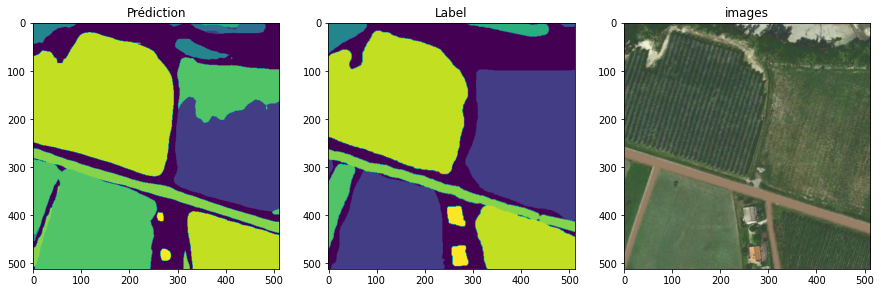

In [14]:
i = random.choice(valid_index)
print(i)
img = mmcv.imread('data/Real/images/{}.png'.format(i))
annotation = mmcv.imread('data/Real/annotations/{}.png'.format(i))

model.cfg = cfg
result = inference_segmentor(model, img)
result = np.array(result)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(result[0,...])
plt.gca().set_title("Prédiction")

plt.subplot(132)
plt.imshow(annotation[...,0])
plt.gca().set_title("Label")

plt.subplot(133)
plt.imshow(img[:,:,::-1])
plt.gca().set_title("images")
plt.show()

In [15]:
valid_imgs=[]
valid_labels=[]

for i in valid_index:
    img = mmcv.imread('data/Real/images/{}.png'.format(i))
    label = mmcv.imread('data/Real/annotations/{}.png'.format(i))
    valid_imgs.append(img)
    valid_labels.append(label)
    
valid_imgs = np.array(valid_imgs)
valid_labels = np.array(valid_labels)
valid_imgs.shape,valid_labels.shape

((53, 512, 512, 3), (53, 512, 512, 3))

In [16]:
predictions = []

for img in valid_imgs:
    result = inference_segmentor(model, img)
    predictions.append(result)

predictions = np.array(predictions)
predictions = np.squeeze(predictions)

In [17]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [19]:
predictions = to_categorical(predictions,12)
valid_labels = to_categorical(valid_labels[...,0],12)

In [20]:
true_label = np.argmax(valid_labels,axis=3)
label_pred = np.argmax(predictions,axis=3)

In [21]:
predictions = np.zeros(predictions.shape)

for idx_class in range(12):
    predictions[...,idx_class][label_pred == idx_class] = 1

In [22]:
iou = []
for idx_classe in range(12):
    prediction = predictions[...,idx_classe]
    target = valid_labels[...,idx_classe]

    intersection = np.logical_and(target,prediction)
    union = np.logical_or(target,prediction)
    iou_score = np.sum(intersection) / np.sum(union)

    iou.append(iou_score)
print(iou)
    
print("mIou: ", np.mean(iou))

[0.3661138971144968, 0.7053882474308614, 0.7940686550204307, 0.8109960762066847, 0.3661811611982245, 0.7824583165262645, 0.3654177436590055, 0.7234203515081079, 0.8098889357934572, 0.5238301272434996, 0.8954638701825383, 0.3184700459391793]
mIou:  0.621808118985229


###  test sur jeu de synthese

#split train/val set randomly
data_root = "data/synthese2/"
split_dir = 'splits_synthese/'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  #select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  #select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [25]:
import re
valid_index = []
with open(osp.join(data_root, split_dir) + "val.txt", 'r') as f:
    for line in f:
        num = re.findall(r'\d+',str(line)).pop()
        valid_index.append(num)

In [46]:
valid_imgs=[]
valid_labels=[]

for i in valid_index:
    img = mmcv.imread('data/synthese2/images/{}.png'.format(i))
    label = mmcv.imread('data/synthese2/annotations/{}.png'.format(i))
    valid_imgs.append(img)
    valid_labels.append(label)
    
valid_imgs = np.array(valid_imgs)
valid_labels = np.array(valid_labels)

((103, 512, 512, 3), (103, 512, 512, 3))

116


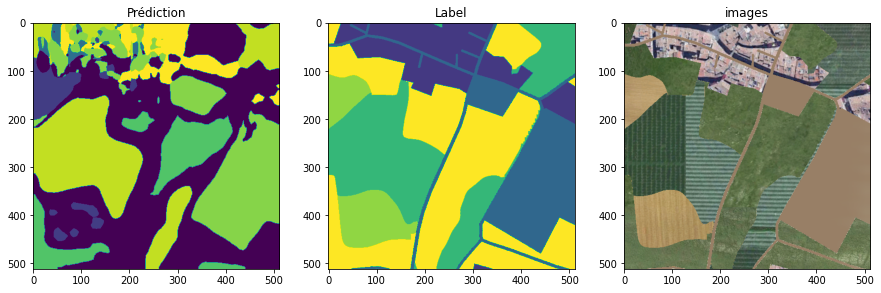

In [63]:
i = random.choice(valid_index)
print(i)
img = mmcv.imread('data/synthese2/images/{}.png'.format(i))
annotation = mmcv.imread('data/synthese2/annotations/{}.png'.format(i))

model.cfg = cfg
result = inference_segmentor(model, img)
result = np.array(result)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(result[0,...])
plt.gca().set_title("Prédiction")

plt.subplot(132)
plt.imshow(annotation[...,0])
plt.gca().set_title("Label")

plt.subplot(133)
plt.imshow(img[:,:,::-1])
plt.gca().set_title("images")
plt.show()

In [60]:
predictions = []

for img in valid_imgs:
    result = inference_segmentor(model, img)
    predictions.append(result)

predictions = np.array(predictions)
predictions = np.squeeze(predictions)

In [48]:
predictions = to_categorical(predictions,12)
valid_labels = to_categorical(valid_labels[...,0],12)

true_label = np.argmax(valid_labels,axis=3)
label_pred = np.argmax(predictions,axis=3)

predictions = np.zeros(predictions.shape)

for idx_class in range(11):
    predictions[...,idx_class][label_pred == idx_class] = 1


In [49]:
predictions.shape,valid_imgs.shape,valid_labels.shape

((103, 512, 512, 12), (103, 512, 512, 3), (103, 512, 512, 12))

In [50]:
classes_real = {0:"background",1:"buisson",2:"champs",3:"eau",
         4:"falaise",5:"foret_dense",6:"foret_claire",
         7:"pierrier",8:"prairie",9:"route",10:"verger",
         11:"batiment"}

classes_syn = {0: "falaise" , 1: "batiment", 2:"route",3:"pierrier",4:"verger",
            5:"champ",6:"prairie",7:"foret",8:"foret_claire",9:"buisson",10:"eau"}


correspondance = {0:4,1:11,2:9,3:7,4:10,5:2,6:8,7:5,8:6,9:1,10:3,11:0}

In [51]:
a = list(classes_syn.values())
a.append("background")

In [57]:
iou = {}
for idx_classe in range(11):
    # doesn't take into account background class since it is not present
    # in the synthese dataset
    target = valid_labels[...,idx_classe]

    intersection = np.logical_and(target,predictions[...,correspondance[idx_classe]])
    union = np.logical_or(target,predictions[...,correspondance[idx_classe]])
    iou_score = np.sum(intersection) / np.sum(union)
    iou[a[idx_classe]] = iou_score

print(iou)  
print("mIou: ", np.mean(list(iou.values())))

{'falaise': 0.27873871417500823, 'batiment': 0.0, 'route': 0.16367724484666768, 'pierrier': 0.0404649788629392, 'verger': 0.6381561767576317, 'champ': 0.48976290005527723, 'prairie': 0.39626818542349046, 'foret': 0.7225764550590683, 'foret_claire': 0.3791308658047189, 'buisson': 0.23296131768575357, 'eau': 0.4199531252068979}
mIou:  0.34197181489795025
